In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv("/home/ubuntu/cl-is/POC/Drift-Resilient_TabPFN/tabpfn/datasets/data/free_light_chain_mortality.csv")
df

,Unnamed: 0,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,1,97,F,1997,5.700,4.860,10,1.7,0,85,1,Circulatory
1,2,92,F,2000,0.870,0.683,1,0.9,0,1281,1,Neoplasms
2,3,94,F,1997,4.360,3.850,10,1.4,0,69,1,Circulatory
3,4,92,F,1996,2.420,2.220,9,1.0,0,115,1,Circulatory
4,5,93,F,1996,1.320,1.690,6,1.1,0,1039,1,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...,...
7869,7870,52,F,1995,1.210,1.610,6,1.0,0,4997,0,NaN
7870,7871,52,F,1999,0.858,0.581,1,0.8,0,3652,0,NaN
7871,7872,54,F,2002,1.700,1.720,8,NaN,0,2507,0,NaN
7872,7873,53,F,1995,1.710,2.690,9,NaN,0,4982,0,NaN


In [4]:
# Célula 1 - Imports e helpers
import time
import math
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
)

# tentar importar TabPFN (full) e, se não houver, instanciar TabPFNClassifier fallback
try:
    import tabpfn
    from tabpfn import TabPFNClassifier
    from tabpfn.best_models import get_best_tabpfn, TabPFNModelPathsConfig
    TABPFN_AVAILABLE = True
except Exception:
    try:
        from tabpfn import TabPFNClassifier  # caso a import acima falhe, tentar apenas a classe
        TABPFN_AVAILABLE = True
    except Exception:
        TABPFN_AVAILABLE = False

# Configs
RNG_SEED = 42
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)

DEFAULT_BATCH_SIZE_PREDICT = 512

Shape: (7874, 12)


,Unnamed: 0,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,1,97,F,1997,5.70,4.860,10,1.7,0,85,1,Circulatory
1,2,92,F,2000,0.87,0.683,1,0.9,0,1281,1,Neoplasms
2,3,94,F,1997,4.36,3.850,10,1.4,0,69,1,Circulatory
3,4,92,F,1996,2.42,2.220,9,1.0,0,115,1,Circulatory
4,5,93,F,1996,1.32,1.690,6,1.1,0,1039,1,Circulatory



Columns: ['Unnamed: 0', 'age', 'sex', 'sample.yr', 'kappa', 'lambda', 'flc.grp', 'creatinine', 'mgus', 'futime', 'death', 'chapter']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7874 entries, 0 to 7873
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7874 non-null   int64  
 1   age         7874 non-null   int64  
 2   sex         7874 non-null   object 
 3   sample.yr   7874 non-null   int64  
 4   kappa       7874 non-null   float64
 5   lambda      7874 non-null   float64
 6   flc.grp     7874 non-null   int64  
 7   creatinine  6524 non-null   float64
 8   mgus        7874 non-null   int64  
 9   futime      7874 non-null   int64  
 10  death       7874 non-null   int64  
 11  chapter     2169 non-null   object 
dtypes: float64(3), int64(7), object(2)
memory usage: 738.3+ KB


None


Missing values per column:


Unnamed: 0       0
age              0
sex              0
sample.yr        0
kappa            0
lambda           0
flc.grp          0
creatinine    1350
mgus             0
futime           0
death            0
chapter       5705
dtype: int64


Estatísticas descritivas (numéricas):


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,7874.0,3937.5,2273.172343,1.0,1969.25,3937.5,5905.75,7874.0
age,7874.0,64.293117,10.462719,50.0,55.0,63.0,72.0,101.0
year,7874.0,1996.790831,1.765156,1995.0,1996.0,1996.0,1997.0,2003.0
kappa,7874.0,1.430881,0.896774,0.01,0.96,1.27,1.68,20.5
lambda,7874.0,1.702624,1.030732,0.04,1.2,1.51,1.92,26.6
flc.grp,7874.0,5.470536,2.863011,1.0,3.0,5.0,8.0,10.0
creatinine,6524.0,1.093516,0.416507,0.4,0.9,1.0,1.2,10.8
mgus,7874.0,0.014605,0.119973,0.0,0.0,0.0,0.0,1.0
futime,7874.0,3661.042291,1432.67733,0.0,2852.0,4302.0,4773.0,5215.0
death,7874.0,0.275464,0.446776,0.0,0.0,0.0,1.0,1.0


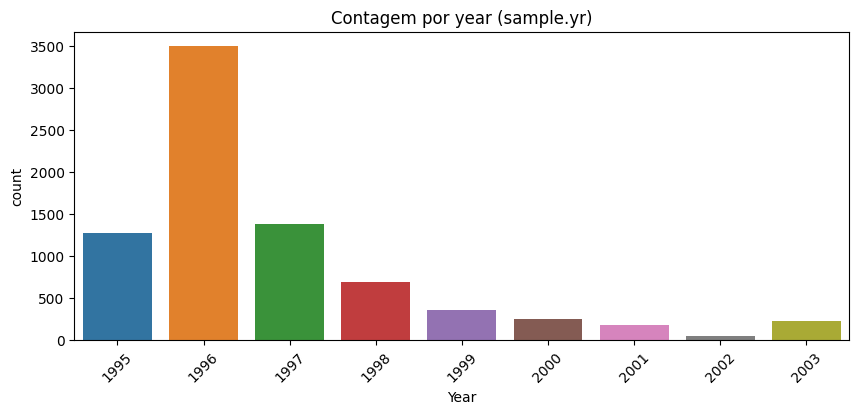

,count,sum,death_rate
year,,,
1995,1275,414,0.324706
1996,3491,1056,0.302492
1997,1381,369,0.267198
1998,687,161,0.234352
1999,350,67,0.191429
2000,245,52,0.212245
2001,175,38,0.217143
2002,48,1,0.020833
2003,222,11,0.049550


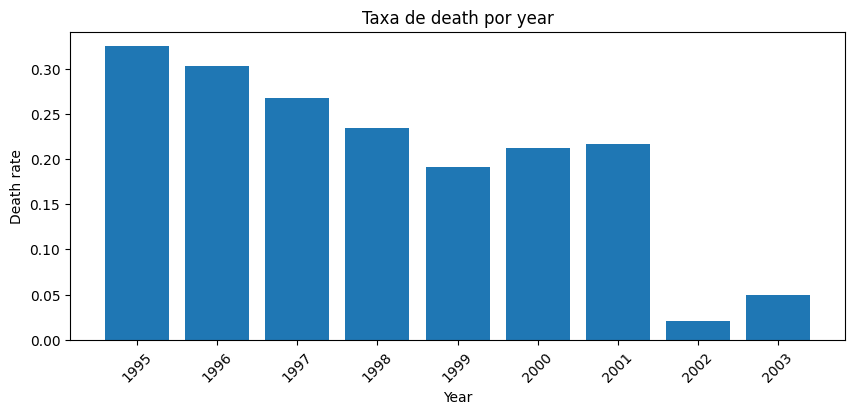

/home/ubuntu/.tabpfn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/.tabpfn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/.tabpfn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/.tabpfn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

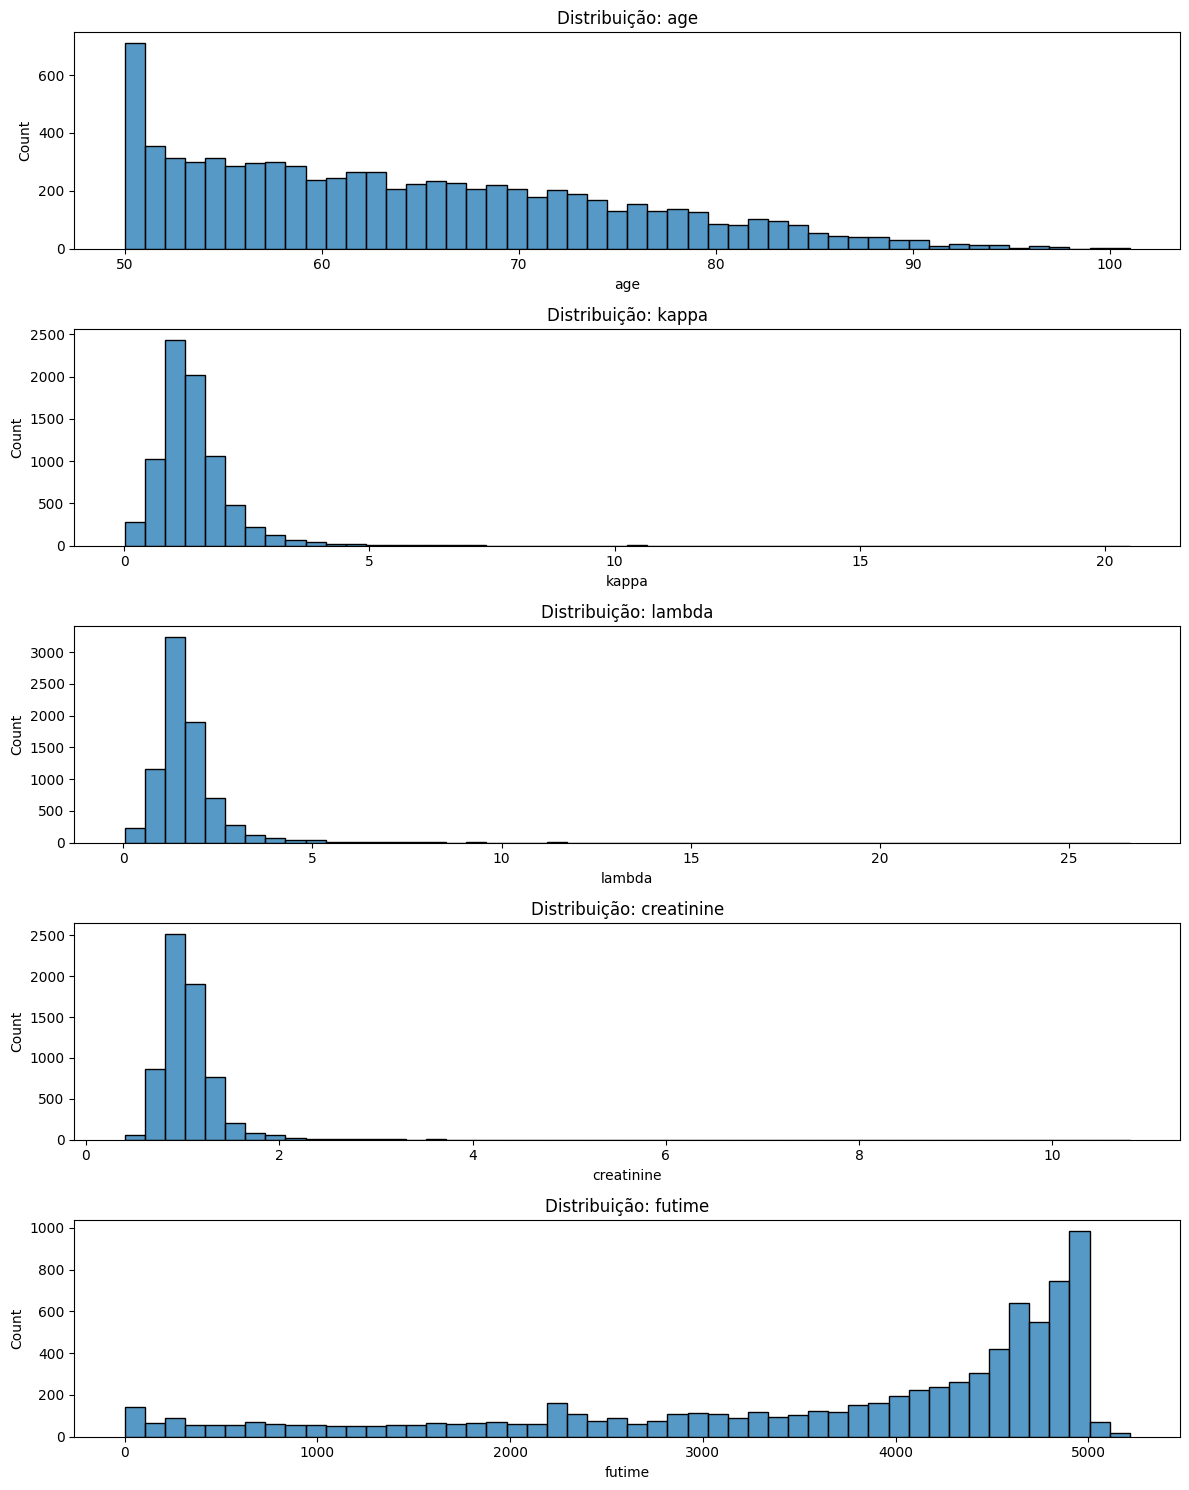

sex
F    4350
M    3524
Name: count, dtype: int64

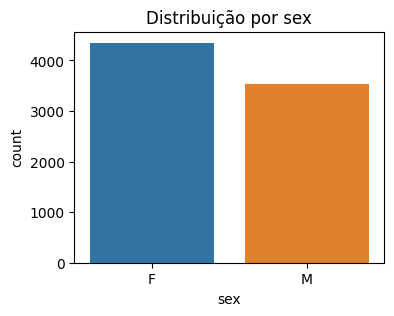

In [5]:
# Célula 2 - Carregar dados e EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "/home/ubuntu/cl-is/POC/Drift-Resilient_TabPFN/tabpfn/datasets/data/free_light_chain_mortality.csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())

print("\nColumns:", df.columns.tolist())
print("\nInfo:")
display(df.info())

print("\nMissing values per column:")
display(df.isnull().sum())

# Renomear coluna de ano para 'year' para consistência com o notebook anterior
if 'sample.yr' in df.columns:
    df = df.rename(columns={'sample.yr': 'year'})

# Converter year para int (quando possível)
df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')

# Estatísticas gerais
print("\nEstatísticas descritivas (numéricas):")
display(df.describe(include=[np.number]).T)

# Distribuição de anos
plt.figure(figsize=(10,4))
sns.countplot(x=df['year'].astype(str), order=sorted(df['year'].dropna().unique().astype(int).astype(str)))
plt.title("Contagem por year (sample.yr)")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.show()

# Taxa de death por ano
if 'death' in df.columns:
    death_by_year = df.groupby('year')['death'].agg(['count','sum'])
    death_by_year['death_rate'] = death_by_year['sum'] / death_by_year['count']
    display(death_by_year)
    plt.figure(figsize=(10,4))
    plt.bar(death_by_year.index.astype(str), death_by_year['death_rate'])
    plt.title("Taxa de death por year")
    plt.xlabel("Year")
    plt.ylabel("Death rate")
    plt.xticks(rotation=45)
    plt.show()

# Histogramas das features numéricas principais
num_cols = ['age','kappa','lambda','creatinine','futime']
num_cols = [c for c in num_cols if c in df.columns]
plt.figure(figsize=(12, 3*len(num_cols)))
for i, c in enumerate(num_cols,1):
    plt.subplot(len(num_cols),1,i)
    sns.histplot(df[c].dropna(), kde=False, bins=50)
    plt.title(f"Distribuição: {c}")
plt.tight_layout()
plt.show()

# Sexo
if 'sex' in df.columns:
    display(df['sex'].value_counts(dropna=False))
    plt.figure(figsize=(4,3))
    sns.countplot(x=df['sex'])
    plt.title("Distribuição por sex")
    plt.show()

In [6]:
# Célula 3 - Pré-processamento
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Escolha de features (ajuste se quiser incluir/excluir)
feature_cols = []
for c in ['age','kappa','lambda','flc.grp','creatinine','mgus','futime']:
    if c in df.columns:
        feature_cols.append(c)

# One-hot / encoding simples para 'sex'
df_proc = df.copy()
if 'sex' in df_proc.columns:
    # mapear F->0 M->1 (tentar robustez)
    df_proc['sex_bin'] = df_proc['sex'].astype(str).str.upper().map({'F':0,'M':1})
    # se existirem outros valores, preencher com NaN depois imputar
    feature_cols = ['sex_bin'] + feature_cols

# Construir X (DataFrame) com as features selecionadas
X_df = df_proc[feature_cols].copy()
y = df_proc['death'].fillna(0).astype(int).values  # garantir int 0/1

# Imputação numérica (mediana)
num_imputer = SimpleImputer(strategy='median')
X_df_imputed = pd.DataFrame(num_imputer.fit_transform(X_df), columns=X_df.columns, index=X_df.index)

print("Features usadas:", X_df_imputed.columns.tolist())
print("X shape:", X_df_imputed.shape, "y shape:", y.shape)
display(X_df_imputed.head())

Features usadas: ['sex_bin', 'age', 'kappa', 'lambda', 'flc.grp', 'creatinine', 'mgus', 'futime']
X shape: (7874, 8) y shape: (7874,)


,sex_bin,age,kappa,lambda,flc.grp,creatinine,mgus,futime
0,0.0,97.0,5.70,4.860,10.0,1.7,0.0,85.0
1,0.0,92.0,0.87,0.683,1.0,0.9,0.0,1281.0
2,0.0,94.0,4.36,3.850,10.0,1.4,0.0,69.0
3,0.0,92.0,2.42,2.220,9.0,1.0,0.0,115.0
4,0.0,93.0,1.32,1.690,6.0,1.1,0.0,1039.0


In [7]:
# Célula 4 - Split temporal (train/test) e mapping year->domain
import numpy as np
import pandas as pd

# Garantir coluna year presente
if 'year' not in df_proc.columns:
    raise RuntimeError("Coluna 'year' (sample.yr) não encontrada no dataframe.")

years_all = sorted(df_proc['year'].dropna().unique().astype(int))
print("Anos disponíveis:", years_all)

# Proporção de treino (ajustável)
TRAIN_YEAR_FRAC = 0.7
n_years = len(years_all)
n_train_years = max(1, int(math.floor(n_years * TRAIN_YEAR_FRAC)))
TRAIN_YEARS = years_all[:n_train_years]
TEST_YEARS = years_all[n_train_years:]
print("TRAIN_YEARS:", TRAIN_YEARS)
print("TEST_YEARS:", TEST_YEARS)

# Filtrar por ano
train_mask = df_proc['year'].notna() & df_proc['year'].astype(int).isin(TRAIN_YEARS)
test_mask = df_proc['year'].notna() & df_proc['year'].astype(int).isin(TEST_YEARS)

X_train_df = X_df_imputed.loc[train_mask].reset_index(drop=True)
y_train = y[train_mask.values]
years_train = df_proc.loc[train_mask, 'year'].astype(int).values

X_test_df = X_df_imputed.loc[test_mask].reset_index(drop=True)
y_test = y[test_mask.values]
years_test = df_proc.loc[test_mask, 'year'].astype(int).values

print("Train samples:", X_train_df.shape[0], "Test samples:", X_test_df.shape[0])
if X_train_df.shape[0] == 0 or X_test_df.shape[0] == 0:
    raise RuntimeError("Split temporal resultou em conjunto vazio. Ajuste TRAIN_YEAR_FRAC ou verifique anos no dataset.")

# Construir mapping year -> domain (inclui train+test)
combined_years = sorted(set(TRAIN_YEARS).union(set(TEST_YEARS)))
year_to_domain_combined = {y:i for i,y in enumerate(combined_years)}
print("year_to_domain_combined (sample):", list(year_to_domain_combined.items())[:10])

# Dist arrays int64 (por linha)
dist_shift_domain_train_np = np.array([year_to_domain_combined[int(y)] for y in years_train], dtype=np.int64)
dist_shift_domain_test_np = np.array([year_to_domain_combined[int(y)] for y in years_test], dtype=np.int64)

# Converter X para numpy float32
X_train_np = X_train_df.values.astype(np.float32)
X_test_np = X_test_df.values.astype(np.float32)

print("Shapes: X_train_np", X_train_np.shape, "X_test_np", X_test_np.shape)

Anos disponíveis: [1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003]
TRAIN_YEARS: [1995, 1996, 1997, 1998, 1999, 2000]
TEST_YEARS: [2001, 2002, 2003]
Train samples: 7429 Test samples: 445
year_to_domain_combined (sample): [(1995, 0), (1996, 1), (1997, 2), (1998, 3), (1999, 4), (2000, 5), (2001, 6), (2002, 7), (2003, 8)]
Shapes: X_train_np (7429, 8) X_test_np (445, 8)


In [8]:
# Célula 5 - Instanciar e treinar TabPFN com additional_x (drift)
import time
import torch

run_id = "tabpfn_temporal_fit_free_light_chain"

# Instanciar modelo TabPFN (tentar carregar modelo otimizado se houver)
drift_model = None
try:
    # tentar carregar model cache (se tabpfn instalado com best_models)
    if TABPFN_AVAILABLE:
        try:
            libpath = Path(tabpfn.__file__).parents[0]
            model_path_config = TabPFNModelPathsConfig(paths=[f"{libpath}/model_cache/tabpfn_dist_model_1.cpkt"], task_type="dist_shift_multiclass")
            drift_model = get_best_tabpfn(task_type="dist_shift_multiclass", model_type="single_fast", paths_config=model_path_config, debug=False, device="auto")
            drift_model.show_progress = False
            drift_model.seed = RNG_SEED
            print(f"[{run_id}] Carregado via get_best_tabpfn.")
        except Exception:
            drift_model = TabPFNClassifier(device="auto")
            drift_model.show_progress = False
            print(f"[{run_id}] Instanciado TabPFNClassifier(device='auto') (fallback).")
    else:
        raise ImportError("TabPFN não disponível.")
except Exception as e:
    # última tentativa simples
    try:
        from tabpfn import TabPFNClassifier
        drift_model = TabPFNClassifier(device="auto")
        drift_model.show_progress = False
        print(f"[{run_id}] TabPFNClassifier instanciado via fallback.")
    except Exception as e2:
        raise RuntimeError("Não foi possível instanciar TabPFN. Instale tabpfn (full) ou verifique ambiente.") from e2

# Fit com additional_x
t0 = time.perf_counter()
print(f"[{run_id}] Fit iniciando: X_train shape = {X_train_np.shape}, y_train pos ratio = {float(y_train.mean()):.4f}")
drift_model = drift_model.fit(X_train_np, y_train, additional_x={"dist_shift_domain": dist_shift_domain_train_np})
t_fit = time.perf_counter() - t0
print(f"[{run_id}] Fit concluído em {t_fit:.2f}s.")

# Detectar device/shape de additional_x_ interno (se presente)
model_add_x_device = torch.device("cpu")
example_add_shape = None
try:
    if hasattr(drift_model, 'additional_x_') and drift_model.additional_x_ is not None and 'dist_shift_domain' in drift_model.additional_x_:
        v = drift_model.additional_x_['dist_shift_domain']
        if isinstance(v, torch.Tensor):
            model_add_x_device = v.device
            example_add_shape = tuple(v.shape)
        else:
            example_add_shape = np.asarray(v).shape
except Exception:
    model_add_x_device = torch.device("cpu")
    example_add_shape = None

print("additional_x_ device (inferred):", model_add_x_device, "example_add_shape:", example_add_shape)

[tabpfn_temporal_fit_free_light_chain] Carregado via get_best_tabpfn.
[tabpfn_temporal_fit_free_light_chain] Fit iniciando: X_train shape = (7429, 8), y_train pos ratio = 0.2852
Initialized decoder for standard with (None, 10)  and nout 10


[tabpfn_temporal_fit_free_light_chain] Fit concluído em 0.35s.
additional_x_ device (inferred): cpu example_add_shape: (7429, 1, 1)


Inferência concluída em 2.31s (total)

Métricas globais (test):
Accuracy: 0.9573
Precision (macro): 0.9399, Recall (macro): 0.8362, F1 (macro): 0.8790
Precision (pos): 0.9189, Recall (pos): 0.6800, F1 (pos): 0.7816

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       395
           1       0.92      0.68      0.78        50

    accuracy                           0.96       445
   macro avg       0.94      0.84      0.88       445
weighted avg       0.96      0.96      0.95       445

ROC AUC (pos class): 0.9417215189873418


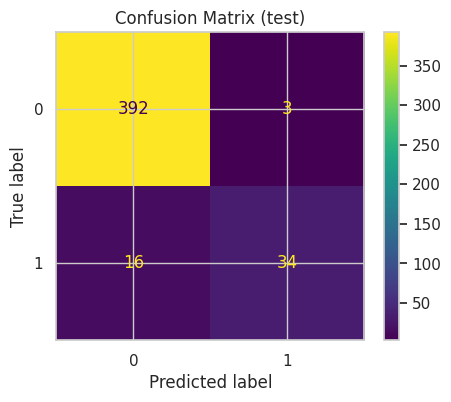

In [9]:
# Célula 6 - Inferência e métricas no conjunto de teste (batched)
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# Função utilitária (adaptação do notebook) para criar tensor de domínio compatível
def make_dist_tensor(dist_np, device, target_shape_example=None):
    t = torch.tensor(dist_np, dtype=torch.long, device=device)
    if target_shape_example is not None and isinstance(target_shape_example, tuple) and len(target_shape_example) >= 3:
        if t.ndim == 1:
            t = t.reshape(-1,1,1)
    else:
        if t.ndim == 1:
            t = t.reshape(-1,1,1)
    return t

# Batch predict
batch_size = DEFAULT_BATCH_SIZE_PREDICT
n_samples = X_test_np.shape[0]
preds_proba_list = []

t0 = time.perf_counter()
for start in range(0, n_samples, batch_size):
    end = min(start + batch_size, n_samples)
    Xb_np = X_test_np[start:end].astype(np.float32)
    dist_dom_np = dist_shift_domain_test_np[start:end]

    # montar dist tensor no device correto (inferido do modelo quando possível)
    try:
        dist_dom_t = make_dist_tensor(dist_dom_np, device=model_add_x_device, target_shape_example=example_add_shape)
    except Exception:
        # fallback para CPU
        dist_dom_t = make_dist_tensor(dist_dom_np, device=torch.device("cpu"), target_shape_example=example_add_shape)

    # chamar predict_proba de forma robusta
    try:
        if getattr(model_add_x_device, "type", "cpu") == "cpu":
            preds_proba_batch = drift_model.predict_proba(Xb_np, additional_x={"dist_shift_domain": dist_dom_t})
        else:
            # mandar tensor X também para o device se necessário
            Xb_t = torch.tensor(Xb_np, dtype=torch.float32, device=model_add_x_device)
            with torch.no_grad():
                preds_proba_batch = drift_model.predict_proba(Xb_t, additional_x={"dist_shift_domain": dist_dom_t})
    except Exception as e:
        # fallback: tentar passar numpy + numpy dist (algumas versões aceitam)
        try:
            preds_proba_batch = drift_model.predict_proba(Xb_np, additional_x={"dist_shift_domain": dist_dom_np})
        except Exception as e2:
            raise RuntimeError(f"predict_proba falhou para batch {start}:{end}: {e} | {e2}")

    if isinstance(preds_proba_batch, torch.Tensor):
        preds_proba_batch = preds_proba_batch.detach().cpu().numpy()
    preds_proba_list.append(np.asarray(preds_proba_batch))

t_infer = time.perf_counter() - t0
probs_all = np.vstack(preds_proba_list)
# Se saída for multiclass (n, n_classes), escolher prob da classe 1 como prob positiva
if probs_all.ndim == 2 and probs_all.shape[1] > 1:
    probs_pos = probs_all[:,1]
else:
    probs_pos = probs_all.ravel()

# Predições binárias com threshold 0.5
y_pred = (probs_pos >= 0.5).astype(int)

# Métricas globais
acc = accuracy_score(y_test, y_pred)
prec_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
rec_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
prec_pos = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
rec_pos = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
f1_pos = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

print("Inferência concluída em {:.2f}s (total)".format(t_infer))
print("\nMétricas globais (test):")
print(f"Accuracy: {acc:.4f}")
print(f"Precision (macro): {prec_macro:.4f}, Recall (macro): {rec_macro:.4f}, F1 (macro): {f1_macro:.4f}")
print(f"Precision (pos): {prec_pos:.4f}, Recall (pos): {rec_pos:.4f}, F1 (pos): {f1_pos:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, zero_division=0))

# ROC AUC (se possível)
try:
    auc = roc_auc_score(y_test, probs_pos)
    print("ROC AUC (pos class):", auc)
except Exception:
    print("ROC AUC não calculável (talvez variável de saída ou classes inválidas).")

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax)
plt.title("Confusion Matrix (test)")
plt.show()

,year,n_samples,n_deaths,accuracy,precision_macro,recall_macro,f1_macro,precision_pos,recall_pos,f1_pos,auc
0,2001,175,38,0.931429,0.932184,0.861122,0.890488,0.933333,0.736842,0.823529,0.958894
1,2002,48,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,2003,222,11,0.968468,0.902778,0.724903,0.785921,0.833333,0.454545,0.588235,0.970271


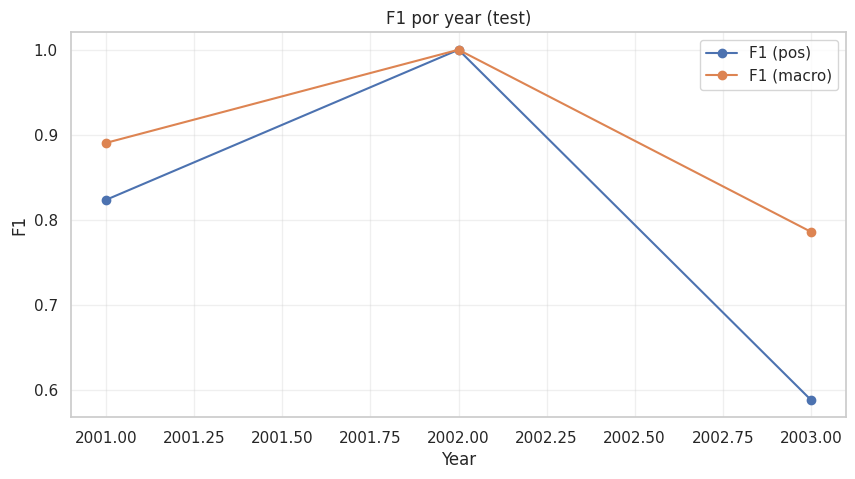

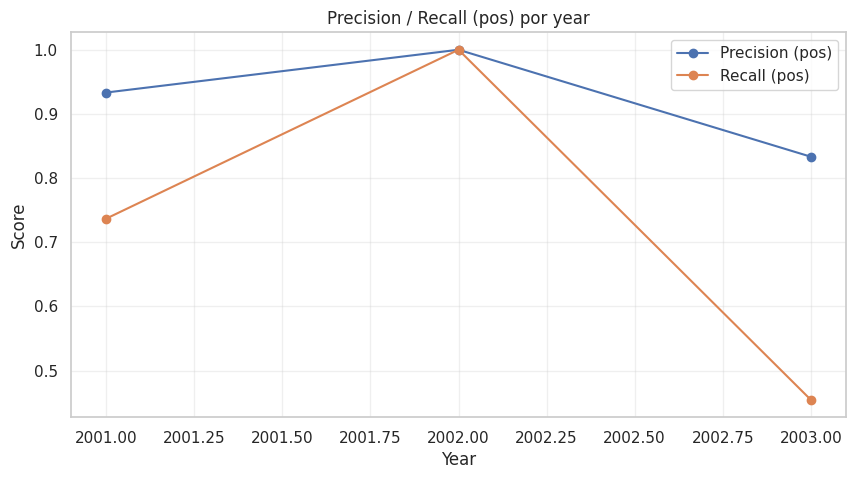

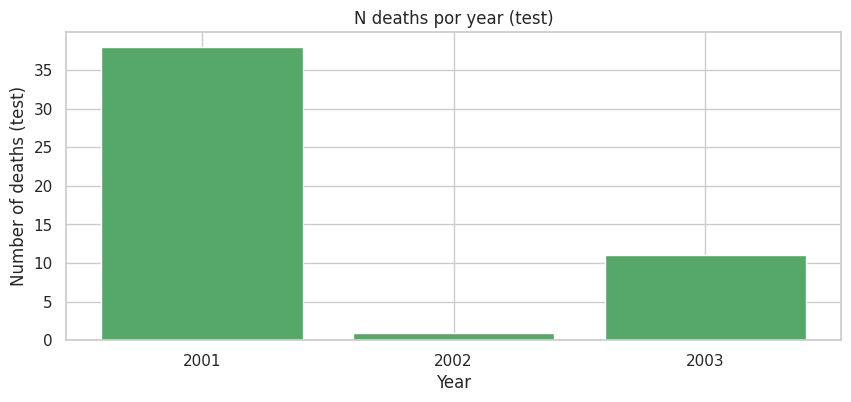

In [10]:
# Célula 7 - Métricas por ano e plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

results_by_year = []
unique_test_years = sorted(np.unique(years_test))
for yr in unique_test_years:
    idx = np.where(years_test == yr)[0]
    if len(idx) == 0:
        continue
    y_true_yr = y_test[idx]
    y_pred_yr = y_pred[idx]
    probs_yr = probs_pos[idx]
    n_samples = len(idx)
    n_deaths = int(y_true_yr.sum())
    acc_yr = accuracy_score(y_true_yr, y_pred_yr)
    prec_macro_yr = precision_score(y_true_yr, y_pred_yr, average='macro', zero_division=0)
    rec_macro_yr = recall_score(y_true_yr, y_pred_yr, average='macro', zero_division=0)
    f1_macro_yr = f1_score(y_true_yr, y_pred_yr, average='macro', zero_division=0)
    prec_pos_yr = precision_score(y_true_yr, y_pred_yr, pos_label=1, zero_division=0)
    rec_pos_yr = recall_score(y_true_yr, y_pred_yr, pos_label=1, zero_division=0)
    f1_pos_yr = f1_score(y_true_yr, y_pred_yr, pos_label=1, zero_division=0)
    try:
        auc_yr = roc_auc_score(y_true_yr, probs_yr) if len(np.unique(y_true_yr))>1 else None
    except Exception:
        auc_yr = None

    results_by_year.append({
        "year": int(yr),
        "n_samples": int(n_samples),
        "n_deaths": int(n_deaths),
        "accuracy": float(acc_yr),
        "precision_macro": float(prec_macro_yr),
        "recall_macro": float(rec_macro_yr),
        "f1_macro": float(f1_macro_yr),
        "precision_pos": float(prec_pos_yr),
        "recall_pos": float(rec_pos_yr),
        "f1_pos": float(f1_pos_yr),
        "auc": float(auc_yr) if auc_yr is not None else None
    })

res_df = pd.DataFrame(results_by_year).sort_values('year').reset_index(drop=True)
display(res_df)

# Plots
plt.figure(figsize=(10,5))
plt.plot(res_df['year'], res_df['f1_pos'], marker='o', label='F1 (pos)')
plt.plot(res_df['year'], res_df['f1_macro'], marker='o', label='F1 (macro)')
plt.xlabel('Year')
plt.ylabel('F1')
plt.title('F1 por year (test)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Precision/Recall pos over years
plt.figure(figsize=(10,5))
plt.plot(res_df['year'], res_df['precision_pos'], marker='o', label='Precision (pos)')
plt.plot(res_df['year'], res_df['recall_pos'], marker='o', label='Recall (pos)')
plt.xlabel('Year')
plt.ylabel('Score')
plt.title('Precision / Recall (pos) por year')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Bar: n_deaths por ano
plt.figure(figsize=(10,4))
plt.bar(res_df['year'].astype(str), res_df['n_deaths'], color='C2')
plt.xlabel('Year')
plt.ylabel('Number of deaths (test)')
plt.title('N deaths por year (test)')
plt.show()

In [11]:
# Célula 1 - Normalização das features numéricas (fit no train apenas)
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
import joblib
from pathlib import Path

# As variáveis esperadas (do pipeline anterior):
# X_train_df, X_test_df, years_train, years_test, feature_cols (se existir)
# Se não existirem no ambiente, ajuste para recriar/ler.

# Escolhendo scaler (StandardScaler padrão; descomente RobustScaler se preferir)
scaler = StandardScaler()
# scaler = RobustScaler()

# Ajustar scaler apenas no conjunto de treino (evitar data leakage)
scaler.fit(X_train_df)

# Transformar train e test
X_train_df_norm = pd.DataFrame(scaler.transform(X_train_df), columns=X_train_df.columns, index=X_train_df.index)
X_test_df_norm = pd.DataFrame(scaler.transform(X_test_df), columns=X_test_df.columns, index=X_test_df.index)

# Matrizes numpy para treino/inferência
X_train_np_norm = X_train_df_norm.values.astype(np.float32)
X_test_np_norm = X_test_df_norm.values.astype(np.float32)

print("Normalization complete.")
print("X_train_df_norm shape:", X_train_df_norm.shape)
print("X_test_df_norm shape:", X_test_df_norm.shape)

# salvar scaler para reuso (opcional)
OUT_DIR = Path.cwd() / "tabpfn_free_light_chain_results"
OUT_DIR.mkdir(exist_ok=True)
joblib.dump(scaler, OUT_DIR / "scaler_standard.pkl")
print("Scaler salvo em:", OUT_DIR / "scaler_standard.pkl")

Normalization complete.
X_train_df_norm shape: (7429, 8)
X_test_df_norm shape: (445, 8)
Scaler salvo em: /home/ubuntu/cl-is/POC/tcav/tabpfn_free_light_chain_results/scaler_standard.pkl


In [12]:
# Célula 2 - Função walk-forward (rolling) por anos e exemplo de uso
import numpy as np
import pandas as pd
from typing import List, Tuple

def temporal_walk_forward_indices(years: np.ndarray,
                                  unique_years_sorted: List[int],
                                  initial_train_years: int = None,
                                  test_window: int = 1,
                                  step: int = 1) -> List[Tuple[np.ndarray, np.ndarray]]:
    """
    Gera índices (train_idx, test_idx) para walk-forward por anos.
    - years: array (n_samples,) com o ano de cada amostra (int)
    - unique_years_sorted: lista de anos únicos ordenados (p.ex. sorted(np.unique(years)))
    - initial_train_years: número de anos iniciais a usar como treino na primeira iteração.
        Se None, será usado inicialmente floor(0.5 * n_unique_years).
    - test_window: quantos anos (contíguos em unique_years_sorted) compõem o conjunto de teste em cada fold.
    - step: quantos anos avançar a cada iteração (em termos de posição na unique_years_sorted).
    Retorna lista de (train_idx, test_idx) com índices relativos a `years`.
    """
    yrs = np.asarray(years, dtype=int)
    uniq = list(unique_years_sorted)
    n_uniq = len(uniq)
    if initial_train_years is None:
        initial_train_years = max(1, n_uniq // 2)
    folds = []
    # start index of train end in unique years list (exclusive index)
    train_end_pos = initial_train_years - 1  # index in uniq that is last train year
    while train_end_pos < n_uniq - 1:
        # determine train years up to uniq[train_end_pos]
        train_years = set(uniq[:train_end_pos+1])
        # test years: next test_window years after train_end_pos
        test_start = train_end_pos + 1
        test_end = min(n_uniq - 1, train_end_pos + test_window)
        test_years = set(uniq[test_start:test_end+1])
        if len(test_years) == 0:
            break
        train_idx = np.where(np.isin(yrs, list(train_years)))[0]
        test_idx = np.where(np.isin(yrs, list(test_years)))[0]
        if len(train_idx) > 0 and len(test_idx) > 0:
            folds.append((train_idx, test_idx))
        train_end_pos += step
    return folds

# Exemplo de uso com as variáveis do pipeline:
# years_all_sorted já conhecida: combined_years ou years_all (do pipeline)
unique_years_sorted = sorted(df_proc['year'].dropna().unique().astype(int))
folds = temporal_walk_forward_indices(years=df_proc['year'].fillna(-1).astype(int).values,
                                      unique_years_sorted=unique_years_sorted,
                                      initial_train_years=max(1, int(len(unique_years_sorted)*0.5)),
                                      test_window=1,
                                      step=1)
print(f"Generated {len(folds)} temporal folds (walk-forward). Example (first 3):")
for i, (tr_idx, te_idx) in enumerate(folds[:3]):
    train_years = sorted(np.unique(df_proc['year'].astype(int).values[tr_idx]))
    test_years = sorted(np.unique(df_proc['year'].astype(int).values[te_idx]))
    print(f" Fold {i+1}: train years {train_years[0]}..{train_years[-1]} (n={len(tr_idx)}) -> test years {test_years} (n={len(te_idx)})")

Generated 5 temporal folds (walk-forward). Example (first 3):
 Fold 1: train years 1995..1998 (n=6834) -> test years [1999] (n=350)
 Fold 2: train years 1995..1999 (n=7184) -> test years [2000] (n=245)
 Fold 3: train years 1995..2000 (n=7429) -> test years [2001] (n=175)


PCA 2D explained variance (sum): 0.548


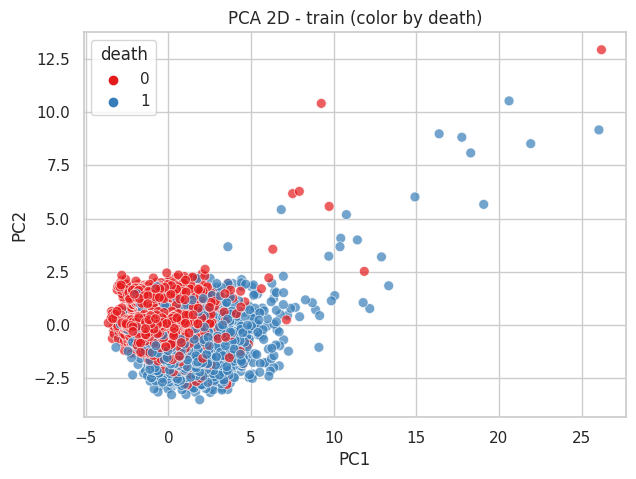

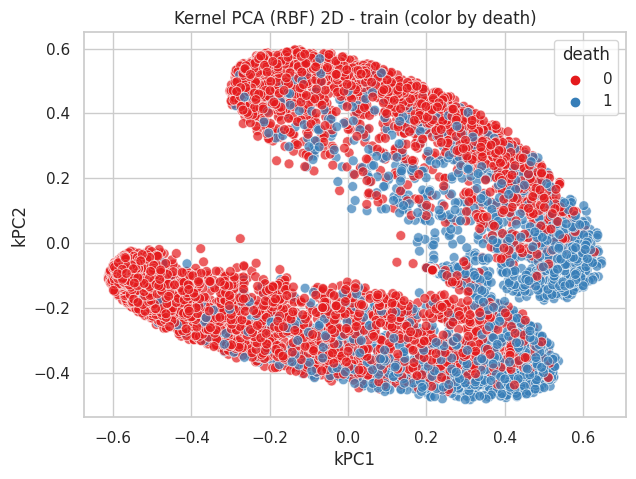

Linear (LogReg) CV AUC: 0.9401 ± 0.0098
Kernel (SVM-RBF) CV AUC: 0.9436 ± 0.0096

Linear (LogReg) CV Accuracy: 0.8871 ± 0.0090
Kernel (SVM-RBF) CV Accuracy: 0.8941 ± 0.0077

Linear (LogReg) CV F1: 0.7872 ± 0.0185
Kernel (SVM-RBF) CV F1: 0.8062 ± 0.0150

AUC gap (SVM-RBF - LogReg): 0.0035
=> Indicação: dados possivelmente perto de linearmente separáveis (diferença pequena).


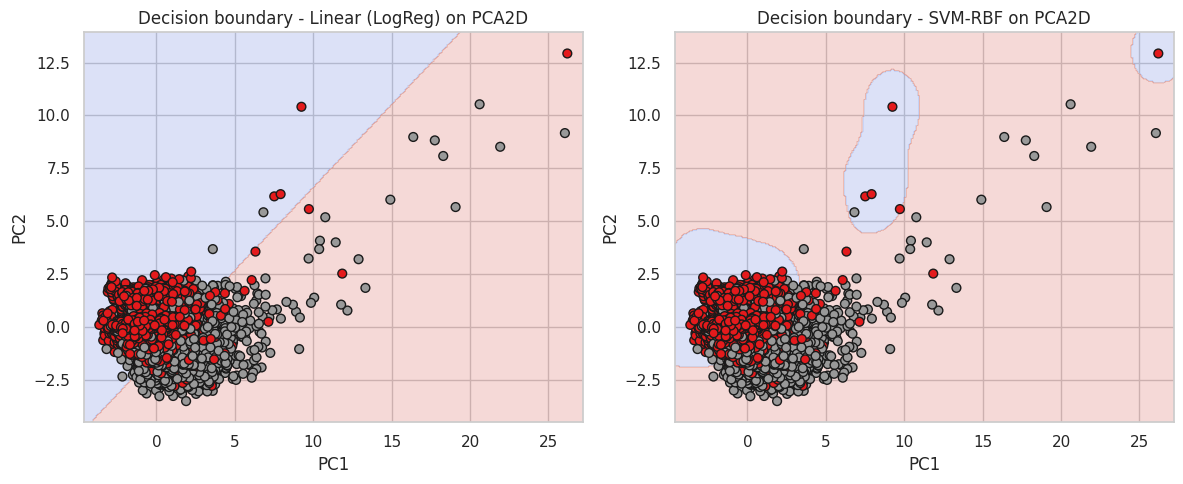

In [13]:
# Célula 3 - Visualizar e testar linear separability
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# 1) PCA 2D
pca = PCA(n_components=2, random_state=RNG_SEED)
X_pca2 = pca.fit_transform(X_train_np_norm)
explained = pca.explained_variance_ratio_.sum()
print(f"PCA 2D explained variance (sum): {explained:.3f}")
plt.figure(figsize=(7,5))
sns.scatterplot(x=X_pca2[:,0], y=X_pca2[:,1], hue=y_train, palette="Set1", alpha=0.7, s=50)
plt.title("PCA 2D - train (color by death)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(title="death")
plt.show()

# 2) Kernel PCA (RBF) 2D
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=None, random_state=RNG_SEED)
X_kpca2 = kpca.fit_transform(X_train_np_norm)
plt.figure(figsize=(7,5))
sns.scatterplot(x=X_kpca2[:,0], y=X_kpca2[:,1], hue=y_train, palette="Set1", alpha=0.7, s=50)
plt.title("Kernel PCA (RBF) 2D - train (color by death)")
plt.xlabel("kPC1"); plt.ylabel("kPC2")
plt.legend(title="death")
plt.show()

# 3) Compare performance: linear vs kernel models (CV on training set)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG_SEED)

# Linear classifier (Logistic Regression)
lr = LogisticRegression(max_iter=2000, solver='liblinear', random_state=RNG_SEED)
scores_lr_auc = cross_val_score(lr, X_train_np_norm, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
scores_lr_acc = cross_val_score(lr, X_train_np_norm, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
scores_lr_f1 = cross_val_score(lr, X_train_np_norm, y_train, cv=cv, scoring='f1', n_jobs=-1)

# Kernel classifier (RBF SVM) - probabilistic output via probability=True (custo maior)
svm_rbf = SVC(kernel='rbf', probability=True, gamma='scale', C=1.0, random_state=RNG_SEED)
scores_svm_auc = cross_val_score(svm_rbf, X_train_np_norm, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
scores_svm_acc = cross_val_score(svm_rbf, X_train_np_norm, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
scores_svm_f1 = cross_val_score(svm_rbf, X_train_np_norm, y_train, cv=cv, scoring='f1', n_jobs=-1)

print("Linear (LogReg) CV AUC: {:.4f} ± {:.4f}".format(scores_lr_auc.mean(), scores_lr_auc.std()))
print("Kernel (SVM-RBF) CV AUC: {:.4f} ± {:.4f}".format(scores_svm_auc.mean(), scores_svm_auc.std()))
print()
print("Linear (LogReg) CV Accuracy: {:.4f} ± {:.4f}".format(scores_lr_acc.mean(), scores_lr_acc.std()))
print("Kernel (SVM-RBF) CV Accuracy: {:.4f} ± {:.4f}".format(scores_svm_acc.mean(), scores_svm_acc.std()))
print()
print("Linear (LogReg) CV F1: {:.4f} ± {:.4f}".format(scores_lr_f1.mean(), scores_lr_f1.std()))
print("Kernel (SVM-RBF) CV F1: {:.4f} ± {:.4f}".format(scores_svm_f1.mean(), scores_svm_f1.std()))

# Heurística simples de linear separability:
auc_gap = scores_svm_auc.mean() - scores_lr_auc.mean()
print(f"\nAUC gap (SVM-RBF - LogReg): {auc_gap:.4f}")
if auc_gap > 0.05:
    print("=> Indicação: dados provavelmente não linearmente separáveis (kernel model muito melhor).")
else:
    print("=> Indicação: dados possivelmente perto de linearmente separáveis (diferença pequena).")

# 4) Visualizar decisão linear vs RBF no espaço PCA2D (apenas para intuição)
# treinar modelos no PCA2D (apenas para visualizar)
lr_pca = LogisticRegression(max_iter=2000, solver='liblinear', random_state=RNG_SEED).fit(X_pca2, y_train)
svm_rbf_pca = SVC(kernel='rbf', probability=True, gamma='scale', C=1.0, random_state=RNG_SEED).fit(X_pca2, y_train)

# grid para plot
xx_min, xx_max = X_pca2[:,0].min() - 1.0, X_pca2[:,0].max() + 1.0
yy_min, yy_max = X_pca2[:,1].min() - 1.0, X_pca2[:,1].max() + 1.0
xx, yy = np.meshgrid(np.linspace(xx_min, xx_max, 300), np.linspace(yy_min, yy_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

Z_lr = lr_pca.predict(grid).reshape(xx.shape)
Z_svm = svm_rbf_pca.predict(grid).reshape(xx.shape)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.contourf(xx, yy, Z_lr, alpha=0.2, cmap='coolwarm')
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=y_train, cmap='Set1', edgecolor='k', s=40)
plt.title("Decision boundary - Linear (LogReg) on PCA2D")
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.subplot(1,2,2)
plt.contourf(xx, yy, Z_svm, alpha=0.2, cmap='coolwarm')
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=y_train, cmap='Set1', edgecolor='k', s=40)
plt.title("Decision boundary - SVM-RBF on PCA2D")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()

In [14]:
# Célula 1 - Extrair embeddings/ativacoes do modelo (robusto: get_embeddings -> fallback para _forward/hooks)
import numpy as np
import torch
from pathlib import Path
from tqdm import tqdm

# Parâmetros (ajuste conforme necessário)
MAX_EXTRACT = None   # int or None: max samples to extract (None = all)
BATCH_EMB = 512      # batch para extração de embeddings

# Função auxiliar: batch_get_embeddings usando get_embeddings (se existir)
def batch_get_embeddings_via_get_embeddings(model, X_all: np.ndarray, dist_full: np.ndarray, batch_size: int = 512):
    """
    Chama model.get_embeddings(X_batch, additional_x={'dist_shift_domain': dist_t}) em batches.
    Retorna numpy array concatenado das embeddings.
    """
    out_list = []
    n = X_all.shape[0]
    for s in range(0, n, batch_size):
        e = min(s + batch_size, n)
        Xb = X_all[s:e].astype(np.float32)
        dist_b = dist_full[s:e].astype(np.int64)
        # construir dist tensor compatível (usa make_dist_tensor se existente no namespace)
        try:
            dist_t = make_dist_tensor(dist_b, device=model_add_x_device, target_shape_example=example_add_shape)
        except Exception:
            # fallback: cpu reshape
            dist_t = torch.tensor(dist_b, dtype=torch.long, device=torch.device("cpu")).reshape(-1,1,1)
        try:
            emb_b = model.get_embeddings(Xb, additional_x={"dist_shift_domain": dist_t})
        except Exception:
            # tentar sem additional_x (algumas implementações usam argumentos diferentes)
            emb_b = model.get_embeddings(Xb)
        if isinstance(emb_b, torch.Tensor):
            emb_b = emb_b.detach().cpu().numpy()
        out_list.append(np.asarray(emb_b))
    return np.vstack(out_list)

# Função robusta principal
def extract_embeddings_robust(model, X: np.ndarray, years: np.ndarray, year_to_domain_map: dict, max_samples=None, batch_size=512):
    """
    Tenta extrair embeddings de 'model' com prioridades:
      1) model.get_embeddings(X, additional_x=...)  [preferido]
      2) model.model_processed_._forward(...) fallback se presente (mais intrusivo)
      3) raise erro clarificando que não há acesso às embeddings
    Retorna: embeddings numpy (n_samples, emb_dim)
    """
    X_all = np.asarray(X, dtype=np.float32)
    if max_samples is not None:
        X_all = X_all[:max_samples]
        years = np.asarray(years, dtype=int)[:max_samples]
    # construir dist vector
    dist_vec = np.array([year_to_domain_map[int(y)] for y in years], dtype=np.int64)
    # 1) try get_embeddings
    if hasattr(model, "get_embeddings"):
        try:
            print("Using model.get_embeddings (batch mode).")
            emb = batch_get_embeddings_via_get_embeddings(model, X_all, dist_vec, batch_size=batch_size)
            print("Embeddings extracted via get_embeddings, shape:", emb.shape)
            return np.asarray(emb)
        except Exception as e:
            print("get_embeddings failed:", repr(e))
    # 2) try model_processed_._forward path
    model_proc = getattr(model, "model_processed_", None) or getattr(model, "model_proc", None)
    if model_proc is not None and hasattr(model_proc, "_forward"):
        print("Attempting to extract embeddings via model_processed_._forward (fallback).")
        emb_list = []
        n = X_all.shape[0]
        # We'll create batches where seq_len=2 duplicated as in notebook, and call _forward to get 'test_embeddings'
        for s in range(0, n, batch_size):
            e = min(s + batch_size, n)
            chunk = X_all[s:e]  # (B, feat)
            B = chunk.shape[0]
            xb_np = np.stack([chunk, chunk], axis=0)  # (2, B, feat)
            xb_t = torch.tensor(xb_np, dtype=torch.float32, device=(next(model_proc.parameters()).device if any(True for _ in model_proc.parameters()) else torch.device("cpu")))
            # y zeros as (1,B,1)
            yb_t = torch.zeros((1, B, 1), dtype=torch.float32, device=xb_t.device)
            # dist tensor
            dist_chunk = dist_vec[s:e]
            try:
                dist_dup = np.stack([dist_chunk, dist_chunk], axis=0)  # (2,B)
                dist_t = torch.tensor(dist_dup.reshape(2, B, 1), dtype=torch.long, device=xb_t.device)
                x_arg = {"main": xb_t, "dist_shift_domain": dist_t}
            except Exception:
                x_arg = xb_t
            with torch.no_grad():
                try:
                    out = model_proc._forward(x_arg, yb_t, single_eval_pos=1, only_return_standard_out=False)
                except Exception as e:
                    try:
                        out = model_proc.forward((None, xb_t, yb_t), single_eval_pos=1, only_return_standard_out=False)
                    except Exception as e2:
                        raise RuntimeError("model_proc._forward/forward failed: {} | {}".format(e, e2))
            # extrair embeddings do out (heurístico usado no notebook)
            emb = None
            if isinstance(out, dict):
                if "test_embeddings" in out:
                    emb = out["test_embeddings"]
                elif "standard_out" in out and isinstance(out["standard_out"], dict) and "test_embeddings" in out["standard_out"]:
                    emb = out["standard_out"]["test_embeddings"]
                elif "embeddings" in out:
                    emb = out["embeddings"]
                else:
                    # procurar primeiro tensor no dict
                    for v in out.values():
                        if isinstance(v, torch.Tensor):
                            emb = v; break
            else:
                emb = out
            if emb is None:
                raise RuntimeError("Não localizei embeddings no output do modelo para chunk {}:{}".format(s,e))
            if isinstance(emb, torch.Tensor):
                emb_np = emb.detach().cpu().numpy()
            else:
                emb_np = np.asarray(emb)
            # heurística: se 3D (s,b,dim) -> selecionar primeira fatia
            if emb_np.ndim == 3:
                emb_sel = emb_np[0]
            elif emb_np.ndim == 2:
                # se primeira dimensão = B, keep; else try last B rows
                if emb_np.shape[0] == B:
                    emb_sel = emb_np
                else:
                    emb_sel = emb_np[-B:]
            else:
                raise RuntimeError("Unexpected embedding ndim = {}".format(emb_np.ndim))
            emb_list.append(emb_sel.astype(np.float32))
        emb_all = np.vstack(emb_list)
        print("Embeddings extracted via model_proc._forward, shape:", emb_all.shape)
        return emb_all
    # 3) failure
    raise RuntimeError("Não foi possível extrair embeddings: nem get_embeddings nem model_processed_._forward disponíveis.")

# Execute extração (train + test)
print("Extracting train embeddings...")
train_emb = extract_embeddings_robust(drift_model, X_train_np_norm, years_train, year_to_domain_combined, max_samples=MAX_EXTRACT, batch_size=BATCH_EMB)
print("Extracting test embeddings...")
test_emb = extract_embeddings_robust(drift_model, X_test_np_norm, years_test, year_to_domain_combined, max_samples=MAX_EXTRACT, batch_size=BATCH_EMB)

# Flatten caso multidimensional (utility)
def flatten_embeddings(arr):
    arr = np.asarray(arr)
    if arr.ndim == 1:
        return arr.reshape(-1,1)
    if arr.ndim == 2:
        return arr
    # ndims >=3: squeeze second dim if 1, else flatten trailing dims
    if arr.shape[1] == 1:
        squeezed = np.squeeze(arr, axis=1)
        if squeezed.ndim == 2:
            return squeezed
        return squeezed.reshape(squeezed.shape[0], -1)
    return arr.reshape(arr.shape[0], -1)

train_emb_flat = flatten_embeddings(train_emb)
test_emb_flat = flatten_embeddings(test_emb)

print("train_emb_flat shape:", train_emb_flat.shape)
print("test_emb_flat shape:", test_emb_flat.shape)

# salvar variáveis úteis no namespace global
globals().update({
    "train_emb": train_emb,
    "test_emb": test_emb,
    "train_emb_flat": train_emb_flat,
    "test_emb_flat": test_emb_flat
})

Extracting train embeddings...
Using model.get_embeddings (batch mode).


failed to transform feature with error ValueError("Input X contains infinity or a value too large for dtype('float32').") skipping
Embeddings extracted via get_embeddings, shape: (7429, 1, 192)
Extracting test embeddings...
Using model.get_embeddings (batch mode).
Embeddings extracted via get_embeddings, shape: (445, 1, 192)
train_emb_flat shape: (7429, 192)
test_emb_flat shape: (445, 192)


Using embeddings shape: (7429, 192)
Fitting KernelPCA (RBF) -> components: 64
KPCA transformed shape: (7429, 64)
Using MiniBatchKMeans for efficiency.
KMeans done. Cluster sizes:
  cluster 0: 918 samples
  cluster 1: 1296 samples
  cluster 2: 1865 samples
  cluster 3: 781 samples
  cluster 4: 1148 samples
  cluster 5: 325 samples
  cluster 6: 252 samples
  cluster 7: 844 samples
Centroids in original embedding space shape: (8, 192)
Computing t-SNE on subset: 2000


/home/ubuntu/.tabpfn/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


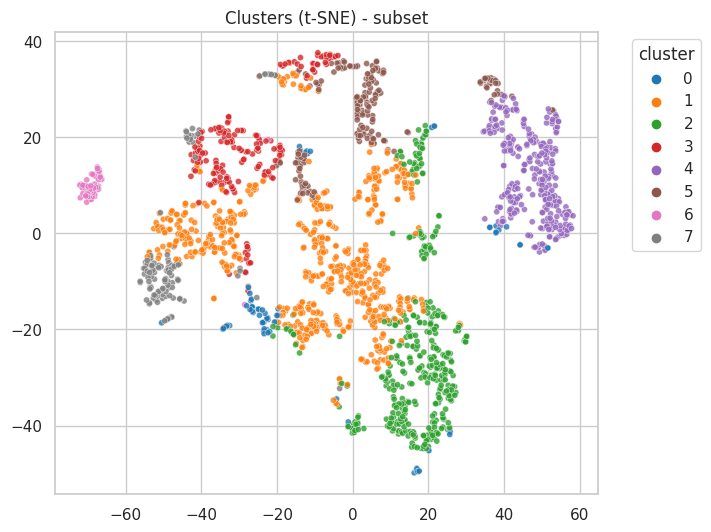

In [15]:
# Célula 2 - Kernel-clustering: KPCA (RBF) -> KMeans (cluster in KPCA space), centroids in original activation space
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Parâmetros (ajuste conforme necessidade)
N_CLUSTERS = 8           # número de conceitos desejados
KPCA_COMPONENTS = 64     # dimensão do espaço kernel onde aplicamos kmeans
USE_MINIBATCH = True
TSNE_SUBSAMPLE = 2000    # para plot t-SNE (None -> usar tudo; cuidado com memória)

X_emb = train_emb_flat   # embeddings no espaço original (2D)
print("Using embeddings shape:", X_emb.shape)

# 1) KPCA (RBF)
print("Fitting KernelPCA (RBF) -> components:", KPCA_COMPONENTS)
kpca = KernelPCA(n_components=KPCA_COMPONENTS, kernel='rbf', n_jobs=-1, random_state=42)
X_kpca = kpca.fit_transform(X_emb)
print("KPCA transformed shape:", X_kpca.shape)

# 2) KMeans (no espaço KPCA)
if USE_MINIBATCH:
    print("Using MiniBatchKMeans for efficiency.")
    km = MiniBatchKMeans(n_clusters=N_CLUSTERS, random_state=42, batch_size=1024)
else:
    km = KMeans(n_clusters=N_CLUSTERS, random_state=42)
km.fit(X_kpca)
labels_k = km.labels_
print("KMeans done. Cluster sizes:")
(unique, counts) = np.unique(labels_k, return_counts=True)
for u,c in zip(unique, counts):
    print(f"  cluster {u}: {c} samples")

# 3) compute centroids in original embedding space as mean of member embeddings
centroids_original = []
cluster_member_indices = {}
for k in range(N_CLUSTERS):
    idxs = np.where(labels_k == k)[0]
    cluster_member_indices[k] = idxs
    if len(idxs) == 0:
        centroids_original.append(np.zeros((X_emb.shape[1],), dtype=float))
    else:
        centroids_original.append(np.mean(X_emb[idxs], axis=0))
centroids_original = np.vstack(centroids_original)
print("Centroids in original embedding space shape:", centroids_original.shape)

# 4) Visualização (t-SNE or PCA)
def plot_clusters_2d(emb2d, labels, title="Clusters (2D)", subsample_n=None):
    if subsample_n is not None and emb2d.shape[0] > subsample_n:
        idx = np.random.RandomState(42).choice(emb2d.shape[0], subsample_n, replace=False)
        emb_plot = emb2d[idx]
        labels_plot = labels[idx]
    else:
        emb_plot = emb2d
        labels_plot = labels
    plt.figure(figsize=(7,6))
    sns.scatterplot(x=emb_plot[:,0], y=emb_plot[:,1], hue=labels_plot, palette="tab10", s=20, alpha=0.8)
    plt.title(title)
    plt.legend(title="cluster", bbox_to_anchor=(1.05,1))
    plt.show()

# Use t-SNE for visualization (slower) on subset
subset = min(TSNE_SUBSAMPLE or X_emb.shape[0], X_emb.shape[0])
print("Computing t-SNE on subset:", subset)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=800, init='pca')
emb_tsne = tsne.fit_transform(X_emb[:subset])
plot_clusters_2d(emb_tsne, labels_k[:subset], title="Clusters (t-SNE) - subset")

# salvar variáveis
globals().update({
    "kpca": kpca,
    "kmeans_kpca": km,
    "cluster_labels_train": labels_k,
    "cluster_member_indices": cluster_member_indices,
    "centroids_original": centroids_original
})

In [16]:
# Parâmetros
PURE_QUANTILE = 0.25
NEGATIVE_MULT = 5
MIN_PURE = 10

A = train_emb_flat  # (n_samples, emb_dim)
n = A.shape[0]
cav_dict_activ = {}

for k in range(N_CLUSTERS):
    idxs = cluster_member_indices.get(k, np.array([], dtype=int))
    if idxs.size == 0:
        continue
    cent = centroids_original[k]
    dists = np.linalg.norm(A[idxs] - cent.reshape(1,-1), axis=1)
    if len(dists) == 0:
        continue
    cutoff = np.quantile(dists, PURE_QUANTILE)
    idx_pure = idxs[dists <= cutoff]
    size_pure = len(idx_pure)
    if size_pure < MIN_PURE:
        continue
    neg_pool = np.setdiff1d(np.arange(n), idx_pure)
    neg_n = min(max(200, size_pure * NEGATIVE_MULT), len(neg_pool))
    if neg_n <= 0:
        continue
    neg_idx = np.random.choice(neg_pool, neg_n, replace=False)
    Xc = np.vstack([A[idx_pure], A[neg_idx]])
    yc = np.hstack([np.ones(len(idx_pure), dtype=int), np.zeros(len(neg_idx), dtype=int)])
    clf = LogisticRegression(C=0.1, solver="liblinear", max_iter=2000, random_state=42)
    clf.fit(Xc, yc)
    w = clf.coef_.ravel()
    nrm = np.linalg.norm(w)
    if nrm == 0:
        continue
    v_activ = (w / nrm).astype(np.float32)
    cav_dict_activ[int(k)] = {
        "component": int(k),
        "size_pure": int(size_pure),
        "pure_idx": idx_pure,
        "neg_idx": neg_idx,
        "clf": clf,
        "v_activ": v_activ
    }
print(f"Total CAVs trained: {len(cav_dict_activ)}")
globals().update({"cav_dict_activ": cav_dict_activ})

Total CAVs trained: 8


In [18]:
# Célula 4 - Treinar surrogate embeddings -> p0 (corrigida e mais robusta)
import numpy as np
import torch
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# 1) calcular p0_train (prob. do modelo) em batch (usando X_train_df / dist)
def batch_predict_proba_model(model, X_all_np, years_arr, year_to_domain_map, batch_size=512):
    """
    Robust batch predict_proba that tries several call patterns and returns
    the positive class probability (if predict_proba returns 2D array).
    """
    n = X_all_np.shape[0]
    probs_list = []
    for s in range(0, n, batch_size):
        e = min(s + batch_size, n)
        Xb = X_all_np[s:e].astype(np.float32)
        yrs = years_arr[s:e]
        dist_dom_np = np.array([year_to_domain_map[int(y)] for y in yrs], dtype=np.int64)

        # build dist tensor robustly
        try:
            dist_dom_t = make_dist_tensor(dist_dom_np, device=model_add_x_device, target_shape_example=example_add_shape)
        except Exception:
            # fallback: cpu tensor reshaped (common shape: (n,1,1))
            dist_dom_t = torch.tensor(dist_dom_np, dtype=torch.long, device=torch.device("cpu"))
            if dist_dom_t.ndim == 1:
                try:
                    dist_dom_t = dist_dom_t.reshape(-1,1,1)
                except Exception:
                    dist_dom_t = dist_dom_t.reshape(-1,1)

        probs_b = None
        err_msgs = []
        # Try 1: numpy X + additional_x as tensor/numpy (fast path if model accepts numpy)
        try:
            probs_b = model.predict_proba(Xb, additional_x={"dist_shift_domain": dist_dom_t})
        except Exception as ex1:
            err_msgs.append(f"np+tensor failed: {ex1}")
            # Try 2: torch X tensor on model_add_x_device
            try:
                dev = model_add_x_device if 'model_add_x_device' in globals() else torch.device("cpu")
                Xb_t = torch.tensor(Xb, dtype=torch.float32, device=dev)
                with torch.no_grad():
                    probs_b = model.predict_proba(Xb_t, additional_x={"dist_shift_domain": dist_dom_t.to(dev) if isinstance(dist_dom_t, torch.Tensor) else dist_dom_t})
            except Exception as ex2:
                err_msgs.append(f"torch+tensor failed: {ex2}")
                # Try 3: numpy X + additional_x as plain numpy ints (some implementations accept this)
                try:
                    probs_b = model.predict_proba(Xb, additional_x={"dist_shift_domain": dist_dom_np})
                except Exception as ex3:
                    err_msgs.append(f"np+npdist failed: {ex3}")
                    # Try 4: predict_proba without additional_x (last resort)
                    try:
                        probs_b = model.predict_proba(Xb)
                    except Exception as ex4:
                        err_msgs.append(f"np no-additional failed: {ex4}")
                        # all failed -> raise informative error
                        raise RuntimeError(f"All predict_proba attempts failed for batch {s}:{e}. Errors: {' | '.join(map(str, err_msgs))}")

        # convert torch Tensor -> numpy if needed
        if isinstance(probs_b, torch.Tensor):
            probs_b = probs_b.detach().cpu().numpy()

        probs_arr = np.asarray(probs_b)
        # ensure shape is (batch, n_classes) or (batch,)
        if probs_arr.ndim == 1:
            # could be (batch,) -> ok
            pass
        elif probs_arr.ndim == 2:
            # ok
            pass
        else:
            # flatten to 2D if possible
            probs_arr = probs_arr.reshape(probs_arr.shape[0], -1)

        probs_list.append(probs_arr)

    # concatenate batches robustly
    # Some batches maybe 1D arrays; convert all to 2D where necessary
    # First determine if any batch has 2D shape with second dim >1
    any_2d = any((p.ndim == 2 and p.shape[1] > 1) for p in probs_list)
    if any_2d:
        # convert 1D batches to (batch,1)
        probs_concat = np.vstack([p if p.ndim==2 else p.reshape(-1,1) for p in probs_list])
    else:
        # all 1D or single-column -> flatten to 1D
        probs_concat = np.concatenate([p.ravel() for p in probs_list], axis=0)

    # return positive class probs when multiclass array
    if isinstance(probs_concat, np.ndarray) and probs_concat.ndim == 2 and probs_concat.shape[1] > 1:
        return probs_concat[:,1]
    return probs_concat.ravel()

# Execute
print("Computing p0_train (model probabilities) on train set...")
p0_train = batch_predict_proba_model(drift_model, X_train_np_norm, years_train, year_to_domain_combined, batch_size=512)
print("p0_train shape:", p0_train.shape)

# 2) Treinar surrogate (Ridge)
X_emb_train = train_emb_flat
# opcional subsample para treinar rápido
SUBS = None  # or int e.g. 5000
if SUBS is not None and X_emb_train.shape[0] > SUBS:
    sel = np.random.RandomState(42).choice(X_emb_train.shape[0], SUBS, replace=False)
    X_emb_for_fit = X_emb_train[sel]
    p0_for_fit = p0_train[sel]
else:
    X_emb_for_fit = X_emb_train
    p0_for_fit = p0_train

# Sanity check: lengths must match
if X_emb_for_fit.shape[0] != p0_for_fit.shape[0]:
    raise RuntimeError(f"Mismatch shapes: X_emb_for_fit {X_emb_for_fit.shape[0]} vs p0_for_fit {p0_for_fit.shape[0]}. Verify alignment between embeddings and p0 arrays.")

print("Training surrogate Ridge mapping embeddings -> p0")
surrogate = Ridge(alpha=1.0)
surrogate.fit(X_emb_for_fit, p0_for_fit)
pred_train_sur = surrogate.predict(X_emb_for_fit)
print("Surrogate fit R2:", r2_score(p0_for_fit, pred_train_sur), "MSE:", mean_squared_error(p0_for_fit, pred_train_sur))

# salvar surrogate
globals().update({"surrogate_emb_to_p0": surrogate, "p0_train": p0_train})

Computing p0_train (model probabilities) on train set...
p0_train shape: (7429,)
Training surrogate Ridge mapping embeddings -> p0
Surrogate fit R2: 0.999703109963724 MSE: 2.5705434433769597e-07


Cluster 0: tcav_prop=1.000 mean_deriv=3.9364e-03 alpha=5.5239e-03
Cluster 1: tcav_prop=0.000 mean_deriv=-5.6742e-02 alpha=6.0873e-03
Cluster 2: tcav_prop=1.000 mean_deriv=2.0058e-02 alpha=5.5630e-03
Cluster 3: tcav_prop=0.000 mean_deriv=-5.1070e-02 alpha=4.5639e-03
Cluster 4: tcav_prop=1.000 mean_deriv=3.3717e-02 alpha=3.2034e-03
Cluster 5: tcav_prop=0.000 mean_deriv=-7.4855e-03 alpha=6.0731e-03
Cluster 6: tcav_prop=0.000 mean_deriv=-1.1281e-02 alpha=3.8565e-03
Cluster 7: tcav_prop=1.000 mean_deriv=1.7268e-02 alpha=5.1315e-03


,cluster,tcav_prop_positive,mean_derivative,alpha_used,size_pure
0,0,1.0,0.003936,0.005524,230
1,2,1.0,0.020058,0.005563,468
2,4,1.0,0.033717,0.003203,288
3,7,1.0,0.017268,0.005132,212
4,1,0.0,-0.056742,0.006087,325
5,3,0.0,-0.051070,0.004564,196
6,5,0.0,-0.007486,0.006073,82
7,6,0.0,-0.011281,0.003857,64


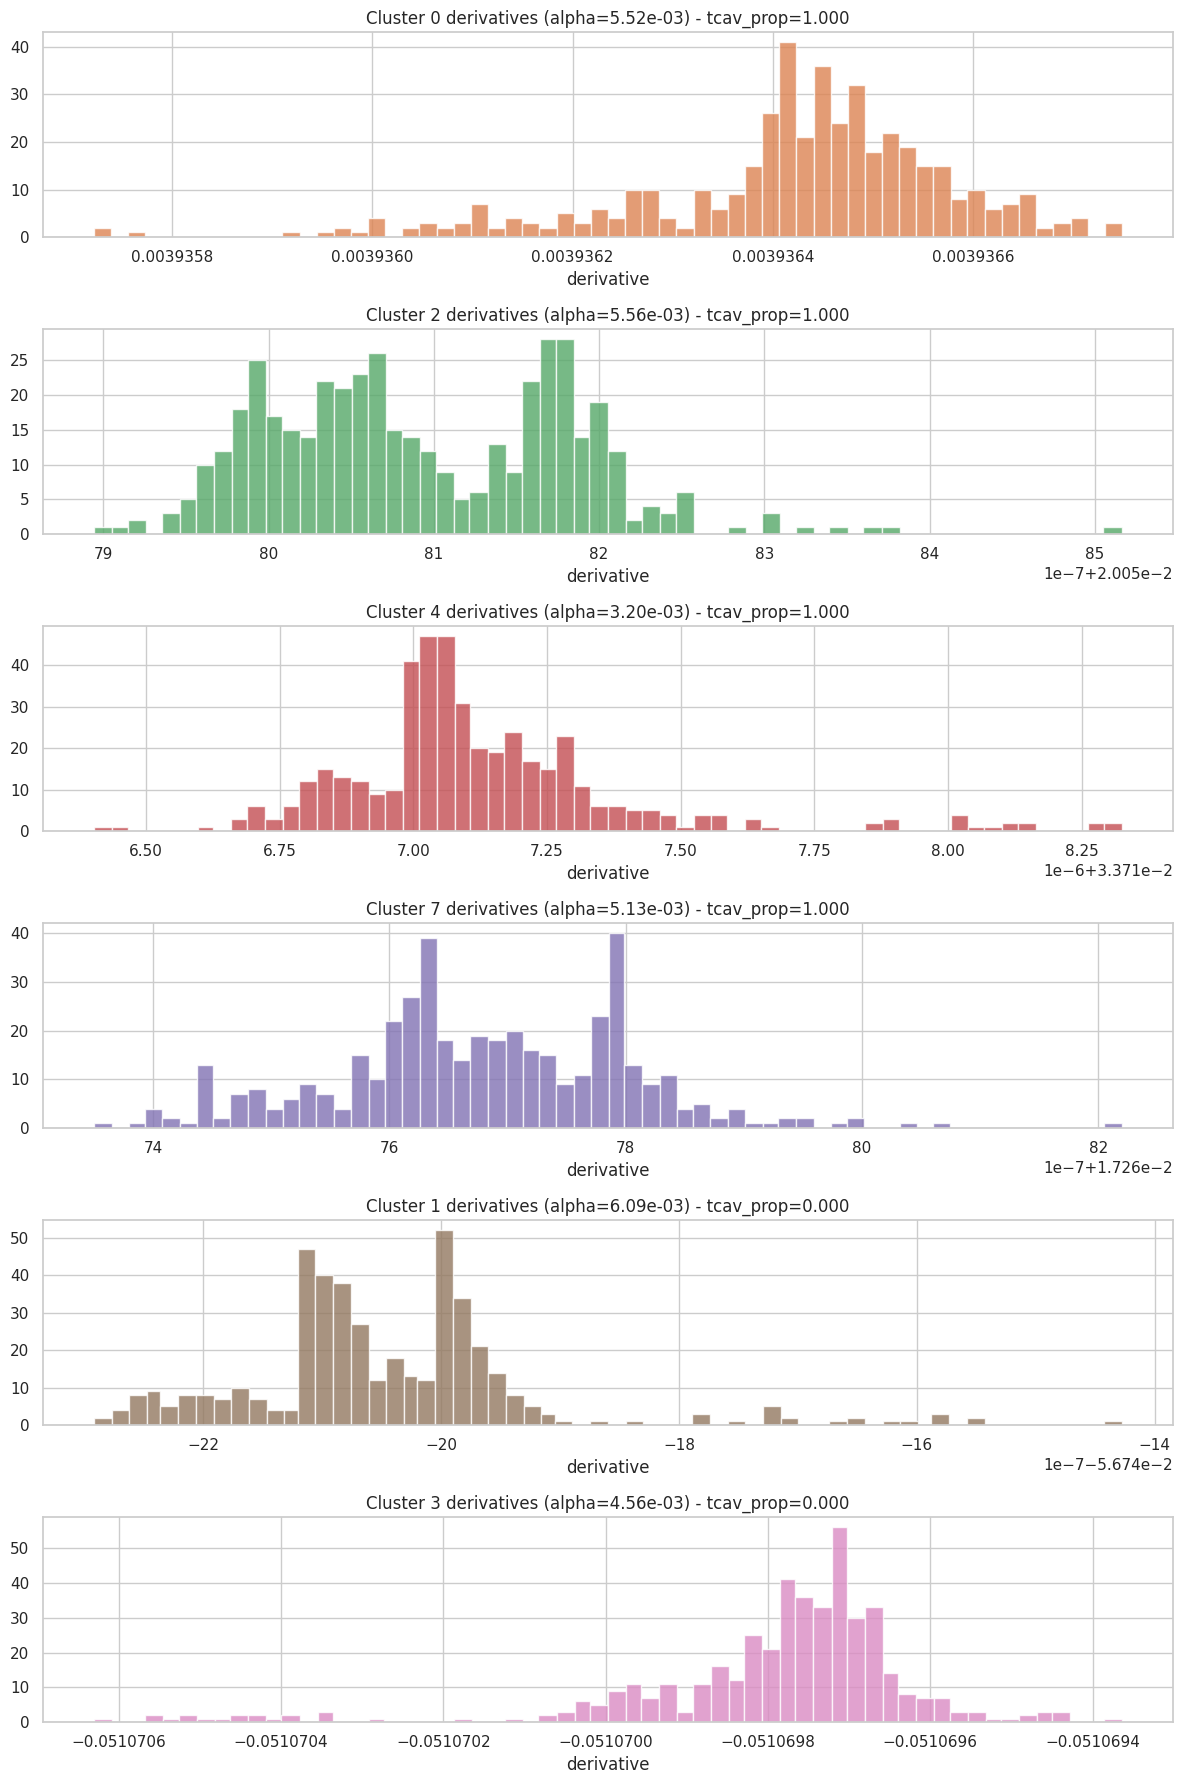

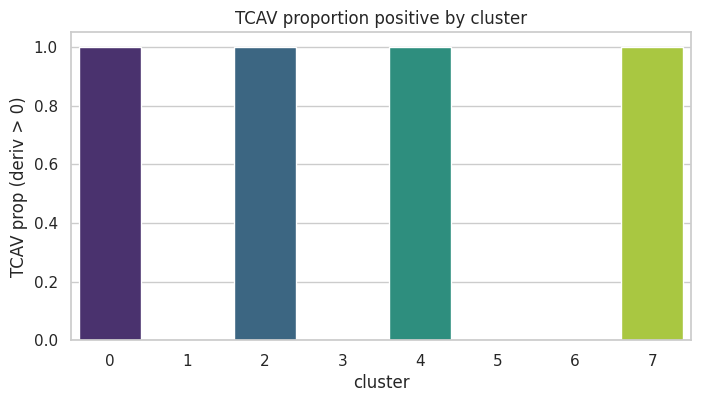

In [19]:
# Célula 5 - Calcular TCAV (finite-difference) usando surrogate
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Parâmetros
FINITE_REL = 0.05
EVAL_ON = "test"   # "test" or "train"
BATCH = 1024

X_eval_emb = test_emb_flat if EVAL_ON == "test" else train_emb_flat
n_eval = X_eval_emb.shape[0]

tcav_results = {}
for k, entry in cav_dict_activ.items():
    v = entry["v_activ"].astype(np.float32)  # direction
    # projection on evaluation set
    proj = X_eval_emb.dot(v)
    proj_std = float(np.std(proj))
    alpha = FINITE_REL * proj_std if proj_std > 0 else FINITE_REL
    # compute in batches to avoid memory blowup
    deriv_all = np.zeros(n_eval, dtype=np.float32)
    for s in range(0, n_eval, BATCH):
        e = min(s+BATCH, n_eval)
        emb_batch = X_eval_emb[s:e]
        emb_plus = emb_batch + alpha * v[np.newaxis, :]
        emb_minus = emb_batch - alpha * v[np.newaxis, :]
        p_plus = surrogate_emb_to_p0.predict(emb_plus)
        p_minus = surrogate_emb_to_p0.predict(emb_minus)
        deriv = (p_plus - p_minus) / (2.0 * alpha)
        deriv_all[s:e] = deriv.astype(np.float32)
    tcav_prop = float(np.mean(deriv_all > 0.0))
    mean_deriv = float(np.nanmean(deriv_all))
    tcav_results[int(k)] = {
        "cluster": int(k),
        "tcav_prop_positive": tcav_prop,
        "mean_derivative": mean_deriv,
        "alpha_used": float(alpha),
        "derivatives": deriv_all  # cuidado: pode ser grande
    }
    print(f"Cluster {k}: tcav_prop={tcav_prop:.3f} mean_deriv={mean_deriv:.4e} alpha={alpha:.4e}")

# Mostrar sumário ordenado por tcav_prop
import pandas as pd
df_tcav = pd.DataFrame([
    {"cluster": v["cluster"], "tcav_prop_positive": v["tcav_prop_positive"], "mean_derivative": v["mean_derivative"], "alpha_used": v["alpha_used"], "size_pure": cav_dict_activ[v["cluster"]]["size_pure"]}
    for v in tcav_results.values()
]).sort_values("tcav_prop_positive", ascending=False).reset_index(drop=True)
display(df_tcav)

# Plots: histogram of derivatives for top concepts
TOP_K = min(6, len(df_tcav))
top_clusters = df_tcav['cluster'].iloc[:TOP_K].tolist()
plt.figure(figsize=(12, 3*TOP_K))
for i, c in enumerate(top_clusters, 1):
    plt.subplot(TOP_K, 1, i)
    deriv = tcav_results[int(c)]["derivatives"]
    plt.hist(deriv, bins=60, color='C'+str(i%10), alpha=0.8)
    plt.title(f"Cluster {c} derivatives (alpha={tcav_results[int(c)]['alpha_used']:.2e}) - tcav_prop={tcav_results[int(c)]['tcav_prop_positive']:.3f}")
    plt.xlabel("derivative")
plt.tight_layout()
plt.show()

# Boxplot TCAV by cluster
plt.figure(figsize=(8,4))
sns.barplot(data=df_tcav, x='cluster', y='tcav_prop_positive', palette='viridis')
plt.title("TCAV proportion positive by cluster")
plt.ylabel("TCAV prop (deriv > 0)")
plt.xlabel("cluster")
plt.show()

In [20]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

# Parâmetros
SURROGATE_SUBSAMPLE = 3000
RIDGE_ALPHA = 1.0
MIN_R2_ACCEPT = 0.02  # só considera surrogate bom acima disso

# subsample para acelerar se n for grande
n = train_emb_flat.shape[0]
sel = np.random.RandomState(42).choice(n, min(SURROGATE_SUBSAMPLE, n), replace=False)
Xc = train_emb_flat[sel]
y_c = p0_train[sel]

# split (holdout 20%)
perm = np.random.RandomState(42).permutation(len(sel))
split = int(0.8 * len(perm))
tr = perm[:split]; val = perm[split:]
Xtr = Xc[tr]; ytr = y_c[tr]; Xval = Xc[val]; yval = y_c[val]
scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr); Xval_s = scaler.transform(Xval)

ridge = Ridge(alpha=RIDGE_ALPHA)
ridge.fit(Xtr_s, ytr)
r2 = r2_score(yval, ridge.predict(Xval_s))
print(f"Surrogate Ridge holdout R2: {r2:.4f}")
if r2 < MIN_R2_ACCEPT:
    raise RuntimeError("Surrogate R2 too low: aborting pipeline. (Ajuste features ou verifique modelo principal.)")

globals().update({"surrogate_emb_to_p0": ridge, "surrogate_scaler": scaler})

Surrogate Ridge holdout R2: 0.9999


In [21]:
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# usar o MESMO sel
Xs = train_emb_flat[sel]
y_perm = shuffle(p0_train[sel], random_state=0)

scaler = StandardScaler().fit(Xs)
Xs_s = scaler.transform(Xs)

r = Ridge(alpha=RIDGE_ALPHA).fit(Xs_s, y_perm)
r2_perm = r2_score(y_perm, r.predict(Xs_s))

print("R2 with permuted targets:", r2_perm)


R2 with permuted targets: 0.05396310059022935


In [22]:
# reutiliza split original
y_perm_tr = shuffle(ytr, random_state=0)
y_perm_val = shuffle(yval, random_state=1)

r_perm = Ridge(alpha=RIDGE_ALPHA)
r_perm.fit(Xtr_s, y_perm_tr)

r2_perm_val = r2_score(y_perm_val, r_perm.predict(Xval_s))
print("Permutation R2 (val):", r2_perm_val)


Permutation R2 (val): -0.05064581637053012


In [23]:
# ruído pequeno (1% do desvio padrão)
noise_std = 0.01 * Xtr.std(axis=0, keepdims=True)

noise = np.random.normal(0, noise_std, size=Xval.shape)
Xval_noisy = Xval + noise

Xval_noisy_s = scaler.transform(Xval_noisy)

r2_clean = r2_score(yval, ridge.predict(Xval_s))
r2_noise = r2_score(yval, ridge.predict(Xval_noisy_s))

print("R2 clean:", r2_clean)
print("R2 with small noise:", r2_noise)
print("ΔR2:", r2_clean - r2_noise)


R2 clean: 0.9998841716851317
R2 with small noise: 0.9998100929504306
ΔR2: 7.40787347011107e-05


In [24]:
eps = 0.01  # 1%
noise = np.random.normal(
    0,
    eps,
    size=Xval.shape
) * Xval.std(axis=0, keepdims=True)

Xval_noisy = Xval + noise
Xval_noisy_s = scaler.transform(Xval_noisy)

r2_noise = r2_score(yval, ridge.predict(Xval_noisy_s))
print("R2 with scale-aware noise:", r2_noise)


R2 with scale-aware noise: 0.9998284784493989


In [25]:
X_ab = test_emb.copy()
v = cavs_embed[0]['v']
X_ab -= X_ab.dot(v)[:,None] * v[None,:]

r2_ab = r2_score(p0_test, best.predict(scaler.transform(X_ab)))
print("R2 after concept ablation:", r2_ab)


NameError: name 'cavs_embed' is not defined

In [26]:
# Parâmetros
FINITE_REL = 0.05
BATCH = 1024
tcav_results = {}

X_eval_emb = test_emb_flat
n_eval = X_eval_emb.shape[0]

for k, entry in cav_dict_activ.items():
    v = entry["v_activ"].astype(np.float32)
    proj = X_eval_emb.dot(v)
    proj_std = float(np.std(proj))
    alpha = FINITE_REL * proj_std if proj_std > 0 else FINITE_REL
    deriv_all = np.zeros(n_eval, dtype=np.float32)
    for s in range(0, n_eval, BATCH):
        e = min(s+BATCH, n_eval)
        emb_plus = X_eval_emb[s:e] + alpha * v[np.newaxis, :]
        emb_minus = X_eval_emb[s:e] - alpha * v[np.newaxis, :]
        # use escala se necessário:
        emb_plus_s = surrogate_scaler.transform(emb_plus)
        emb_minus_s = surrogate_scaler.transform(emb_minus)
        p_plus = surrogate_emb_to_p0.predict(emb_plus_s)
        p_minus = surrogate_emb_to_p0.predict(emb_minus_s)
        deriv = (p_plus - p_minus) / (2.0 * alpha)
        deriv_all[s:e] = deriv.astype(np.float32)
    tcav_prop = float(np.mean(deriv_all > 0.0))
    mean_deriv = float(np.nanmean(deriv_all))
    tcav_results[int(k)] = {
        "cluster": int(k),
        "tcav_prop_positive": tcav_prop,
        "mean_derivative": mean_deriv,
        "alpha_used": float(alpha),
        "derivatives": deriv_all
    }
    print(f"Cluster {k}: tcav_prop={tcav_prop:.3f}, mean_deriv={mean_deriv:.4e}, alpha={alpha:.4e}")

globals().update({"tcav_results": tcav_results})

Cluster 0: tcav_prop=1.000, mean_deriv=5.5140e-03, alpha=5.5239e-03
Cluster 1: tcav_prop=0.000, mean_deriv=-5.6252e-02, alpha=6.0873e-03
Cluster 2: tcav_prop=1.000, mean_deriv=2.1104e-02, alpha=5.5630e-03
Cluster 3: tcav_prop=0.000, mean_deriv=-4.9510e-02, alpha=4.5639e-03
Cluster 4: tcav_prop=1.000, mean_deriv=3.4512e-02, alpha=3.2034e-03
Cluster 5: tcav_prop=0.000, mean_deriv=-6.8110e-03, alpha=6.0731e-03
Cluster 6: tcav_prop=0.000, mean_deriv=-1.0969e-02, alpha=3.8565e-03
Cluster 7: tcav_prop=1.000, mean_deriv=1.8376e-02, alpha=5.1315e-03


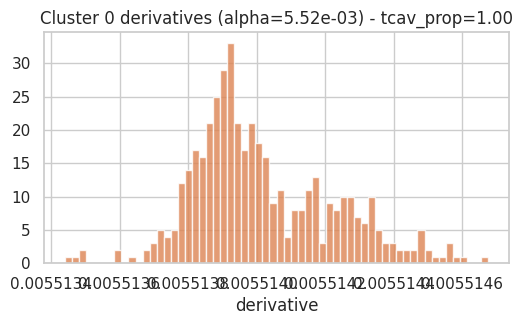

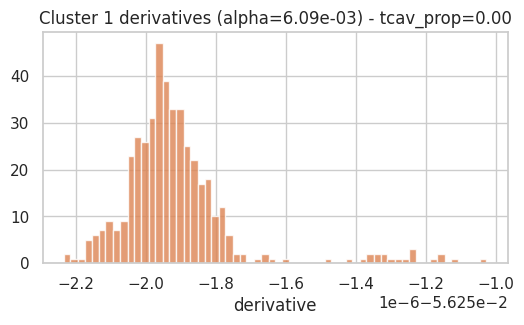

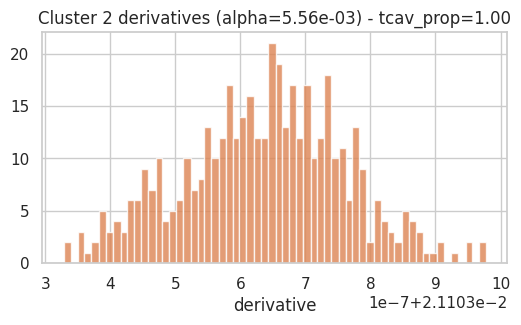

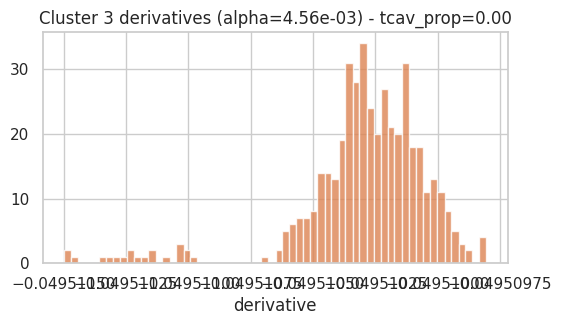

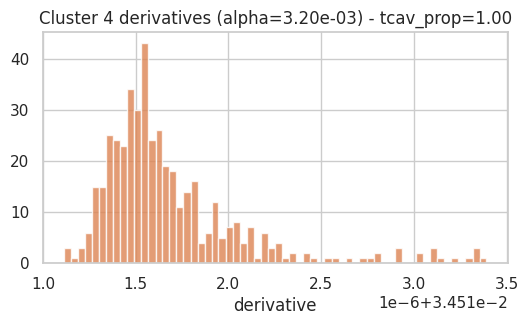

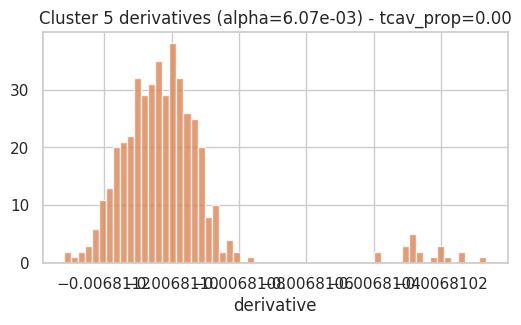

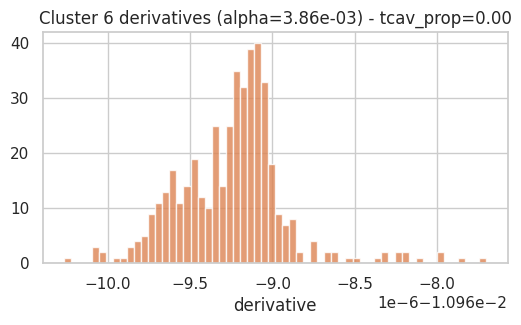

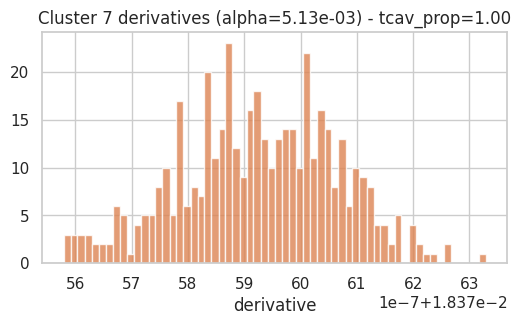

,cluster,tcav_prop_positive,mean_derivative,alpha_used
0,0,1.0,0.005514,0.005524
1,2,1.0,0.021104,0.005563
2,4,1.0,0.034512,0.003203
3,7,1.0,0.018376,0.005132
4,1,0.0,-0.056252,0.006087
5,3,0.0,-0.049510,0.004564
6,5,0.0,-0.006811,0.006073
7,6,0.0,-0.010969,0.003857


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

TOP_K = 6
for k, res in tcav_results.items():
    deriv = res["derivatives"]
    plt.figure(figsize=(6,3))
    plt.hist(deriv, bins=60, color='C1', alpha=0.8)
    plt.title(f"Cluster {k} derivatives (alpha={res['alpha_used']:.2e}) - tcav_prop={res['tcav_prop_positive']:.2f}")
    plt.xlabel("derivative")
    plt.show()
# Tabela resumo
df_tcav = pd.DataFrame([
    {"cluster": v["cluster"], "tcav_prop_positive": v["tcav_prop_positive"], "mean_derivative": v["mean_derivative"], "alpha_used": v["alpha_used"]}
    for v in tcav_results.values()
]).sort_values("tcav_prop_positive", ascending=False).reset_index(drop=True)
display(df_tcav)

In [28]:
# Célula A - Detectar módulos candidatas e testar forward hooks (micro-run)
import torch
import numpy as np
from pprint import pprint

# Requisitos: drift_model ou model_obj no namespace
model_top = globals().get("model_obj", globals().get("drift_model"))
if model_top is None:
    raise RuntimeError("drift_model / model_obj não encontrado no namespace. Rode o treino primeiro.")

model_proc = getattr(model_top, "model_processed_", None) or model_top

# Candidate attribute names heuristics
candidates = []
# listar atributos públicos do model_proc
for name in dir(model_proc):
    if name.startswith("_"):
        continue
    try:
        attr = getattr(model_proc, name)
        # aceitar módulos torch.nn.Module e ModuleList, etc.
        if hasattr(attr, "__class__") and ("torch" in str(attr.__class__) or "Module" in str(type(attr))):
            candidates.append(name)
    except Exception:
        continue

# Adicionar nomes comuns presentes em alguns modelos
common_candidates = ["encoder","y_encoder","transformer_encoder","feature_positional_embedding_embeddings","encoder_layers","embed_layer","encoder_block","mlp_head"]
for c in common_candidates:
    if hasattr(model_proc, c) and c not in candidates:
        candidates.append(c)

print("Candidate attributes to attempt hooking (sample):", candidates[:40])

# Utility to attempt hook and run a micro-batch
def probe_module_output(name):
    try:
        mod = getattr(model_proc, name)
    except Exception as e:
        return None, f"attr_not_found: {e}"
    results = {}
    h = None
    def hook_fn(module, inp, out):
        # record first tensor-like found
        t = None
        if isinstance(out, torch.Tensor):
            t = out
        elif isinstance(out, (list, tuple)):
            for x in out:
                if isinstance(x, torch.Tensor):
                    t = x; break
        elif isinstance(out, dict):
            for x in out.values():
                if isinstance(x, torch.Tensor):
                    t = x; break
        if t is not None:
            results['shape'] = tuple(t.detach().cpu().shape)
            results['dtype'] = str(t.detach().cpu().dtype)
    try:
        h = mod.register_forward_hook(hook_fn)
    except Exception as e:
        return None, f"failed_register_hook: {e}"

    # build micro-batch: take first min(4) from X_train_np_norm (fallback to X_train_np)
    X_src = globals().get("X_train_np_norm", globals().get("X_train_np", None))
    if X_src is None:
        try:
            # try X_train_df
            X_src = np.asarray(globals()["X_train_df"].values).astype(np.float32)
        except Exception:
            X_src = None
    if X_src is None or X_src.shape[0] == 0:
        if h is not None:
            h.remove()
        return None, "no_X_available"
    B = min(4, X_src.shape[0])
    Xb = X_src[:B].astype(np.float32)
    yrs = globals().get("years_train", None)
    yrs_b = yrs[:B] if yrs is not None else None

    # Build additional_x if available
    addx = None
    if hasattr(model_top, "additional_x_") and getattr(model_top, "additional_x_", None) is not None:
        try:
            # build dist array for B
            if yrs_b is not None:
                dom = np.array([year_to_domain_combined[int(y)] for y in yrs_b], dtype=np.int64)
                # attempt to match shape by inspecting additional_x_
                example = model_top.additional_x_.get("dist_shift_domain", None)
                if example is None:
                    addx = {"dist_shift_domain": dom}
                else:
                    ex_arr = example.detach().cpu().numpy() if hasattr(example, "detach") else np.asarray(example)
                    if ex_arr.ndim == 1:
                        addx = {"dist_shift_domain": dom}
                    elif ex_arr.ndim == 2:
                        addx = {"dist_shift_domain": np.tile(dom.reshape(-1,1),(1,ex_arr.shape[1]))}
                    elif ex_arr.ndim == 3:
                        addx = {"dist_shift_domain": np.tile(dom.reshape(-1,1,1),(1,ex_arr.shape[1],ex_arr.shape[2]))}
                    else:
                        addx = {"dist_shift_domain": dom}
        except Exception:
            addx = None

    # Try to call predict_proba with numpy/batched path
    try:
        if addx is not None:
            _ = model_top.predict_proba(Xb, additional_x=addx)
        else:
            _ = model_top.predict_proba(Xb)
    except Exception:
        # try torch path
        try:
            dev = None
            try:
                for p in model_top.parameters():
                    dev = p.device; break
            except Exception:
                dev = None
            if dev is None:
                dev = torch.device("cpu")
            Xb_t = torch.tensor(Xb, dtype=torch.float32, device=dev)
            if addx is not None:
                addx_t = {}
                for k,v in addx.items():
                    try:
                        addx_t[k] = torch.tensor(v, dtype=torch.long if np.asarray(v).dtype.kind in ('i',) else torch.float32, device=dev)
                    except Exception:
                        addx_t[k] = torch.tensor(np.asarray(v), device=dev)
                _ = model_top.predict_proba(Xb_t, additional_x=addx_t)
            else:
                _ = model_top.predict_proba(Xb_t)
        except Exception as e:
            if h is not None:
                h.remove()
            return None, f"predict_proba_failed: {e}"

    # remove hook
    if h is not None:
        h.remove()
    return results.get('shape', None), None

# Probe candidates
modules_probe_info = {}
for name in candidates:
    try:
        shape, err = probe_module_output(name)
        modules_probe_info[name] = {"shape": shape, "error": err}
    except Exception as e:
        modules_probe_info[name] = {"shape": None, "error": str(e)}

print("Probe results (sample):")
pprint({k:v for k,v in modules_probe_info.items() if v['shape'] is not None} )
# Suggest modules where shape last-dim likely matches embedding dim (if known)
suggested = []
target_dim = globals().get("train_emb_flat", np.zeros((1,192))).shape[1]
for name, info in modules_probe_info.items():
    shp = info['shape']
    if shp is None:
        continue
    if len(shp) >= 1 and shp[-1] == int(target_dim):
        suggested.append((name, shp))
print("\nSuggested modules (last-dim == embedding dim):", suggested)
# Expor lista completa para uso
globals().update({"modules_probe_info": modules_probe_info, "modules_candidate_list": candidates, "modules_suggested": suggested})

Candidate attributes to attempt hooking (sample): ['criterion', 'decoder_dict', 'feature_positional_embedding_embeddings', 'generator_device', 'encoder', 'y_encoder', 'transformer_encoder']
Probe results (sample):
{'encoder': {'error': None, 'shape': (7433, 22, 192)},
 'feature_positional_embedding_embeddings': {'error': None, 'shape': (22, 192)},
 'transformer_encoder': {'error': None, 'shape': (1, 7433, 23, 192)},
 'y_encoder': {'error': None, 'shape': (7433, 1, 192)}}

Suggested modules (last-dim == embedding dim): [('feature_positional_embedding_embeddings', (22, 192)), ('encoder', (7433, 22, 192)), ('y_encoder', (7433, 1, 192)), ('transformer_encoder', (1, 7433, 23, 192))]


In [29]:
# Célula B3 (corrigida) - Extração segura e streaming para disco (após restart do kernel)
import os
import numpy as np
import torch
from tqdm import tqdm
from pathlib import Path

# Parâmetros seguros / ajustáveis
SAFE_BATCH_SIZE = 32         # muito menor para reduzir memória por batch
MAX_DIM_ALLOWED = 20000      # se a dimensão por amostra (após pooling) > isso -> pular módulo
OUT_DIR = Path.cwd() / "activations_stream"
OUT_DIR.mkdir(exist_ok=True)
SUBSAMPLE_N = None           # set to int to process only N samples (útil para prototipagem), else None -> all
MODULES_EXCLUDE = {"encoder"}  # módulos problemáticos que queremos pular por padrão

# Verificar variáveis essenciais no ambiente
if 'model_proc' not in globals() and 'drift_model' in globals():
    model_proc = getattr(globals()['drift_model'], 'model_processed_', getattr(globals()['drift_model'], None))
if 'model_top' not in globals() and 'drift_model' in globals():
    model_top = globals()['drift_model']

X_src = globals().get("X_train_np_norm", globals().get("X_train_np", None))
years_src = globals().get("years_train", None)
if X_src is None or years_src is None:
    raise RuntimeError("X_train_np_norm / years_train não encontrados. Recrie as variáveis de preparação primeiro.")

n_total = X_src.shape[0]
# subsample if requested
if SUBSAMPLE_N is not None and SUBSAMPLE_N < n_total:
    rng = np.random.RandomState(42)
    sel_idx = rng.choice(n_total, SUBSAMPLE_N, replace=False)
    X_proc = X_src[sel_idx]
    years_proc = np.array(years_src)[sel_idx]
    idx_map = sel_idx
    n = SUBSAMPLE_N
else:
    X_proc = X_src
    years_proc = years_src
    idx_map = np.arange(n_total)
    n = n_total

# build expected batch sizes list
expected_Bs = [min(SAFE_BATCH_SIZE, n - i) for i in range(0, n, SAFE_BATCH_SIZE)]
n_batches_expected = len(expected_Bs)

# candidate modules: prefer modules_suggested (if available) else list public attrs of model_proc
candidates = []
if 'modules_suggested' in globals() and globals()['modules_suggested']:
    candidates = [m for m,_ in globals()['modules_suggested'] if m not in MODULES_EXCLUDE]
else:
    for name in dir(model_proc):
        if name.startswith("_"):
            continue
        if name in MODULES_EXCLUDE:
            continue
        try:
            attr = getattr(model_proc, name)
            # heuristics: pick nn.Module objects
            if hasattr(attr, "__class__") and ("Module" in str(type(attr)) or "torch" in str(attr.__class__)):
                candidates.append(name)
        except Exception:
            continue

print("Candidate modules to attempt (filtered):", candidates)

# helper to compute addx for batch
def build_addx_for_batch(yrs_batch):
    addx = {}
    if hasattr(model_top, "additional_x_") and model_top.additional_x_ is not None and 'dist_shift_domain' in model_top.additional_x_:
        example = model_top.additional_x_['dist_shift_domain']
        try:
            ex_arr = example.detach().cpu().numpy() if hasattr(example, "detach") else np.asarray(example)
        except Exception:
            ex_arr = np.asarray(example)
        dom = np.array([year_to_domain_combined[int(y)] for y in yrs_batch], dtype=np.int64)
        if ex_arr.ndim == 1:
            addx['dist_shift_domain'] = dom
        elif ex_arr.ndim == 2:
            addx['dist_shift_domain'] = np.tile(dom.reshape(-1,1),(1, ex_arr.shape[1]))
        elif ex_arr.ndim == 3:
            addx['dist_shift_domain'] = np.tile(dom.reshape(-1,1,1),(1,ex_arr.shape[1],ex_arr.shape[2]))
        else:
            addx['dist_shift_domain'] = dom
    return (addx if len(addx)>0 else None)

# verifica dimensão por amostra estimada via probe info (se disponível)
module_shapes = globals().get("modules_probe_info", {})
selected_modules = []
for m in candidates:
    info = module_shapes.get(m, {})
    shp = info.get('shape', None)
    if shp is None:
        # sem informação prévia -> adicione e vamos checar dinamicamente
        selected_modules.append(m)
    else:
        # estimativa heurística: se final dim (last axis) > MAX_DIM_ALLOWED -> pular
        last_dim = shp[-1] if len(shp)>0 else None
        if last_dim is None or last_dim <= MAX_DIM_ALLOWED:
            selected_modules.append(m)
        else:
            print(f"Skipping module {m} due to large last-dim estimate ({last_dim} > {MAX_DIM_ALLOWED})")

print("Modules to process after size filter:", selected_modules)

# função de redução: no hook faremos pooling mean sobre seq axis (se detectado), result -> (B, dim)
def reduce_tensor_to_per_sample_tensor(tensor, expected_B):
    # tensor: torch.Tensor on device
    if not isinstance(tensor, torch.Tensor):
        tensor = torch.tensor(tensor)
    # typical: (B, S, D) -> mean dim=1
    if tensor.ndim == 3:
        if tensor.shape[0] == expected_B:
            return tensor.mean(dim=1)  # (B,D)
        if tensor.shape[1] == expected_B:
            return tensor.permute(1,0,2).mean(dim=1)
    # if tensor already (B, D)
    if tensor.ndim == 2 and tensor.shape[0] == expected_B:
        return tensor
    # fallback: flatten and try to match expected_B
    flat = tensor.reshape(tensor.shape[0], -1) if tensor.ndim>=2 else tensor.reshape(1,-1)
    if flat.shape[0] == expected_B:
        return flat
    # try to reshape by total elements
    total = tensor.numel()
    if total % expected_B == 0:
        per = total // expected_B
        return tensor.reshape(expected_B, per)
    # last resort: reduce to (B,1) by averaging per-sample
    if tensor.ndim >=2 and tensor.shape[0] == expected_B:
        return tensor.reshape(expected_B, -1).float().mean(dim=1, keepdim=True)
    # fallback: create small summary features: mean, std
    t_flat = tensor.detach().float().reshape(-1)
    mean = t_flat.mean().unsqueeze(0)
    std = t_flat.std().unsqueeze(0)
    rep = torch.cat([mean, std], dim=0).unsqueeze(0).repeat(expected_B, 1)  # (B,2)
    return rep

# For each module: create memmap and register safe hook that writes per-batch reduced output to memmap
for mod_name in selected_modules:
    mod_obj = getattr(model_proc, mod_name, None)
    if mod_obj is None:
        print("Module not found at runtime (skip):", mod_name)
        continue
    print("Processing module:", mod_name)
    # create memmap file for outputs (float32) with shape (n, target_dim) but we don't know target_dim yet -> we will infer on first batch
    memmap_path = OUT_DIR / f"{mod_name}_activ.dat"
    memmap_meta_path = OUT_DIR / f"{mod_name}_meta.npy"
    # state dict to be mutated inside hook
    state = {"mem": None, "target_dim": None, "write_idx": 0, "memmap_path": str(memmap_path), "meta_path": str(memmap_meta_path)}
    # hook factory writes directly into memmap slice for the current batch
    def make_writer_hook(modname, state_dict):
        def hook(module, inp, out):
            try:
                # find a tensor in out
                t = None
                if isinstance(out, torch.Tensor):
                    t = out
                elif isinstance(out, (list,tuple)):
                    for x in out:
                        if isinstance(x, torch.Tensor):
                            t = x; break
                elif isinstance(out, dict):
                    for x in out.values():
                        if isinstance(x, torch.Tensor):
                            t = x; break
                if t is None:
                    return
                # reduce to (B, dim) on device
                reduced = reduce_tensor_to_per_sample_tensor(t, current_expected_B_local)
                # if target_dim not set, set and create memmap
                if state_dict["target_dim"] is None:
                    state_dict["target_dim"] = int(reduced.shape[1])
                    # create memmap file on disk (w+)
                    state_dict["mem"] = np.memmap(state_dict["memmap_path"], dtype='float32', mode='w+', shape=(n, state_dict["target_dim"]))
                    # save meta
                    np.save(state_dict["meta_path"], np.array([n, state_dict["target_dim"]]))
                    print(f"[{modname}] created memmap {state_dict['memmap_path']} shape={(n,state_dict['target_dim'])}")
                # project to cpu and write into mem at slice [write_idx:write_idx+B, :]
                reduced_cpu = reduced.detach().cpu().numpy().astype(np.float32)
                B_local = reduced_cpu.shape[0]
                if state_dict["write_idx"] + B_local > n:
                    # avoid overflow; trim
                    B_local = max(0, n - state_dict["write_idx"])
                    reduced_cpu = reduced_cpu[:B_local]
                if B_local > 0:
                    mem_local = state_dict["mem"]
                    # pad or trim to target_dim
                    td = state_dict["target_dim"]
                    if reduced_cpu.shape[1] >= td:
                        mem_local[state_dict["write_idx"]:state_dict["write_idx"]+B_local, :] = reduced_cpu[:B_local, :td]
                    else:
                        # pad columns
                        pad_width = td - reduced_cpu.shape[1]
                        pad_arr = np.pad(reduced_cpu, ((0,0),(0,pad_width)), mode='constant')
                        mem_local[state_dict["write_idx"]:state_dict["write_idx"]+B_local, :] = pad_arr
                    mem_local.flush()
                    state_dict["write_idx"] += B_local
            except Exception as e:
                print(f"[{modname}] writer hook error:", e)
        return hook

    # register hook
    try:
        writer_hook = make_writer_hook(mod_name, state)
        h = mod_obj.register_forward_hook(writer_hook)
    except Exception as e:
        print(f"Could not register writer hook for {mod_name}:", e)
        continue

    # run through batches
    current_expected_B_local = None
    for i, start in enumerate(tqdm(range(0, n, SAFE_BATCH_SIZE), desc=f"extract {mod_name}")):
        end = min(start + SAFE_BATCH_SIZE, n)
        B = end - start
        current_expected_B_local = B
        Xb = X_proc[start:end].astype(np.float32)
        yrs_b = years_proc[start:end]
        # call predict_proba robustly (safe call)
        try:
            addx = build_addx_for_batch(yrs_b)
            if addx is not None:
                _ = model_top.predict_proba(Xb, additional_x=addx)
            else:
                _ = model_top.predict_proba(Xb)
        except Exception:
            try:
                dev = model_add_x_device if 'model_add_x_device' in globals() else torch.device("cpu")
                Xb_t = torch.tensor(Xb, dtype=torch.float32, device=dev)
                addx_t = None
                if addx is not None:
                    addx_t = {}
                    for k,v in addx.items():
                        addx_t[k] = torch.tensor(v, dtype=torch.long if np.asarray(v).dtype.kind in ('i',) else torch.float32, device=dev)
                if addx_t is not None:
                    _ = model_top.predict_proba(Xb_t, additional_x=addx_t)
                else:
                    _ = model_top.predict_proba(Xb_t)
            except Exception as e:
                print(f"[{mod_name}] predict_proba failed for batch {i}, skipping batch. err:", e)
                continue

    # remove hook
    try:
        h.remove()
    except Exception:
        pass

    # finalize memmap handle variable in Python (keep file on disk)
    if state.get("mem", None) is not None:
        # delete reference to flush changes
        del state["mem"]

    # Optional: load meta and print
    if (OUT_DIR / f"{mod_name}_activ.dat").exists():
        meta = np.load(str(OUT_DIR / f"{mod_name}_meta.npy"))
        print(f"[{mod_name}] memmap file created: {OUT_DIR / f'{mod_name}_activ.dat'}, meta (n,target_dim)={meta}")
    else:
        print(f"[{mod_name}] No memmap created - maybe hook never produced output.")

print("Safe streaming extraction finished. Memmap files in:", OUT_DIR)

Candidate modules to attempt (filtered): ['feature_positional_embedding_embeddings', 'y_encoder', 'transformer_encoder']
Modules to process after size filter: ['feature_positional_embedding_embeddings', 'y_encoder', 'transformer_encoder']
Processing module: feature_positional_embedding_embeddings


extract feature_positional_embedding_embeddings:   0%|          | 0/233 [00:00<?, ?it/s]

[feature_positional_embedding_embeddings] created memmap /home/ubuntu/cl-is/POC/tcav/activations_stream/feature_positional_embedding_embeddings_activ.dat shape=(7429, 132)


extract feature_positional_embedding_embeddings: 100%|██████████| 233/233 [03:52<00:00,  1.00it/s]


[feature_positional_embedding_embeddings] memmap file created: /home/ubuntu/cl-is/POC/tcav/activations_stream/feature_positional_embedding_embeddings_activ.dat, meta (n,target_dim)=[7429  132]
Processing module: y_encoder


extract y_encoder:   0%|          | 0/233 [00:00<?, ?it/s]

[y_encoder] created memmap /home/ubuntu/cl-is/POC/tcav/activations_stream/y_encoder_activ.dat shape=(7429, 44766)


extract y_encoder: 100%|██████████| 233/233 [03:57<00:00,  1.02s/it]


[y_encoder] memmap file created: /home/ubuntu/cl-is/POC/tcav/activations_stream/y_encoder_activ.dat, meta (n,target_dim)=[ 7429 44766]
Processing module: transformer_encoder


extract transformer_encoder:   0%|          | 0/233 [00:00<?, ?it/s]

[transformer_encoder] created memmap /home/ubuntu/cl-is/POC/tcav/activations_stream/transformer_encoder_activ.dat shape=(7429, 1029618)


extract transformer_encoder: 100%|██████████| 233/233 [05:27<00:00,  1.41s/it]


[transformer_encoder] memmap file created: /home/ubuntu/cl-is/POC/tcav/activations_stream/transformer_encoder_activ.dat, meta (n,target_dim)=[   7429 1029618]
Safe streaming extraction finished. Memmap files in: /home/ubuntu/cl-is/POC/tcav/activations_stream


In [30]:
# Celula 1 - Carregar memmaps de ativações (activations_stream) em module_activations
import os
import numpy as np
from pathlib import Path
import pprint

OUT_DIR = Path.cwd() / "activations_stream"
if not OUT_DIR.exists():
    raise RuntimeError(f"Diretório {OUT_DIR} não encontrado. Execute a célula B3 com sucesso antes.")

# parâmetros de controle
SUBSAMPLE_PER_MODULE = None   # int ou None. Se int -> carrega só N exemplos por módulo (rápido)
RANDOM_SEED = 42
rng = np.random.RandomState(RANDOM_SEED)

module_activations = {}

# procurar arquivos *_activ.dat e *_meta.npy
dat_files = sorted([p for p in OUT_DIR.glob("*_activ.dat")])
if not dat_files:
    # fallback: usar variável module_activations em memória se existir
    if "module_activations" in globals():
        print("Nenhum memmap encontrado mas existe module_activations no ambiente; usando-o.")
        module_activations = globals()["module_activations"]
    else:
        raise RuntimeError(f"Nenhum arquivo *_activ.dat encontrado em {OUT_DIR} e module_activations não existe no namespace.")
else:
    print(f"Found {len(dat_files)} memmap files in {OUT_DIR}. Loading (subsample={SUBSAMPLE_PER_MODULE})...")
    for dat_path in dat_files:
        name = dat_path.name.replace("_activ.dat", "")
        meta_path = dat_path.with_name(f"{name}_meta.npy")
        if not meta_path.exists():
            print(f"Meta missing for {name}, skipping.")
            continue
        meta = np.load(str(meta_path))
        n_meta, dim_meta = int(meta[0]), int(meta[1])
        print(f"Loading module '{name}': memmap shape (n,dim)=({n_meta},{dim_meta})")
        # abrir memmap read-only
        mm = np.memmap(str(dat_path), dtype='float32', mode='r', shape=(n_meta, dim_meta))
        if SUBSAMPLE_PER_MODULE is not None and SUBSAMPLE_PER_MODULE < n_meta:
            sel = rng.choice(n_meta, SUBSAMPLE_PER_MODULE, replace=False)
            arr = np.asarray(mm[sel])
            print(f"  -> subsampled {SUBSAMPLE_PER_MODULE}/{n_meta}")
        else:
            # to avoid huge memory allocations, we only load into memory if size reasonable
            if n_meta * dim_meta <= 200_000_000:  # ~200M elements => ~0.8GB float32 (adjust if you want)
                arr = np.asarray(mm)
            else:
                # keep as memmap to avoid huge allocation, but clustering below expects ndarray.
                # We'll still provide memmap object (numpy.memmap) in dict and clustering cell will handle subsampling.
                arr = mm
                print(f"  -> kept as memmap object (not fully loaded) due to large size.")
        module_activations[name] = arr

print("Modules loaded into module_activations (keys):")
pprint.pprint({k: getattr(v, "shape", None) for k,v in module_activations.items()})
# export to globals for downstream cells
globals().update({"module_activations": module_activations})

Found 3 memmap files in /home/ubuntu/cl-is/POC/tcav/activations_stream. Loading (subsample=None)...
Loading module 'feature_positional_embedding_embeddings': memmap shape (n,dim)=(7429,132)
Loading module 'transformer_encoder': memmap shape (n,dim)=(7429,1029618)
  -> kept as memmap object (not fully loaded) due to large size.
Loading module 'y_encoder': memmap shape (n,dim)=(7429,44766)
  -> kept as memmap object (not fully loaded) due to large size.
Modules loaded into module_activations (keys):
{'feature_positional_embedding_embeddings': (7429, 132),
 'transformer_encoder': (7429, 1029618),
 'y_encoder': (7429, 44766)}


In [31]:
# Célula 2 (segura, substituta) - Clustering por módulo com redução opcional por Random Projection + RFF + MiniBatchKMeans (streaming)
import numpy as np
from sklearn.kernel_approximation import RBFSampler
from sklearn.cluster import MiniBatchKMeans
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import silhouette_score
import pickle
from pathlib import Path
import math

# === Parâmetros conservadores (ajuste devagar) ===
SKIP_LARGE_MODULES = True                # pular módulos muito grandes por padrão (ou set False para tentar redução)
MAX_DIM_BEFORE_REDUCE = 5000             # se n_features > isto, aplicar RandomProjection antes (ou pular se SKIP_LARGE_MODULES True)
TARGET_REDUCED_DIM = 128                 # dimensão alvo após RandomProjection (ajuste para 32/64/128)
APPLY_RANDOM_PROJECTION = True           # usar projeção aleatória para reduzir dimensões altas (streaming)
N_RFF = 16                               # Random Fourier Features dim (pequeno)
SUBSAMPLE_FOR_CHOICE = 500               # número de linhas amostradas para escolher k (pequeno)
SUBSAMPLE_FOR_CLUSTERING = 2000          # número de linhas para fit inicial do kmeans
CHUNK = 256                              # chunk size para transformação/assign em streaming
K_RANGE = list(range(2,6))               # testar 2..5 clusters (inicialmente conservador)
OUT_DIR = Path.cwd() / "activations_stream"
OUT_DIR.mkdir(exist_ok=True)
SAVE_PATH = OUT_DIR / "cluster_by_module_safe.pkl"
RNG = np.random.RandomState(42)

print("Clustering safe start: SKIP_LARGE_MODULES=", SKIP_LARGE_MODULES, "APPLY_RANDOM_PROJECTION=", APPLY_RANDOM_PROJECTION)

def sample_rows(X, n_sample, rng=RNG):
    n = X.shape[0]
    if n <= n_sample:
        return np.asarray(X)
    sel = rng.choice(n, n_sample, replace=False)
    return np.asarray(X[sel])

def stream_random_project_and_save_memmap(X_mod, transformer, out_path, chunk=CHUNK, dtype='float32'):
    """
    Transforma X_mod (ndarray or memmap) via transformer.transform em chunks e grava memmap reduzida em out_path.
    Retorna np.memmap do arquivo reduzido.
    """
    nrows = X_mod.shape[0]
    # infer target dim by performing a transform on a very small sample
    tmp = transformer.transform(np.asarray(X_mod[:min(10, nrows)]))
    target_dim = tmp.shape[1]
    mem = np.memmap(str(out_path), dtype=dtype, mode='w+', shape=(nrows, target_dim))
    for s in range(0, nrows, chunk):
        e = min(s+chunk, nrows)
        block = np.asarray(X_mod[s:e])
        block_proj = transformer.transform(block)
        mem[s:e, :] = block_proj.astype(dtype)
    # flush and return memmap
    del mem
    mm = np.memmap(str(out_path), dtype=dtype, mode='r', shape=(nrows, target_dim))
    return mm

cluster_by_module = {}

mods = list(module_activations.keys())
print("Modules discovered:", mods)

for mod in mods:
    print("\n--- processing module:", mod)
    X_mod = module_activations[mod]
    nrows = int(X_mod.shape[0])
    dim = int(X_mod.shape[1])
    print(f"  rows={nrows}, dim={dim}")

    # quick skip if gigantic and skip flag true
    if SKIP_LARGE_MODULES and dim > 200000:
        print(f"  Skipping {mod} because dim={dim} is enormous and SKIP_LARGE_MODULES=True. Set SKIP_LARGE_MODULES=False to try projection.")
        cluster_by_module[mod] = {"module": mod, "error": f"skipped_dim_{dim}"}
        continue

    # if dim is large but not enormous, optionally reduce dimension via GaussianRandomProjection (streaming)
    reduced_X = None
    used_projection = False
    if APPLY_RANDOM_PROJECTION and dim > MAX_DIM_BEFORE_REDUCE:
        print(f"  Applying GaussianRandomProjection to reduce {dim} -> {TARGET_REDUCED_DIM} (streaming).")
        # fit transformer on small sample to initialize components
        sample = sample_rows(X_mod, min(nrows, max(100, SUBSAMPLE_FOR_CHOICE)))
        gr = GaussianRandomProjection(n_components=TARGET_REDUCED_DIM, random_state=42)
        gr.fit(sample)  # initializes projection matrix
        # create memmap path for reduced features
        reduced_path = OUT_DIR / f"{mod}_reduced.dat"
        reduced_X = stream_random_project_and_save_memmap(X_mod, gr, reduced_path, chunk=CHUNK)
        print(f"  Reduced memmap created at {reduced_path} shape={reduced_X.shape}")
        used_projection = True
    else:
        # do not reduce: work directly with X_mod (but if X_mod is memmap huge and dim still large, we will subsample)
        reduced_X = X_mod

    # choose small sample for selecting k and initial RFF sampling
    subset_for_choice = sample_rows(reduced_X, min(nrows, SUBSAMPLE_FOR_CHOICE))
    subset_for_choice = np.asarray(subset_for_choice)  # ensure ndarray
    # fit RBFSampler on subset and transform subset
    rff = RBFSampler(n_components=N_RFF, random_state=42)
    try:
        X_rff_subset = rff.fit_transform(subset_for_choice)
    except Exception as e:
        print(f"  RFF fit_transform failed on subset for {mod}: {e}")
        cluster_by_module[mod] = {"module": mod, "error": f"rff_fail_{e}"}
        continue

    # find k via silhouette on transformed subset (small)
    best_k, best_score = None, -1.0
    for k in K_RANGE:
        try:
            km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=256)
            labs = km.fit_predict(X_rff_subset)
            if len(np.unique(labs)) < 2:
                continue
            sc = silhouette_score(X_rff_subset, labs)
            if sc > best_score:
                best_score = sc; best_k = k
        except Exception:
            continue
    if best_k is None:
        best_k = 2
    print(f"  chosen k={best_k} (score={best_score:.4f})")

    # Fit MiniBatchKMeans on a slightly larger subsample in RFF space (controlled)
    subset_for_cluster = sample_rows(reduced_X, min(nrows, SUBSAMPLE_FOR_CLUSTERING))
    X_cluster_arr = np.asarray(subset_for_cluster)
    X_cluster_rff = rff.transform(X_cluster_arr)
    kmeans = MiniBatchKMeans(n_clusters=best_k, random_state=42, batch_size=256)
    kmeans.fit(X_cluster_rff)
    centers_rff = kmeans.cluster_centers_

    # compute centroids in original reduced space (mean of subsample members)
    labels_sub = kmeans.predict(X_cluster_rff)
    centroids = []
    for kk in range(best_k):
        idxs = np.where(labels_sub == kk)[0]
        if len(idxs) == 0:
            centroids.append(np.zeros((X_cluster_arr.shape[1],), dtype=float))
        else:
            centroids.append(np.mean(X_cluster_arr[idxs], axis=0))
    centroids = np.vstack(centroids)

    # Assign labels to full dataset in chunks via rff.transform -> nearest center (chunked)
    print("  assigning labels to full dataset in chunks (chunk size = {})".format(CHUNK))
    labels_full = np.empty((nrows,), dtype=np.int32)
    for s in range(0, nrows, CHUNK):
        e = min(s+CHUNK, nrows)
        block = np.asarray(reduced_X[s:e])
        try:
            block_rff = rff.transform(block)
        except Exception as ex:
            print(f"  rff.transform failed for block {s}:{e} of module {mod}: {ex}")
            # fallback: assign by nearest centroid in reduced/original space
            d = np.linalg.norm(block[:, None, :] - centroids[None, :, :], axis=2)
            labs_block = d.argmin(axis=1)
            labels_full[s:e] = labs_block
            continue
        # compute nearest center in rff space (small dims)
        d = np.linalg.norm(block_rff[:, None, :] - centers_rff[None, :, :], axis=2)
        labels_full[s:e] = d.argmin(axis=1)

    # store results
    cluster_by_module[mod] = {"module": mod,
                              "method_selected": "rff_kmeans",
                              "k": int(best_k),
                              "labels": labels_full,
                              "centroids": centroids,
                              "rff_sampler": rff,
                              "kmeans_sample": kmeans,
                              "used_projection": used_projection,
                              "reduced_path": str(reduced_path) if used_projection else None}
    print(f"  completed clustering for {mod}: k={best_k}, used_projection={used_projection}")

# save results minimal (labels + centroids + metadata)
save_small = {m: {"k": cluster_by_module[m].get("k"),
                  "method_selected": cluster_by_module[m].get("method_selected"),
                  "used_projection": cluster_by_module[m].get("used_projection"),
                  "reduced_path": cluster_by_module[m].get("reduced_path"),
                  "centroids": cluster_by_module[m].get("centroids"),
                  } for m in cluster_by_module.keys()}
with open(SAVE_PATH, "wb") as f:
    pickle.dump(cluster_by_module, f)
print("Cluster results saved to:", SAVE_PATH)

# expose
globals().update({"cluster_by_module": cluster_by_module})

Clustering safe start: SKIP_LARGE_MODULES= True APPLY_RANDOM_PROJECTION= True
Modules discovered: ['feature_positional_embedding_embeddings', 'transformer_encoder', 'y_encoder']

--- processing module: feature_positional_embedding_embeddings
  rows=7429, dim=132
  chosen k=5 (score=0.2062)
  assigning labels to full dataset in chunks (chunk size = 256)
  completed clustering for feature_positional_embedding_embeddings: k=5, used_projection=False

--- processing module: transformer_encoder
  rows=7429, dim=1029618
  Skipping transformer_encoder because dim=1029618 is enormous and SKIP_LARGE_MODULES=True. Set SKIP_LARGE_MODULES=False to try projection.

--- processing module: y_encoder
  rows=7429, dim=44766
  Applying GaussianRandomProjection to reduce 44766 -> 128 (streaming).
  Reduced memmap created at /home/ubuntu/cl-is/POC/tcav/activations_stream/y_encoder_reduced.dat shape=(7429, 128)
  chosen k=5 (score=0.2121)
  assigning labels to full dataset in chunks (chunk size = 256)
  com

In [34]:
# Célula D (corrigida) - Treinar CAVs por módulo/cluster (suporta espaço reduzido / memmap)
import numpy as np
from sklearn.linear_model import LogisticRegression
from pathlib import Path

# Parâmetros (ajustáveis)
PURE_QUANTILE = 0.25
NEG_MULT = 5
MIN_PURE = 10
MAX_DIST_SAMPLE = 10000   # se cluster muito grande, sample up to this to estimate cutoff
CHUNK_DIST = 2000         # chunk size para computar distâncias em memmap streaming
RNG = np.random.RandomState(42)

cavs_by_module = {}

if 'cluster_by_module' not in globals():
    raise RuntimeError("cluster_by_module não encontrado. Execute o clustering antes.")

def read_rows(arr_like, idx_arr):
    """Lê linhas de arr_like (np.ndarray ou np.memmap) para os índices idx_arr (1D int array)."""
    if isinstance(arr_like, np.memmap):
        return np.asarray(arr_like[idx_arr])
    else:
        return arr_like[idx_arr]

for mod_name, cl_info in cluster_by_module.items():
    print("Processing module for CAVs:", mod_name)
    # Obter X_mod original (ativacoes carregadas em module_activations)
    X_mod_orig = module_activations.get(mod_name, None)
    if X_mod_orig is None:
        print(f"  -> module_activations[{mod_name}] não encontrado, pulando.")
        continue

    # Checar se clustering foi armazenado; obter info
    labels = cl_info.get('labels', None)
    centroids = cl_info.get('centroids', None)
    K = cl_info.get('k', None)
    used_proj = cl_info.get('used_projection', False)
    reduced_path = cl_info.get('reduced_path', None)  # pode ser None ou caminho para memmap reduzido

    if labels is None or centroids is None or K is None:
        print(f"  -> clustering info incomplete for {mod_name}, skipping.")
        continue

    labels = np.asarray(labels)
    # Escolher X usado para calcular distâncias:
    # - Se o clustering usou projeção e reduziu as features, então centroids correspondem ao espaço reduzido:
    #   carregue o memmap reduzido (reduced_path) se disponível e use-o para cálculos.
    # - Caso contrário, use X_mod_orig.
    X_for_dist = None
    if used_proj and reduced_path:
        rp = Path(reduced_path)
        if rp.exists():
            try:
                meta_path = rp.with_name(rp.name.replace("_reduced.dat", "_reduced.meta.npy"))
                # if meta exists, load shape; otherwise, try to open memmap by inferring shape from file (best-effort)
                # Here we assume reduced file shape was (n, target_dim)
                # We'll open memmap with shape (n_original, centroids_dim) where centroids_dim = centroids.shape[1]
                cent0 = np.asarray(centroids[0])
                target_dim = cent0.shape[0]
                n_rows = X_mod_orig.shape[0]
                X_for_dist = np.memmap(str(rp), dtype='float32', mode='r', shape=(n_rows, target_dim))
                print(f"  -> Using reduced memmap for distances: {rp} shape ({n_rows},{target_dim})")
            except Exception as e:
                print(f"  -> WARNING: could not open reduced memmap {rp}: {e}. Falling back to original activations.")
                X_for_dist = X_mod_orig
        else:
            print(f"  -> reduced_path {reduced_path} not found; falling back to original activations.")
            X_for_dist = X_mod_orig
    else:
        X_for_dist = X_mod_orig

    n_samples_mod = int(X_for_dist.shape[0])
    if labels.shape[0] != n_samples_mod:
        print(f"  -> WARNING: labels length ({labels.shape[0]}) != X_for_dist rows ({n_samples_mod}). Attempting to adapt.")
        # se labels vierem de um subconjunto, não é trivial alinear; preferimos pular
        print("  -> Skipping module devido mismatch entre labels e ativações.")
        continue

    cavs = {}
    # Para cada cluster, identificar membros puros e treinar CAV
    for k in range(K):
        idxs = np.where(labels == k)[0]
        if idxs.size == 0:
            continue

        # amostrar idxs se muito grande para estimativa cutoff
        if idxs.size > MAX_DIST_SAMPLE:
            sample_idxs = RNG.choice(idxs, MAX_DIST_SAMPLE, replace=False)
        else:
            sample_idxs = idxs

        # pegar centróide (já no mesmo espaço de X_for_dist)
        cent = np.asarray(centroids[k], dtype=float).reshape(1, -1)

        # compute sample distances (read sample rows from X_for_dist)
        try:
            X_sample = read_rows(X_for_dist, sample_idxs)
        except Exception as e:
            print(f"  -> Error reading sample rows for module {mod_name}, cluster {k}: {e}. Skipping cluster.")
            continue

        # Verificar alinhamento dimensional entre X_sample e cent
        if X_sample.ndim != 2:
            print(f"  -> Unexpected X_sample ndim {X_sample.ndim} for module {mod_name}, cluster {k}. Skipping cluster.")
            continue
        if X_sample.shape[1] != cent.shape[1]:
            # dimension mismatch -> cannot compute distances in this space
            print(f"  -> Dim mismatch for module {mod_name}, cluster {k}: X_sample dim {X_sample.shape[1]} vs centroid dim {cent.shape[1]}. Skipping cluster.")
            continue

        dists_sample = np.linalg.norm(X_sample - cent, axis=1)
        cutoff = float(np.quantile(dists_sample, PURE_QUANTILE))

        # compute idx_pure across full idxs but in streaming (chunked) if necessary
        idx_pure_list = []
        if isinstance(X_for_dist, np.memmap) and idxs.size > CHUNK_DIST:
            for s in range(0, idxs.size, CHUNK_DIST):
                block_idx = idxs[s:s+CHUNK_DIST]
                X_block = read_rows(X_for_dist, block_idx)
                if X_block.shape[1] != cent.shape[1]:
                    print(f"  -> Block dim mismatch for module {mod_name}, cluster {k} (block {s}:{s+CHUNK_DIST}). Skipping cluster.")
                    idx_pure_list = []
                    break
                d_block = np.linalg.norm(X_block - cent, axis=1)
                keep = block_idx[d_block <= cutoff]
                if keep.size > 0:
                    idx_pure_list.append(keep)
            if len(idx_pure_list) == 0:
                idx_pure = np.array([], dtype=int)
            else:
                idx_pure = np.concatenate(idx_pure_list, axis=0)
        else:
            X_all_cluster = read_rows(X_for_dist, idxs)
            if X_all_cluster.shape[1] != cent.shape[1]:
                print(f"  -> Full cluster dim mismatch for module {mod_name}, cluster {k}. Skipping cluster.")
                continue
            d_all = np.linalg.norm(X_all_cluster - cent, axis=1)
            idx_pure = idxs[d_all <= cutoff]

        size_pure = int(idx_pure.size)
        if size_pure < MIN_PURE:
            print(f"  -> cluster {k} pure size {size_pure} < MIN_PURE ({MIN_PURE}), skipping")
            continue

        neg_pool = np.setdiff1d(np.arange(n_samples_mod), idx_pure)
        neg_n = min(max(200, size_pure * NEG_MULT), neg_pool.size)
        if neg_n <= 0:
            print(f"  -> cluster {k} no negatives available, skipping")
            continue
        neg_idx = RNG.choice(neg_pool, neg_n, replace=False)

        # carregar Xc (pos e neg) a partir do MESMO espaço X_for_dist
        X_pos = read_rows(X_for_dist, idx_pure)
        X_neg = read_rows(X_for_dist, neg_idx)
        Xc = np.vstack([X_pos, X_neg]).astype(np.float32)
        yc = np.hstack([np.ones(len(X_pos), dtype=int), np.zeros(len(X_neg), dtype=int)])

        # treinar linear classifier (CAV)
        try:
            clf = LogisticRegression(C=0.1, solver='liblinear', max_iter=2000, random_state=42)
            clf.fit(Xc, yc)
            w = clf.coef_.ravel()
            nrm = np.linalg.norm(w)
            if nrm == 0:
                print(f"  -> cluster {k} clf weights zero, skipping")
                continue
            v = (w / nrm).astype(np.float32)
            # salvar v no espaço usado (X_for_dist). 
            # NOTA: se você quiser o CAV no espaço original e X_for_dist for reduzido, será necessário mapear de volta (não trivial).
            cavs[int(k)] = {"v_activ": v, "size_pure": size_pure, "pure_idx": idx_pure, "neg_idx": neg_idx, "clf": clf, "space": "reduced" if used_proj and reduced_path else "orig"}
            print(f"[{mod_name}] CAV trained cluster {k}: size_pure={size_pure}, neg_n={neg_n}, space={cavs[int(k)]['space']}")
        except Exception as e:
            print(f"  -> cluster {k} train failed: {e}")
            continue

    cavs_by_module[mod_name] = cavs

globals().update({"cavs_by_module": cavs_by_module})
print("Total modules with CAVs:", sum(1 for v in cavs_by_module.values() if v))

Processing module for CAVs: feature_positional_embedding_embeddings
[feature_positional_embedding_embeddings] CAV trained cluster 0: size_pure=232, neg_n=1160, space=orig
[feature_positional_embedding_embeddings] CAV trained cluster 1: size_pure=232, neg_n=1160, space=orig
[feature_positional_embedding_embeddings] CAV trained cluster 2: size_pure=464, neg_n=2320, space=orig
[feature_positional_embedding_embeddings] CAV trained cluster 3: size_pure=232, neg_n=1160, space=orig
[feature_positional_embedding_embeddings] CAV trained cluster 4: size_pure=1165, neg_n=5825, space=orig
Processing module for CAVs: transformer_encoder
  -> clustering info incomplete for transformer_encoder, skipping.
Processing module for CAVs: y_encoder
  -> Using reduced memmap for distances: /home/ubuntu/cl-is/POC/tcav/activations_stream/y_encoder_reduced.dat shape (7429,128)
[y_encoder] CAV trained cluster 0: size_pure=696, neg_n=3480, space=reduced
[y_encoder] CAV trained cluster 1: size_pure=696, neg_n=3480

In [35]:
# Célula E (corrigida) - Treinar surrogate por módulo: Ridge + (opcional) MLPRegressor, suportando memmap e subsample
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

SURROGATE_USE_MLP = True
SURROGATE_SUBSAMPLE = 100   # se None usa tudo; se int usa subsample para acelerar

surrogates_by_module = {}

# compute or load p0_train_global
if 'p0_train' in globals():
    p0_train_global = globals()['p0_train']
else:
    print("p0_train global não encontrado, calculando via batch_predict_proba_model (pode ser lento)...")
    p0_train_global = batch_predict_proba_model(drift_model, X_train_np_norm, years_train, year_to_domain_combined, batch_size=512)
    globals()['p0_train'] = p0_train_global

for mod_name, X_mod in module_activations.items():
    print("Training surrogate for module:", mod_name)
    # get array or memmap
    if isinstance(X_mod, np.memmap):
        nrows = X_mod.shape[0]
        if SURROGATE_SUBSAMPLE is not None and nrows > SURROGATE_SUBSAMPLE:
            sel = np.random.RandomState(42).choice(nrows, SURROGATE_SUBSAMPLE, replace=False)
            X_for_fit = np.asarray(X_mod[sel])
            y_for_fit = p0_train_global[sel]
        else:
            # load into memory if not huge else iterate in stream (we'll attempt to load)
            try:
                X_for_fit = np.asarray(X_mod)
                y_for_fit = p0_train_global
            except Exception:
                # fallback: subsample
                sel = np.random.RandomState(42).choice(nrows, min(nrows, SURROGATE_SUBSAMPLE or nrows), replace=False)
                X_for_fit = np.asarray(X_mod[sel])
                y_for_fit = p0_train_global[sel]
    else:
        X_for_fit = np.asarray(X_mod)
        nrows = X_for_fit.shape[0]
        if SURROGATE_SUBSAMPLE is not None and nrows > SURROGATE_SUBSAMPLE:
            sel = np.random.RandomState(42).choice(nrows, SURROGATE_SUBSAMPLE, replace=False)
            X_for_fit = X_for_fit[sel]; y_for_fit = p0_train_global[sel]
        else:
            y_for_fit = p0_train_global

    # train Ridge
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_for_fit, y_for_fit)
    pred_r = ridge.predict(X_for_fit)
    r2_r = r2_score(y_for_fit, pred_r)
    mse_r = mean_squared_error(y_for_fit, pred_r)
    entry = {"ridge": {"model": ridge, "r2": r2_r, "mse": mse_r}}
    print(f"  Ridge: R2={r2_r:.4f} MSE={mse_r:.6f}")

    # optional MLP
    if SURROGATE_USE_MLP:
        try:
            mlp = MLPRegressor(hidden_layer_sizes=(256,128), max_iter=300, early_stopping=True, random_state=42, verbose=False)
            mlp.fit(X_for_fit, y_for_fit)
            pred_m = mlp.predict(X_for_fit)
            r2_m = r2_score(y_for_fit, pred_m)
            mse_m = mean_squared_error(y_for_fit, pred_m)
            entry['mlp'] = {"model": mlp, "r2": r2_m, "mse": mse_m}
            print(f"  MLP:   R2={r2_m:.4f} MSE={mse_m:.6f}")
        except Exception as e:
            print(f"  MLP training failed for module {mod_name}: {e}")

    surrogates_by_module[mod_name] = entry

globals().update({"surrogates_by_module": surrogates_by_module})
print("Surrogates trained for modules:", list(surrogates_by_module.keys()))

Training surrogate for module: feature_positional_embedding_embeddings
  Ridge: R2=0.2961 MSE=0.000585
  MLP:   R2=-0.8673 MSE=0.001551
Training surrogate for module: transformer_encoder


/home/ubuntu/.tabpfn/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.88354e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


  Ridge: R2=0.2695 MSE=0.000607
  MLP:   R2=-6467.0273 MSE=5.372635
Training surrogate for module: y_encoder
  Ridge: R2=0.2963 MSE=0.000585
  MLP:   R2=-42.0475 MSE=0.035757
Surrogates trained for modules: ['feature_positional_embedding_embeddings', 'transformer_encoder', 'y_encoder']


In [36]:
# Bloco único: detect + retrain surrogates on reduced space (when available) + re-run corrected TCAV
# Execute após ter gerado: module_activations, cluster_by_module, cavs_by_module (Célula D), e drift_model.
# Ajuste parâmetros abaixo conforme memória/tempo disponíveis.

import numpy as np
import math
import joblib
import os
from pathlib import Path
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
import torch

# === Parâmetros (ajuste conforme ambiente) ===
RETRAIN_SUBSAMPLE = 3000           # nº amostras para treinar surrogate no espaço reduzido
SURROGATE_USE_MLP = True           # treina pequeno MLP além de Ridge
MLP_HIDDEN = (64, 32)
SURROGATE_SAVE_DIR = Path.cwd() / "activations_stream" / "surrogates_retrained"
SURROGATE_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# TCAV params
FINITE_REL = 0.05
SURROGATE_PREF = "ridge"           # 'mlp' or 'ridge' preferido para previsões
STORE_FULL_DERIV = True
DERIV_CHUNK = 2000                 # chunk para TCAV streaming
DERIV_SUBSAMPLE_STD = 20000        # subsample para estimar proj std em memmaps grandes

# Safety / performance
CHUNK_IO = 2000
RNG = np.random.RandomState(42)

OUT_DIR = Path.cwd() / "activations_stream"
OUT_DIR.mkdir(exist_ok=True)

# helpers --------------------------------------------------------------------
def surrogate_input_dim(entry):
    if entry is None:
        return None
    try:
        if 'ridge' in entry and entry['ridge'].get('model') is not None:
            mdl = entry['ridge']['model']
            return int(mdl.coef_.shape[1])
    except Exception:
        pass
    try:
        if 'mlp' in entry and entry['mlp'].get('model') is not None:
            mdl = entry['mlp']['model']
            return int(mdl.coefs_[0].shape[0])
    except Exception:
        pass
    return None

def batch_predict_proba_model(model, X_all_np, years_arr, year_to_domain_map, batch_size=512):
    n = int(X_all_np.shape[0])
    probs_list = []
    for s in range(0, n, batch_size):
        e = min(s + batch_size, n)
        Xb = X_all_np[s:e].astype(np.float32)
        yrs = years_arr[s:e]
        dist_dom_np = np.array([year_to_domain_map[int(y)] for y in yrs], dtype=np.int64)
        probs_b = None
        # try several patterns
        try:
            probs_b = model.predict_proba(Xb, additional_x={"dist_shift_domain": dist_dom_np})
        except Exception:
            try:
                dev = globals().get("model_add_x_device", torch.device("cpu"))
                Xb_t = torch.tensor(Xb, dtype=torch.float32, device=dev)
                addx_t = {"dist_shift_domain": torch.tensor(dist_dom_np, dtype=torch.long, device=dev)}
                with torch.no_grad():
                    probs_b = model.predict_proba(Xb_t, additional_x=addx_t)
            except Exception:
                try:
                    probs_b = model.predict_proba(Xb)
                except Exception as ex:
                    raise RuntimeError(f"predict_proba failed for batch {s}:{e}: {ex}")
        if isinstance(probs_b, torch.Tensor):
            probs_b = probs_b.detach().cpu().numpy()
        probs_arr = np.asarray(probs_b)
        if probs_arr.ndim > 2:
            probs_arr = probs_arr.reshape(probs_arr.shape[0], -1)
        probs_list.append(probs_arr)
    # concat robust
    any_2d = any((p.ndim == 2 and p.shape[1] > 1) for p in probs_list)
    if any_2d:
        probs_concat = np.vstack([p if p.ndim==2 else p.reshape(-1,1) for p in probs_list])
    else:
        probs_concat = np.concatenate([p.ravel() for p in probs_list], axis=0)
    if isinstance(probs_concat, np.ndarray) and probs_concat.ndim == 2 and probs_concat.shape[1] > 1:
        return probs_concat[:,1]
    return probs_concat.ravel()

def open_reduced_memmap_if_available(mod_name, cl_info, X_mod_orig):
    used_proj = cl_info.get('used_projection', False)
    reduced_path = cl_info.get('reduced_path', None)
    if used_proj and reduced_path:
        rp = Path(reduced_path)
        if rp.exists():
            centroids = cl_info.get('centroids', None)
            if centroids is not None:
                dim_r = int(np.asarray(centroids[0]).shape[0])
                nrows = int(X_mod_orig.shape[0])
                try:
                    mm = np.memmap(str(rp), dtype='float32', mode='r', shape=(nrows, dim_r))
                    return mm, True, str(rp)
                except Exception:
                    try:
                        arr = np.memmap(str(rp), dtype='float32', mode='r')
                        dim_guess = arr.size // nrows
                        if dim_guess * nrows == arr.size and dim_guess > 0:
                            mm = np.memmap(str(rp), dtype='float32', mode='r', shape=(nrows, dim_guess))
                            return mm, True, str(rp)
                    except Exception:
                        pass
    return X_mod_orig, False, None

# 1) detect mismatches -------------------------------------------------------
print("Detecting surrogate vs CAV dimension mismatches...")
mismatch_modules = []
for mod_name, cavs in cavs_by_module.items():
    # choose any CAV vector as representative (first)
    rep_v_len = None
    for ck, cv in cavs.items():
        rep_v_len = int(np.asarray(cv['v_activ']).ravel().shape[0])
        break
    if rep_v_len is None:
        continue
    sur_entry = globals().get("surrogates_by_module", {}).get(mod_name, None)
    sur_dim = surrogate_input_dim(sur_entry)
    print(f"  {mod_name}: cav_dim={rep_v_len}, surrogate_dim={sur_dim}")
    if sur_dim is None or sur_dim == rep_v_len:
        continue
    # mismatch
    mismatch_modules.append(mod_name)
print("Mismatch modules:", mismatch_modules)

# 2) ensure p0_train exists (compute if missing)
if 'p0_train' not in globals():
    print("p0_train missing — computing p0_train (may be slow)...")
    p0_train = batch_predict_proba_model(drift_model, globals()['X_train_np_norm'], globals()['years_train'], globals()['year_to_domain_combined'], batch_size=512)
    globals()['p0_train'] = p0_train
else:
    p0_train = globals()['p0_train']

# 3) retrain surrogates in reduced space where possible -----------------------
retrained_modules = []
for mod_name in mismatch_modules:
    cl_info = cluster_by_module.get(mod_name, {})
    reduced_path = cl_info.get('reduced_path', None)
    used_proj = cl_info.get('used_projection', False)
    if not used_proj or not reduced_path:
        print(f"[{mod_name}] cannot retrain: no reduced_path available.")
        continue
    # open reduced memmap
    try:
        centroids = cl_info.get('centroids', None)
        if centroids is None:
            print(f"[{mod_name}] centroids missing; skipping retrain.")
            continue
        reduced_dim = int(np.asarray(centroids[0]).shape[0])
        nrows = int(module_activations[mod_name].shape[0])
        X_reduced = np.memmap(str(reduced_path), dtype='float32', mode='r', shape=(nrows, reduced_dim))
    except Exception as e:
        print(f"[{mod_name}] failed to open reduced memmap {reduced_path}: {e}")
        continue

    # subsample
    nrows = X_reduced.shape[0]
    if RETRAIN_SUBSAMPLE is not None and nrows > RETRAIN_SUBSAMPLE:
        sel = RNG.choice(nrows, RETRAIN_SUBSAMPLE, replace=False)
        X_train_sur = np.asarray(X_reduced[sel])
        y_train_sur = p0_train[sel]
        print(f"[{mod_name}] retrain subsample {len(sel)}/{nrows}")
    else:
        X_train_sur = np.asarray(X_reduced)
        y_train_sur = p0_train

    # train Ridge
    try:
        ridge = Ridge(alpha=1.0)
        ridge.fit(X_train_sur, y_train_sur)
        pred_r = ridge.predict(X_train_sur)
        r2_r = r2_score(y_train_sur, pred_r)
        mse_r = mean_squared_error(y_train_sur, pred_r)
        new_entry = {"ridge": {"model": ridge, "r2": r2_r, "mse": mse_r}}
        print(f"[{mod_name}] Ridge retrained on reduced: R2={r2_r:.4f} MSE={mse_r:.6f}")
        # small MLP optional
        if SURROGATE_USE_MLP:
            try:
                mlp = MLPRegressor(hidden_layer_sizes=MLP_HIDDEN, max_iter=300, early_stopping=True, random_state=42)
                mlp.fit(X_train_sur, y_train_sur)
                pred_m = mlp.predict(X_train_sur)
                r2_m = r2_score(y_train_sur, pred_m)
                mse_m = mean_squared_error(y_train_sur, pred_m)
                new_entry['mlp'] = {"model": mlp, "r2": r2_m, "mse": mse_m}
                print(f"[{mod_name}] MLP retrained on reduced: R2={r2_m:.4f} MSE={mse_m:.6f}")
            except Exception as e:
                print(f"[{mod_name}] MLP retrain failed: {e}")
        # store and save
        globals().setdefault("surrogates_by_module", {})
        globals()["surrogates_by_module"][mod_name] = new_entry
        joblib.dump(new_entry, SURROGATE_SAVE_DIR / f"surrogate_retrained_{mod_name}.pkl")
        retrained_modules.append(mod_name)
    except Exception as e:
        print(f"[{mod_name}] retrain failed: {e}")

print("Retrained modules:", retrained_modules)

# 4) Re-run TCAV for retrained modules (or all modules if you prefer) -----------
modules_to_run = retrained_modules if len(retrained_modules)>0 else list(cavs_by_module.keys())
print("Running TCAV for modules:", modules_to_run)

tcav_results_by_module = globals().get("tcav_results_by_module", {})

for mod_name in modules_to_run:
    if mod_name not in cavs_by_module:
        print(f"[{mod_name}] no cavs info; skipping")
        continue
    if mod_name not in module_activations:
        print(f"[{mod_name}] no module_activations entry; skipping")
        continue
    print("\n=== TCAV module:", mod_name)
    X_mod_orig = module_activations[mod_name]
    cl_info = cluster_by_module.get(mod_name, {})
    sur_entry = globals().get("surrogates_by_module", {}).get(mod_name, None)
    if sur_entry is None:
        print(f"  -> no surrogate for {mod_name}; skipping")
        continue
    surrogate_model = sur_entry.get(SURROGATE_PREF, sur_entry.get('ridge'))['model']

    n_mod = int(X_mod_orig.shape[0])
    module_tcav = {}

    for cluster_id, cav in cavs_by_module[mod_name].items():
        print(f" Processing cluster {cluster_id} ...")
        v = np.asarray(cav['v_activ'], dtype=np.float32)
        cav_space = cav.get('space', None)
        # choose X_eval accordingly
        if cav_space == "reduced":
            X_eval, used_reduced, reduced_path = open_reduced_memmap_if_available(mod_name, cl_info, X_mod_orig)
            if not used_reduced:
                print(f"  -> cav expects reduced space but reduced memmap missing; skipping cluster {cluster_id}")
                continue
        else:
            X_eval = X_mod_orig
            used_reduced = False

        eval_dim = int(X_eval.shape[1])
        if v.shape[0] != eval_dim:
            if v.shape[0] > eval_dim:
                print(f"  -> trimming v from {v.shape[0]} to {eval_dim}")
                v = v[:eval_dim]
            else:
                print(f"  -> padding v from {v.shape[0]} to {eval_dim}")
                v = np.pad(v, (0, eval_dim - v.shape[0]), mode='constant').astype(np.float32)

        # estimate proj_std
        try:
            if isinstance(X_eval, np.memmap) and n_mod > DERIV_SUBSAMPLE_STD:
                sel = RNG.choice(n_mod, min(DERIV_SUBSAMPLE_STD, n_mod), replace=False)
                proj_vals = np.asarray(X_eval[sel]).dot(v)
                proj_std = float(np.std(proj_vals))
            else:
                proj_vals = np.asarray(X_eval).dot(v)
                proj_std = float(np.std(proj_vals))
        except Exception as e:
            print(f"  -> failed to compute proj_std for {mod_name} cluster {cluster_id}: {e}; skipping.")
            continue

        alpha = FINITE_REL * proj_std if proj_std > 0 else FINITE_REL
        print(f"  cluster {cluster_id}: proj_std={proj_std:.6e}, alpha={alpha:.6e}")

        deriv_mem_path = OUT_DIR / f"{mod_name}_cluster{cluster_id}_deriv.dat"
        if STORE_FULL_DERIV:
            deriv_mem = np.memmap(str(deriv_mem_path), dtype='float32', mode='w+', shape=(n_mod,))

        # chunked evaluation
        for s in range(0, n_mod, DERIV_CHUNK):
            e = min(s+DERIV_CHUNK, n_mod)
            try:
                X_block = np.asarray(X_eval[s:e]).astype(np.float32)
            except Exception as ex:
                print(f"   block read error {s}:{e}: {ex}; fill zeros")
                X_block = np.zeros((e-s, eval_dim), dtype=np.float32)

            if X_block.shape[1] != v.shape[0]:
                print(f"   block dim mismatch {X_block.shape[1]} vs v.len {v.shape[0]}; fill zeros")
                if STORE_FULL_DERIV:
                    deriv_mem[s:e] = np.zeros((e-s,), dtype=np.float32)
                continue

            emb_plus = X_block + alpha * v[np.newaxis,:]
            emb_minus = X_block - alpha * v[np.newaxis,:]
            try:
                p_plus = surrogate_model.predict(emb_plus)
                p_minus = surrogate_model.predict(emb_minus)
            except Exception as ex:
                print(f"    surrogate predict failed for block {s}:{e}: {ex}; trying ridge fallback")
                try:
                    p_plus = sur_entry['ridge']['model'].predict(emb_plus)
                    p_minus = sur_entry['ridge']['model'].predict(emb_minus)
                except Exception as ex2:
                    print(f"    ridge fallback failed: {ex2}; fill zeros")
                    if STORE_FULL_DERIV:
                        deriv_mem[s:e] = np.zeros((e-s,), dtype=np.float32)
                    continue

            p_plus = np.asarray(p_plus).ravel()
            p_minus = np.asarray(p_minus).ravel()
            deriv = (p_plus - p_minus) / (2.0 * alpha)
            if STORE_FULL_DERIV:
                deriv_mem[s:e] = deriv.astype(np.float32)

        if STORE_FULL_DERIV:
            del deriv_mem
            np.save(str(OUT_DIR / f"{mod_name}_cluster{cluster_id}_deriv_meta.npy"), np.array([n_mod], dtype=np.int64))

        # compute summary
        pos_count = 0; total_count = 0; mean_sum = 0.0
        if STORE_FULL_DERIV:
            dm = np.memmap(str(deriv_mem_path), dtype='float32', mode='r', shape=(n_mod,))
            for s in range(0, n_mod, DERIV_CHUNK):
                e = min(s+DERIV_CHUNK, n_mod)
                block = np.asarray(dm[s:e])
                pos_count += int((block > 0).sum())
                total_count += block.size
                mean_sum += float(block.sum())
            tcav_prop = pos_count / max(1, total_count)
            mean_deriv = mean_sum / max(1, total_count)
        else:
            # recompute streaming if needed
            pos_count = 0; total_count = 0; mean_sum = 0.0
            for s in range(0, n_mod, DERIV_CHUNK):
                e = min(s+DERIV_CHUNK, n_mod)
                X_block = np.asarray(X_eval[s:e]).astype(np.float32)
                emb_plus = X_block + alpha * v[np.newaxis,:]
                emb_minus = X_block - alpha * v[np.newaxis,:]
                p_plus = surrogate_model.predict(emb_plus)
                p_minus = surrogate_model.predict(emb_minus)
                block = (np.asarray(p_plus).ravel() - np.asarray(p_minus).ravel())/(2.0*alpha)
                pos_count += int((block > 0).sum())
                total_count += block.size
                mean_sum += float(block.sum())
            tcav_prop = pos_count / max(1, total_count)
            mean_deriv = mean_sum / max(1, total_count)

        module_tcav[int(cluster_id)] = {"tcav_prop_positive": float(tcav_prop), "mean_derivative": float(mean_deriv), "alpha_used": float(alpha), "deriv_mem_path": str(deriv_mem_path) if STORE_FULL_DERIV else None, "space_used": ("reduced" if (cav.get('space')=='reduced') else "orig")}
        print(f"  -> cluster {cluster_id}: tcav_prop={tcav_prop:.4f}, mean_deriv={mean_deriv:.4e}, space_used={module_tcav[int(cluster_id)]['space_used']}")

    tcav_results_by_module[mod_name] = module_tcav

# persist results
globals().update({"tcav_results_by_module": tcav_results_by_module})
print("\nTCAV computation finished for modules:", list(tcav_results_by_module.keys()))

Detecting surrogate vs CAV dimension mismatches...
  feature_positional_embedding_embeddings: cav_dim=132, surrogate_dim=132
  y_encoder: cav_dim=128, surrogate_dim=44766
Mismatch modules: ['y_encoder']
[y_encoder] retrain subsample 3000/7429
[y_encoder] Ridge retrained on reduced: R2=0.0102 MSE=0.000845


/home/ubuntu/.tabpfn/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.4592e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


[y_encoder] MLP retrained on reduced: R2=-0.3269 MSE=0.001133
Retrained modules: ['y_encoder']
Running TCAV for modules: ['y_encoder']

=== TCAV module: y_encoder
 Processing cluster 0 ...
  cluster 0: proj_std=1.016675e+01, alpha=5.083374e-01
  -> cluster 0: tcav_prop=1.0000, mean_deriv=1.6486e-03, space_used=reduced
 Processing cluster 1 ...
  cluster 1: proj_std=8.343717e+00, alpha=4.171858e-01
  -> cluster 1: tcav_prop=1.0000, mean_deriv=1.7039e-03, space_used=reduced
 Processing cluster 2 ...
  cluster 2: proj_std=5.830286e+00, alpha=2.915143e-01
  -> cluster 2: tcav_prop=1.0000, mean_deriv=1.8503e-03, space_used=reduced
 Processing cluster 3 ...
  cluster 3: proj_std=5.846943e+00, alpha=2.923472e-01
  -> cluster 3: tcav_prop=1.0000, mean_deriv=1.8719e-03, space_used=reduced
 Processing cluster 4 ...
  cluster 4: proj_std=8.205311e+00, alpha=4.102655e-01
  -> cluster 4: tcav_prop=1.0000, mean_deriv=1.7644e-03, space_used=reduced

TCAV computation finished for modules: ['y_encoder'

In [37]:
# Célula F2 - Re-run TCAV only for retrained modules (robust, streaming)
import numpy as np
from pathlib import Path
import math

# Parâmetros (ajuste se necessário)
FINITE_REL = 0.05
SURROGATE_PREF = "ridge"    # 'mlp' or 'ridge'
STORE_FULL_DERIV = True
DERIV_CHUNK = 2000
DERIV_SUBSAMPLE_STD = 20000  # used to estimate proj std if needed
OUT_DIR = Path.cwd() / "activations_stream"
OUT_DIR.mkdir(exist_ok=True)

# modules_to_run: default -> retrained_modules (if exists) else all modules with CAVs
modules_to_run = globals().get("retrained_modules", None)
if not modules_to_run:
    modules_to_run = list(globals().get("cavs_by_module", {}).keys())

print("Will compute TCAV for modules:", modules_to_run)

# helper: open reduced memmap if available (uses cluster_by_module entries)
def open_reduced_memmap_if_available(mod_name, cl_info, X_mod_orig):
    used_proj = cl_info.get('used_projection', False)
    reduced_path = cl_info.get('reduced_path', None)
    if used_proj and reduced_path:
        rp = Path(reduced_path)
        if rp.exists():
            centroids = cl_info.get('centroids', None)
            if centroids is not None:
                dim_r = int(np.asarray(centroids[0]).shape[0])
                nrows = int(X_mod_orig.shape[0])
                try:
                    mm = np.memmap(str(rp), dtype='float32', mode='r', shape=(nrows, dim_r))
                    return mm, True, str(rp)
                except Exception:
                    try:
                        arr = np.memmap(str(rp), dtype='float32', mode='r')
                        dim_guess = arr.size // nrows
                        if dim_guess * nrows == arr.size and dim_guess > 0:
                            mm = np.memmap(str(rp), dtype='float32', mode='r', shape=(nrows, dim_guess))
                            return mm, True, str(rp)
                    except Exception:
                        pass
    return X_mod_orig, False, None

# main loop
tcav_results_by_module = globals().get("tcav_results_by_module", {})

for mod_name in modules_to_run:
    if mod_name not in globals().get("cavs_by_module", {}):
        print(f"[{mod_name}] no cavs_by_module entry -> skipping")
        continue
    if mod_name not in globals().get("module_activations", {}):
        print(f"[{mod_name}] no module_activations entry -> skipping")
        continue
    print("\n=== TCAV (recompute) module:", mod_name)
    cavs = cavs_by_module[mod_name]
    X_mod_orig = module_activations[mod_name]
    cl_info = cluster_by_module.get(mod_name, {})
    sur_entry = globals().get("surrogates_by_module", {}).get(mod_name, None)
    if sur_entry is None:
        print(f"  -> no surrogate trained for {mod_name}, skipping")
        continue
    surrogate_model = sur_entry.get(SURROGATE_PREF, sur_entry.get('ridge'))['model']

    n_mod = int(X_mod_orig.shape[0])
    module_tcav = {}

    for cluster_id, cav in cavs.items():
        print(f" Processing cluster {cluster_id} ...")
        v = np.asarray(cav['v_activ'], dtype=np.float32)
        cav_space = cav.get('space', None)

        # choose evaluation matrix consistent with cav_space
        if cav_space == "reduced":
            X_eval, used_reduced, reduced_path = open_reduced_memmap_if_available(mod_name, cl_info, X_mod_orig)
            if not used_reduced:
                print(f"  -> cav expects reduced space but no reduced memmap available; skipping cluster {cluster_id}")
                continue
        else:
            X_eval = X_mod_orig
            used_reduced = False

        eval_dim = int(X_eval.shape[1])
        if v.shape[0] != eval_dim:
            # try mild auto-adjust (trim or pad), but warn
            if v.shape[0] > eval_dim:
                print(f"  -> trimming v from {v.shape[0]} to {eval_dim}")
                v = v[:eval_dim]
            else:
                print(f"  -> padding v from {v.shape[0]} to {eval_dim}")
                v = np.pad(v, (0, eval_dim - v.shape[0]), mode='constant').astype(np.float32)

        # estimate proj_std (subsample or streaming)
        try:
            if isinstance(X_eval, np.memmap) and n_mod > DERIV_SUBSAMPLE_STD:
                sel = np.random.RandomState(123).choice(n_mod, min(DERIV_SUBSAMPLE_STD, n_mod), replace=False)
                proj_vals = np.asarray(X_eval[sel]).dot(v)
                proj_std = float(np.std(proj_vals))
            else:
                # safe: if memmap small or ndarray, compute full projection
                proj_vals = np.asarray(X_eval).dot(v)
                proj_std = float(np.std(proj_vals))
        except Exception as e:
            print(f"  -> failed to compute proj_std for {mod_name} cluster {cluster_id}: {e}. Skipping cluster.")
            continue

        alpha = FINITE_REL * proj_std if proj_std > 0 else FINITE_REL
        print(f"  cluster {cluster_id}: proj_std={proj_std:.6e}, alpha={alpha:.6e}")

        deriv_mem_path = OUT_DIR / f"{mod_name}_cluster{cluster_id}_deriv.dat"
        deriv_meta_path = OUT_DIR / f"{mod_name}_cluster{cluster_id}_deriv_meta.npy"
        if STORE_FULL_DERIV:
            deriv_mem = np.memmap(str(deriv_mem_path), dtype='float32', mode='w+', shape=(n_mod,))

        # chunked compute
        for s in range(0, n_mod, DERIV_CHUNK):
            e = min(s+DERIV_CHUNK, n_mod)
            try:
                X_block = np.asarray(X_eval[s:e]).astype(np.float32)
            except Exception as ex:
                print(f"   block read error {s}:{e}: {ex}; filling zeros")
                X_block = np.zeros((e-s, eval_dim), dtype=np.float32)

            if X_block.shape[1] != v.shape[0]:
                print(f"   dimension mismatch in block {s}:{e}, fill zeros")
                if STORE_FULL_DERIV:
                    deriv_mem[s:e] = np.zeros((e-s,), dtype=np.float32)
                continue

            emb_plus = X_block + alpha * v[np.newaxis, :]
            emb_minus = X_block - alpha * v[np.newaxis, :]

            try:
                p_plus = surrogate_model.predict(emb_plus)
                p_minus = surrogate_model.predict(emb_minus)
            except Exception as ex:
                print(f"    surrogate predict failed for block {s}:{e}: {ex}; trying ridge fallback")
                try:
                    p_plus = sur_entry['ridge']['model'].predict(emb_plus)
                    p_minus = sur_entry['ridge']['model'].predict(emb_minus)
                except Exception as ex2:
                    print(f"    ridge fallback failed: {ex2}; filling zeros")
                    if STORE_FULL_DERIV:
                        deriv_mem[s:e] = np.zeros((e-s,), dtype=np.float32)
                    continue

            p_plus = np.asarray(p_plus).ravel()
            p_minus = np.asarray(p_minus).ravel()
            deriv = (p_plus - p_minus) / (2.0 * alpha)
            if STORE_FULL_DERIV:
                deriv_mem[s:e] = deriv.astype(np.float32)

        if STORE_FULL_DERIV:
            del deriv_mem
            np.save(str(deriv_meta_path), np.array([n_mod], dtype=np.int64))

        # compute summary streaming
        pos_count = 0; total_count = 0; mean_sum = 0.0
        if STORE_FULL_DERIV:
            dm = np.memmap(str(deriv_mem_path), dtype='float32', mode='r', shape=(n_mod,))
            for s in range(0, n_mod, DERIV_CHUNK):
                e = min(s+DERIV_CHUNK, n_mod)
                block = np.asarray(dm[s:e])
                pos_count += int((block > 0).sum())
                total_count += block.size
                mean_sum += float(block.sum())
            tcav_prop = pos_count / max(1, total_count)
            mean_deriv = mean_sum / max(1, total_count)
        else:
            # recompute streaming if necessary
            pos_count = 0; total_count = 0; mean_sum = 0.0
            for s in range(0, n_mod, DERIV_CHUNK):
                e = min(s+DERIV_CHUNK, n_mod)
                X_block = np.asarray(X_eval[s:e]).astype(np.float32)
                if X_block.shape[1] != v.shape[0]:
                    continue
                p_plus = surrogate_model.predict(X_block + alpha * v[np.newaxis,:])
                p_minus = surrogate_model.predict(X_block - alpha * v[np.newaxis,:])
                block = (np.asarray(p_plus).ravel() - np.asarray(p_minus).ravel())/(2.0*alpha)
                pos_count += int((block > 0).sum())
                total_count += block.size
                mean_sum += float(block.sum())
            tcav_prop = pos_count / max(1, total_count)
            mean_deriv = mean_sum / max(1, total_count)

        module_tcav[int(cluster_id)] = {"tcav_prop_positive": float(tcav_prop), "mean_derivative": float(mean_deriv), "alpha_used": float(alpha), "deriv_mem_path": str(deriv_mem_path) if STORE_FULL_DERIV else None, "space_used": ("reduced" if (cav.get('space')=='reduced') else "orig")}
        print(f"  -> cluster {cluster_id}: tcav_prop={tcav_prop:.4f}, mean_deriv={mean_deriv:.4e}, space_used={module_tcav[int(cluster_id)]['space_used']}")

    tcav_results_by_module[mod_name] = module_tcav

# save to globals
globals().update({"tcav_results_by_module": tcav_results_by_module})
print("\nRecomputed TCAV results for modules:", list(tcav_results_by_module.keys()))

Will compute TCAV for modules: ['y_encoder']

=== TCAV (recompute) module: y_encoder
 Processing cluster 0 ...
  cluster 0: proj_std=1.016675e+01, alpha=5.083374e-01
  -> cluster 0: tcav_prop=1.0000, mean_deriv=1.6486e-03, space_used=reduced
 Processing cluster 1 ...
  cluster 1: proj_std=8.343717e+00, alpha=4.171858e-01
  -> cluster 1: tcav_prop=1.0000, mean_deriv=1.7039e-03, space_used=reduced
 Processing cluster 2 ...
  cluster 2: proj_std=5.830286e+00, alpha=2.915143e-01
  -> cluster 2: tcav_prop=1.0000, mean_deriv=1.8503e-03, space_used=reduced
 Processing cluster 3 ...
  cluster 3: proj_std=5.846943e+00, alpha=2.923472e-01
  -> cluster 3: tcav_prop=1.0000, mean_deriv=1.8719e-03, space_used=reduced
 Processing cluster 4 ...
  cluster 4: proj_std=8.205311e+00, alpha=4.102655e-01
  -> cluster 4: tcav_prop=1.0000, mean_deriv=1.7644e-03, space_used=reduced

Recomputed TCAV results for modules: ['y_encoder']


In [38]:
# Celula A - Consolidar tcav_results_by_module em CSV e DataFrame
import numpy as np
import pandas as pd
from pathlib import Path

OUT_DIR = Path.cwd() / "activations_stream"
OUT_DIR.mkdir(exist_ok=True)

tcav_results = globals().get("tcav_results_by_module", {})
cavs_all = globals().get("cavs_by_module", {})

rows = []
for mod, clusters in tcav_results.items():
    for cid, info in clusters.items():
        size_pure = None
        # try to get size_pure from cavs_by_module
        try:
            cinfo = cavs_all.get(mod, {}).get(int(cid), {})
            size_pure = int(cinfo.get("size_pure", np.nan)) if cinfo else np.nan
        except Exception:
            size_pure = np.nan
        n_samples = None
        try:
            X_mod = globals().get("module_activations", {}).get(mod, None)
            if X_mod is not None:
                n_samples = int(X_mod.shape[0])
        except Exception:
            n_samples = None
        rows.append({
            "module": mod,
            "cluster": int(cid),
            "tcav_prop_positive": info.get("tcav_prop_positive", np.nan),
            "mean_derivative": info.get("mean_derivative", np.nan),
            "alpha_used": info.get("alpha_used", np.nan),
            "space_used": info.get("space_used", None),
            "deriv_mem_path": info.get("deriv_mem_path", None),
            "size_pure": size_pure,
            "n_samples": n_samples
        })

df_tcav_summary = pd.DataFrame(rows).sort_values(["module","cluster"]).reset_index(drop=True)
csv_path = OUT_DIR / "tcav_summary.csv"
df_tcav_summary.to_csv(csv_path, index=False)
print("Saved TCAV summary to:", csv_path)
display(df_tcav_summary.head(40))

# expose
globals().update({"df_tcav_summary": df_tcav_summary})

Saved TCAV summary to: /home/ubuntu/cl-is/POC/tcav/activations_stream/tcav_summary.csv


,module,cluster,tcav_prop_positive,mean_derivative,alpha_used,space_used,deriv_mem_path,size_pure,n_samples
0,y_encoder,0,1.0,0.001649,0.508337,reduced,/home/ubuntu/cl-is/POC/tcav/activations_stream...,696,7429
1,y_encoder,1,1.0,0.001704,0.417186,reduced,/home/ubuntu/cl-is/POC/tcav/activations_stream...,696,7429
2,y_encoder,2,1.0,0.001850,0.291514,reduced,/home/ubuntu/cl-is/POC/tcav/activations_stream...,237,7429
3,y_encoder,3,1.0,0.001872,0.292347,reduced,/home/ubuntu/cl-is/POC/tcav/activations_stream...,232,7429
4,y_encoder,4,1.0,0.001764,0.410266,reduced,/home/ubuntu/cl-is/POC/tcav/activations_stream...,464,7429



Module: y_encoder


/home/ubuntu/.tabpfn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/.tabpfn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/.tabpfn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


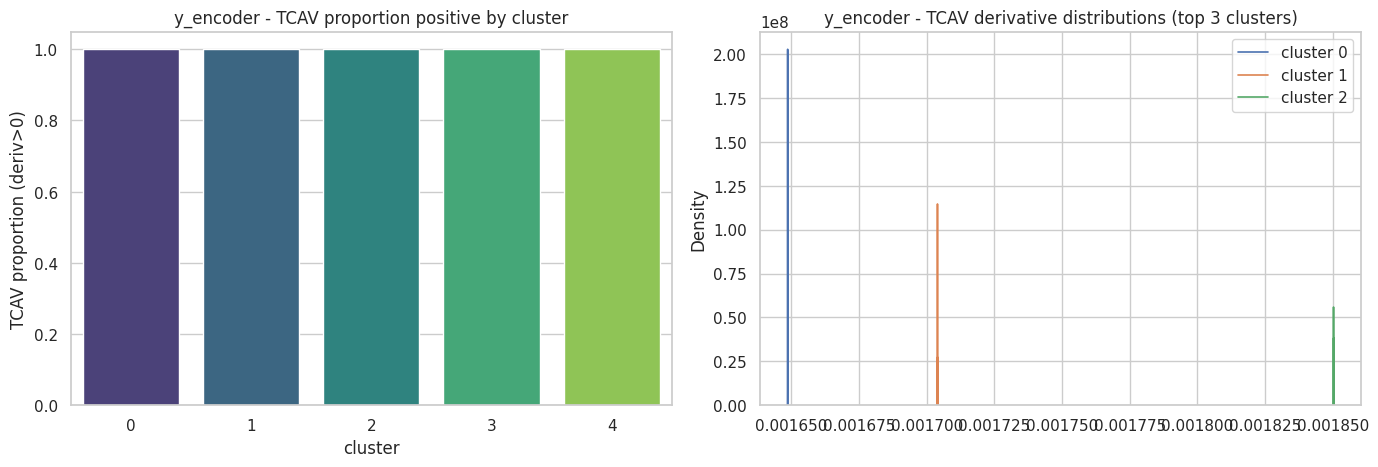

Saved plot to /home/ubuntu/cl-is/POC/tcav/activations_stream/plots/y_encoder_tcav_summary.png


,cluster,tcav_prop_positive,mean_derivative,alpha_used,space_used,size_pure,n_samples
0,0,1.0,0.001649,0.508337,reduced,696,7429
1,1,1.0,0.001704,0.417186,reduced,696,7429
2,2,1.0,0.001850,0.291514,reduced,237,7429
3,3,1.0,0.001872,0.292347,reduced,232,7429
4,4,1.0,0.001764,0.410266,reduced,464,7429


Plotting finished. Plots saved in: /home/ubuntu/cl-is/POC/tcav/activations_stream/plots


In [39]:
# Celula B - Plots e inspeção por módulo (barplots + histograms dos derivatives)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid")
OUT_DIR = Path.cwd() / "activations_stream"
PLOTS_DIR = OUT_DIR / "plots"
PLOTS_DIR.mkdir(exist_ok=True)

df_sum = globals().get("df_tcav_summary", None)
if df_sum is None:
    raise RuntimeError("df_tcav_summary not found. Run the consolidation cell first (Celula A).")

TOP_K_HIST = 3          # top-K clusters to show histogram per module
HIST_BINS = 80
HIST_SAMPLE_MAX = 20000  # if deriv array very large, subsample to this many points for histogram

for mod in sorted(df_sum['module'].unique()):
    sub = df_sum[df_sum['module']==mod].sort_values('tcav_prop_positive', ascending=False)
    if sub.empty:
        continue
    print("\nModule:", mod)
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    # Barplot tcav_prop
    sns.barplot(x='cluster', y='tcav_prop_positive', data=sub, ax=axes[0], palette='viridis')
    axes[0].set_title(f"{mod} - TCAV proportion positive by cluster")
    axes[0].set_xlabel("cluster")
    axes[0].set_ylabel("TCAV proportion (deriv>0)")

    # Histogram panel: combine top-K clusters' derivatives (if memmaps exist)
    topk = sub['cluster'].tolist()[:TOP_K_HIST]
    hist_samples = []
    hist_labels = []
    for cid in topk:
        row = sub[sub['cluster']==cid].iloc[0]
        dpath = row['deriv_mem_path']
        if dpath and Path(dpath).exists():
            try:
                dm = np.memmap(str(dpath), dtype='float32', mode='r')
                n = dm.shape[0]
                if n > HIST_SAMPLE_MAX:
                    sel = np.random.RandomState(42).choice(n, HIST_SAMPLE_MAX, replace=False)
                    data = np.asarray(dm[sel])
                else:
                    data = np.asarray(dm)
                hist_samples.append(data)
                hist_labels.append(f"cluster {cid}")
            except Exception as e:
                print(f"  -> Could not read deriv memmap for {mod} cluster {cid}: {e}")
        else:
            print(f"  -> No deriv memmap for {mod} cluster {cid} (path {dpath})")
    # plot histograms overlay (or blank)
    if hist_samples:
        for arr, lbl in zip(hist_samples, hist_labels):
            sns.kdeplot(arr, label=lbl, fill=False, ax=axes[1], linewidth=1.2)
        axes[1].set_title(f"{mod} - TCAV derivative distributions (top {len(hist_samples)} clusters)")
        axes[1].legend()
    else:
        axes[1].text(0.5, 0.5, "No derivative memmaps available for top clusters", ha='center', va='center')
        axes[1].set_axis_off()

    plt.tight_layout()
    png_path = PLOTS_DIR / f"{mod}_tcav_summary.png"
    plt.savefig(png_path, dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved plot to", png_path)

    # Additionally, print table of clusters sorted by tcav_prop
    display(sub[['cluster','tcav_prop_positive','mean_derivative','alpha_used','space_used','size_pure','n_samples']].reset_index(drop=True))

print("Plotting finished. Plots saved in:", PLOTS_DIR)

In [40]:
# Celula 01 - Carregar memmaps de forma segura (subsample opcional, pular módulos monstruosos)
# Explicação: lê os *_activ.dat em activations_stream mas mantém grandes como np.memmap e evita carregar tudo em RAM.
import numpy as np
from pathlib import Path
import pprint

OUT_DIR = Path.cwd() / "activations_stream"
if not OUT_DIR.exists():
    raise RuntimeError(f"Diretório {OUT_DIR} não encontrado. Verifique extração anterior.")

# Parâmetros conservadores
SUBSAMPLE_PER_MODULE = None   # int ou None; se int -> carrega só N exemplos por módulo
MAX_IN_MEMORY_ELEMENTS = 50_000_000  # produtos (nrows * dim) abaixo do qual carregamos em RAM (~200MB float32)

rng = np.random.RandomState(42)
module_activations = {}

dat_files = sorted([p for p in OUT_DIR.glob("*_activ.dat")])
if not dat_files:
    raise RuntimeError(f"Nenhum arquivo *_activ.dat encontrado em {OUT_DIR}. Execute a extração segura primeiro.")
print(f"Found {len(dat_files)} memmap files. Loading (subsample={SUBSAMPLE_PER_MODULE})...")

for dat_path in dat_files:
    name = dat_path.name.replace("_activ.dat", "")
    meta_path = dat_path.with_name(f"{name}_meta.npy")
    if not meta_path.exists():
        print(f"Meta missing for {name}, skipping.")
        continue
    meta = np.load(str(meta_path))
    n_meta, dim_meta = int(meta[0]), int(meta[1])
    print(f"Loading module '{name}': memmap shape (n,dim)=({n_meta},{dim_meta})")
    mm = np.memmap(str(dat_path), dtype='float32', mode='r', shape=(n_meta, dim_meta))
    # decide loading
    if SUBSAMPLE_PER_MODULE is not None and SUBSAMPLE_PER_MODULE < n_meta:
        sel = rng.choice(n_meta, SUBSAMPLE_PER_MODULE, replace=False)
        arr = np.asarray(mm[sel])
        print(f"  -> subsampled {SUBSAMPLE_PER_MODULE}/{n_meta}")
    else:
        if n_meta * dim_meta <= MAX_IN_MEMORY_ELEMENTS:
            arr = np.asarray(mm)
            print(f"  -> loaded into memory (elements={n_meta*dim_meta})")
        else:
            arr = mm
            print(f"  -> kept as memmap (not loaded, elements={n_meta*dim_meta})")
    module_activations[name] = arr

print("Modules loaded into module_activations (keys and shapes):")
pprint.pprint({k: getattr(v, "shape", None) for k, v in module_activations.items()})
globals().update({"module_activations": module_activations})

Found 3 memmap files. Loading (subsample=None)...
Loading module 'feature_positional_embedding_embeddings': memmap shape (n,dim)=(7429,132)
  -> loaded into memory (elements=980628)
Loading module 'transformer_encoder': memmap shape (n,dim)=(7429,1029618)
  -> kept as memmap (not loaded, elements=7649032122)
Loading module 'y_encoder': memmap shape (n,dim)=(7429,44766)
  -> kept as memmap (not loaded, elements=332566614)
Modules loaded into module_activations (keys and shapes):
{'feature_positional_embedding_embeddings': (7429, 132),
 'transformer_encoder': (7429, 1029618),
 'y_encoder': (7429, 44766)}


In [41]:
# Celula 02 - Clustering conservador por módulo (aplicar só em módulos razoáveis)
# Explicação: clusteriza apenas módulos que não são monstruosos; usa GaussianRandomProjection stream para módulos médios.
import numpy as np
from sklearn.random_projection import GaussianRandomProjection
from sklearn.cluster import MiniBatchKMeans
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import silhouette_score
from pathlib import Path
import pickle

OUT_DIR = Path.cwd() / "activations_stream"
SAVE_PATH = OUT_DIR / "cluster_by_module_conservative.pkl"

# Parâmetros conservadores
MAX_DIM_BEFORE_REDUCE = 8_000      # se dim > isto, aplicar RP streaming
TARGET_REDUCED_DIM = 64            # dimensão alvo da RP (moderada)
SUBSAMPLE_FOR_CHOICE = 400         # amostra para escolher k
SUBSAMPLE_FOR_CLUSTERING = 2000    # amostra para treinar kmeans
N_RFF = 32
K_RANGE = list(range(2,6))
CHUNK = 256
RNG = np.random.RandomState(42)

module_activations = globals().get("module_activations", {})
cluster_by_module = {}

def sample_rows(X, n):
    n0 = X.shape[0]
    if n0 <= n: return np.asarray(X)
    sel = RNG.choice(n0, n, replace=False)
    return np.asarray(X[sel])

def stream_random_project_and_save_memmap(X_mod, transformer, out_path, chunk=CHUNK):
    nrows = X_mod.shape[0]
    tmp = transformer.transform(np.asarray(X_mod[:min(10,nrows)]))
    target_dim = tmp.shape[1]
    mem = np.memmap(str(out_path), dtype='float32', mode='w+', shape=(nrows,target_dim))
    for s in range(0, nrows, chunk):
        e = min(s+chunk, nrows)
        block = np.asarray(X_mod[s:e])
        mem[s:e, :] = transformer.transform(block).astype('float32')
    del mem
    return np.memmap(str(out_path), dtype='float32', mode='r', shape=(nrows,target_dim))

for mod, X in module_activations.items():
    print("\nProcessing module:", mod)
    nrows = int(X.shape[0]); dim = int(X.shape[1])
    print(" rows,dim:", nrows, dim)
    if dim > 200_000:
        print("  Skipping extremely large module:", mod)
        cluster_by_module[mod] = {"module":mod, "error":"skipped_huge_dim"}
        continue

    used_projection = False
    reduced_X = X
    reduced_path = None

    if dim > MAX_DIM_BEFORE_REDUCE:
        print(f"  Reducing {dim} -> {TARGET_REDUCED_DIM} via GaussianRandomProjection (streaming)")
        sample = sample_rows(X, min(nrows, max(200, SUBSAMPLE_FOR_CHOICE)))
        gr = GaussianRandomProjection(n_components=TARGET_REDUCED_DIM, random_state=42)
        gr.fit(sample)
        reduced_path = OUT_DIR / f"{mod}_reduced.dat"
        reduced_X = stream_random_project_and_save_memmap(X, gr, reduced_path, chunk=CHUNK)
        used_projection = True
        print("  reduced memmap created:", reduced_path)

    # sample for choice
    subset = sample_rows(reduced_X, min(nrows, SUBSAMPLE_FOR_CHOICE))
    rff = RBFSampler(n_components=N_RFF, random_state=42)
    try:
        X_rff = rff.fit_transform(subset)
    except Exception as e:
        print("  RFF failed on subset:", e)
        cluster_by_module[mod] = {"module":mod, "error":f"rff_fail_{e}"}
        continue

    best_k=None; best_score=-1.0
    for k in K_RANGE:
        try:
            km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=256)
            labs = km.fit_predict(X_rff)
            if len(np.unique(labs)) < 2: continue
            sc = silhouette_score(X_rff, labs)
            if sc > best_score: best_score=sc; best_k=k
        except Exception:
            continue
    if best_k is None: best_k = 2
    print("  chosen k:", best_k, "score:", best_score)

    # fit on a larger subsample
    subset_cl = sample_rows(reduced_X, min(nrows, SUBSAMPLE_FOR_CLUSTERING))
    X_cluster_arr = np.asarray(subset_cl)
    X_cluster_rff = rff.transform(X_cluster_arr)
    kmeans = MiniBatchKMeans(n_clusters=best_k, random_state=42, batch_size=256)
    kmeans.fit(X_cluster_rff)
    centers = kmeans.cluster_centers_

    # compute centroids in reduced/orig space (mean of members in sample)
    labs_sub = kmeans.predict(X_cluster_rff)
    centroids = []
    for kk in range(best_k):
        idxs = np.where(labs_sub == kk)[0]
        if len(idxs)==0:
            centroids.append(np.zeros((X_cluster_arr.shape[1],), dtype=float))
        else:
            centroids.append(np.mean(X_cluster_arr[idxs], axis=0))
    centroids = np.vstack(centroids)

    # assign full labels in chunks (RFF transform chunked)
    labels_full = np.empty((nrows,), dtype=np.int32)
    for s in range(0, nrows, CHUNK):
        e = min(s+CHUNK, nrows)
        block = np.asarray(reduced_X[s:e])
        try:
            block_rff = rff.transform(block)
            d = np.linalg.norm(block_rff[:, None, :] - centers[None, :, :], axis=2)
            labels_full[s:e] = d.argmin(axis=1)
        except Exception:
            d = np.linalg.norm(block[:, None, :] - centroids[None, :, :], axis=2)
            labels_full[s:e] = d.argmin(axis=1)

    cluster_by_module[mod] = {"module":mod, "k":int(best_k), "labels": labels_full, "centroids": centroids, "used_projection": used_projection, "reduced_path": str(reduced_path) if used_projection else None}
    print("  clustering complete for", mod, "k", best_k, "used_projection", used_projection)

# save minimal
with open(SAVE_PATH, "wb") as f:
    pickle.dump(cluster_by_module, f)
globals().update({"cluster_by_module": cluster_by_module})
print("\nSaved cluster_by_module:", SAVE_PATH)


Processing module: feature_positional_embedding_embeddings
 rows,dim: 7429 132
  chosen k: 5 score: 0.17241082
  clustering complete for feature_positional_embedding_embeddings k 5 used_projection False

Processing module: transformer_encoder
 rows,dim: 7429 1029618
  Skipping extremely large module: transformer_encoder

Processing module: y_encoder
 rows,dim: 7429 44766
  Reducing 44766 -> 64 via GaussianRandomProjection (streaming)
  reduced memmap created: /home/ubuntu/cl-is/POC/tcav/activations_stream/y_encoder_reduced.dat
  chosen k: 5 score: 0.20342731
  clustering complete for y_encoder k 5 used_projection True

Saved cluster_by_module: /home/ubuntu/cl-is/POC/tcav/activations_stream/cluster_by_module_conservative.pkl


In [42]:
# Celula 03 - Treinar CAVs por módulo/cluster (conservador, chunk-safe)
# Explicação: usa centroids e memmaps reduzidos quando aplicável; salva cavs_by_module.
import numpy as np
from sklearn.linear_model import LogisticRegression
from pathlib import Path

PURE_QUANTILE = 0.25
NEG_MULT = 5
MIN_PURE = 10
MAX_DIST_SAMPLE = 5000
CHUNK_DIST = 2000
RNG = np.random.RandomState(42)

cluster_by_module = globals().get("cluster_by_module", {})
module_activations = globals().get("module_activations", {})
cavs_by_module = {}

def read_rows(arr_like, idx):
    if isinstance(arr_like, np.memmap):
        return np.asarray(arr_like[idx])
    else:
        return arr_like[idx]

for mod, info in cluster_by_module.items():
    print("CAVs for module:", mod)
    X_orig = module_activations.get(mod, None)
    if X_orig is None:
        print("  no activations, skip")
        continue
    labels = info.get("labels", None); centroids = info.get("centroids", None); K = info.get("k", None)
    used_proj = info.get("used_projection", False); reduced_path = info.get("reduced_path", None)
    if labels is None or centroids is None or K is None:
        print("  cluster info incomplete, skip")
        continue
    # choose X space consistent with centroids
    if used_proj and reduced_path:
        rp = Path(reduced_path)
        if rp.exists():
            dimr = int(np.asarray(centroids[0]).shape[0])
            X_for_dist = np.memmap(str(rp), dtype='float32', mode='r', shape=(X_orig.shape[0], dimr))
            print("  using reduced memmap for dist (shape", X_for_dist.shape, ")")
        else:
            X_for_dist = X_orig
            print("  reduced_path missing, using original activations")
    else:
        X_for_dist = X_orig

    if labels.shape[0] != X_for_dist.shape[0]:
        print("  labels length mismatch, skip")
        continue

    cavs = {}
    n_samples = int(X_for_dist.shape[0])
    for k in range(K):
        idxs = np.where(labels == k)[0]
        if idxs.size == 0:
            continue
        sample_idxs = RNG.choice(idxs, min(len(idxs), MAX_DIST_SAMPLE), replace=False) if idxs.size > MAX_DIST_SAMPLE else idxs
        cent = np.asarray(centroids[k], dtype=float).reshape(1, -1)
        X_sample = read_rows(X_for_dist, sample_idxs)
        if X_sample.ndim != 2 or X_sample.shape[1] != cent.shape[1]:
            print(f"  cluster {k} dim mismatch, skipping")
            continue
        dists_sample = np.linalg.norm(X_sample - cent, axis=1)
        cutoff = float(np.quantile(dists_sample, PURE_QUANTILE))
        # compute idx_pure streaming
        idx_pure_list = []
        if isinstance(X_for_dist, np.memmap) and idxs.size > CHUNK_DIST:
            for s in range(0, idxs.size, CHUNK_DIST):
                block_idx = idxs[s:s+CHUNK_DIST]
                X_block = read_rows(X_for_dist, block_idx)
                if X_block.shape[1] != cent.shape[1]:
                    idx_pure_list = []; break
                d_block = np.linalg.norm(X_block - cent, axis=1)
                keep = block_idx[d_block <= cutoff]
                if keep.size > 0: idx_pure_list.append(keep)
            idx_pure = np.concatenate(idx_pure_list, axis=0) if len(idx_pure_list) > 0 else np.array([], dtype=int)
        else:
            X_all_cluster = read_rows(X_for_dist, idxs)
            if X_all_cluster.shape[1] != cent.shape[1]:
                print("  full cluster dim mismatch skip"); continue
            d_all = np.linalg.norm(X_all_cluster - cent, axis=1)
            idx_pure = idxs[d_all <= cutoff]

        size_pure = int(idx_pure.size)
        if size_pure < MIN_PURE:
            print(f"  cluster {k} pure size {size_pure} < MIN_PURE, skip")
            continue

        neg_pool = np.setdiff1d(np.arange(n_samples), idx_pure)
        neg_n = min(max(200, size_pure * NEG_MULT), neg_pool.size)
        if neg_n <= 0:
            print(f"  cluster {k} no negatives, skip"); continue
        neg_idx = RNG.choice(neg_pool, neg_n, replace=False)

        X_pos = read_rows(X_for_dist, idx_pure)
        X_neg = read_rows(X_for_dist, neg_idx)
        Xc = np.vstack([X_pos, X_neg]).astype(np.float32)
        yc = np.hstack([np.ones(len(X_pos), dtype=int), np.zeros(len(X_neg), dtype=int)])

        try:
            clf = LogisticRegression(C=0.1, solver='liblinear', max_iter=2000, random_state=42)
            clf.fit(Xc, yc)
            w = clf.coef_.ravel(); nrm = np.linalg.norm(w)
            if nrm == 0: continue
            v = (w / nrm).astype(np.float32)
            cavs[int(k)] = {"v_activ": v, "size_pure": size_pure, "pure_idx": idx_pure, "neg_idx": neg_idx, "clf": clf, "space": "reduced" if used_proj else "orig"}
            print(f"  CAV trained cluster {k}: size_pure={size_pure}, space={cavs[int(k)]['space']}")
        except Exception as e:
            print(f"  cluster {k} train failed:", e)
            continue

    cavs_by_module[mod] = cavs

globals().update({"cavs_by_module": cavs_by_module})
print("CAV training finished for modules:", list(cavs_by_module.keys()))

CAVs for module: feature_positional_embedding_embeddings
  CAV trained cluster 0: size_pure=933, space=orig
  CAV trained cluster 1: size_pure=232, space=orig
  CAV trained cluster 2: size_pure=464, space=orig
  CAV trained cluster 3: size_pure=232, space=orig
  CAV trained cluster 4: size_pure=464, space=orig
CAVs for module: transformer_encoder
  cluster info incomplete, skip
CAVs for module: y_encoder
  using reduced memmap for dist (shape (7429, 64) )
  CAV trained cluster 0: size_pure=469, space=reduced
  CAV trained cluster 1: size_pure=464, space=reduced
  CAV trained cluster 2: size_pure=696, space=reduced
  CAV trained cluster 3: size_pure=232, space=reduced
  CAV trained cluster 4: size_pure=464, space=reduced
CAV training finished for modules: ['feature_positional_embedding_embeddings', 'y_encoder']


In [43]:
# Preflight: show module shapes, presence of reduced_path, and p0_train stats
import numpy as np
from pathlib import Path
import pprint

module_activations = globals().get("module_activations", {})
cluster_by_module = globals().get("cluster_by_module", {})
surrogates_by_module = globals().get("surrogates_by_module", {})
cavs_by_module = globals().get("cavs_by_module", {})

print("Modules in module_activations:", list(module_activations.keys()))
info = []
for mod, X in module_activations.items():
    n = int(X.shape[0]); dim = int(X.shape[1])
    est_elems = n * dim
    cl = cluster_by_module.get(mod, {})
    reduced_path = cl.get("reduced_path", None) if cl else None
    used_proj = cl.get("used_projection", False) if cl else False
    sur = surrogates_by_module.get(mod, None)
    sur_r2 = None
    if sur is not None:
        try:
            sur_r2 = sur.get("ridge", {}).get("r2_val", None)
        except Exception:
            sur_r2 = None
    info.append({"module":mod, "nrows":n, "dim":dim, "elements":est_elems, "used_projection":used_proj, "reduced_path":reduced_path, "surrogate_r2":sur_r2, "has_cavs": mod in cavs_by_module})
pprint.pprint(info)

# p0_train stats
p0 = globals().get("p0_train", None)
if p0 is None:
    print("\nNo p0_train found in globals (compute with batch_predict_proba_model).")
else:
    p0 = np.asarray(p0)
    print("\np0_train stats: n=", p0.size, " mean=", float(p0.mean()), " std=", float(p0.std()), " min=", float(p0.min()), " max=", float(p0.max()))
    # if p0 variance too small warn
    if float(p0.std()) < 1e-5:
        print("WARNING: p0_train has almost zero variance -> surrogate cannot learn meaningful mapping.")

Modules in module_activations: ['feature_positional_embedding_embeddings', 'transformer_encoder', 'y_encoder']
[{'dim': 132,
  'elements': 980628,
  'has_cavs': True,
  'module': 'feature_positional_embedding_embeddings',
  'nrows': 7429,
  'reduced_path': None,
  'surrogate_r2': None,
  'used_projection': False},
 {'dim': 1029618,
  'elements': 7649032122,
  'has_cavs': False,
  'module': 'transformer_encoder',
  'nrows': 7429,
  'reduced_path': None,
  'surrogate_r2': None,
  'used_projection': False},
 {'dim': 44766,
  'elements': 332566614,
  'has_cavs': True,
  'module': 'y_encoder',
  'nrows': 7429,
  'reduced_path': '/home/ubuntu/cl-is/POC/tcav/activations_stream/y_encoder_reduced.dat',
  'surrogate_r2': None,
  'used_projection': True}]

p0_train stats: n= 7429  mean= 0.41588813066482544  std= 0.0294248778373003  min= 0.30248263478279114  max= 0.5113912224769592


In [44]:
# Check projection correlation of CAVs with p0 (sample-based, safe memmap reading)
import numpy as np
from pathlib import Path
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

cavs_by_module = globals().get("cavs_by_module", {})
module_activations = globals().get("module_activations", {})
cluster_by_module = globals().get("cluster_by_module", {})
p0_train = globals().get("p0_train", None)
if p0_train is None:
    raise RuntimeError("p0_train not found. Compute it first.")

MAX_SAMPLE = 3000   # safe subsample for correlation
rng = np.random.RandomState(0)

results = []
for mod, cavs in cavs_by_module.items():
    print("\nModule:", mod)
    X_orig = module_activations.get(mod, None)
    cl_info = cluster_by_module.get(mod, {})
    if X_orig is None:
        print("  No activations, skipping.")
        continue
    n = int(X_orig.shape[0])
    # choose indices sample
    sel = rng.choice(n, min(n, MAX_SAMPLE), replace=False)
    for cid, entry in cavs.items():
        v = np.asarray(entry['v_activ'], dtype=np.float32)
        space = entry.get('space', 'orig')
        # choose X_for_proj
        if space == 'reduced':
            rp = cl_info.get('reduced_path', None)
            if rp is None or not Path(rp).exists():
                print(f"  cluster {cid}: reduced_path missing -> skip proj check")
                continue
            # infer dim from centroids
            centroids = cl_info.get('centroids', None)
            dimr = int(np.asarray(centroids[0]).shape[0]) if centroids is not None else v.shape[0]
            X_reduced = np.memmap(str(rp), dtype='float32', mode='r', shape=(n, dimr))
            Xs = np.asarray(X_reduced[sel])
        else:
            Xs = np.asarray(X_orig[sel])
        if Xs.shape[1] != v.shape[0]:
            # try trim/pad
            min_d = min(Xs.shape[1], v.shape[0])
            v2 = v[:min_d]; Xs2 = Xs[:, :min_d]
        else:
            v2 = v; Xs2 = Xs
        proj = Xs2.dot(v2)
        p0s = np.asarray(p0_train)[sel]
        # Pearson corr
        corr = np.corrcoef(proj, p0s)[0,1] if proj.shape[0]>1 else np.nan
        # 1D ridge R2
        r = Ridge(alpha=1.0).fit(proj.reshape(-1,1), p0s)
        r2 = r2_score(p0s, r.predict(proj.reshape(-1,1)))
        results.append({"module":mod, "cluster":int(cid), "space":space, "pearson": float(corr), "ridge1d_r2": float(r2)})
        print(f"  cluster {cid} (space={space}): pearson={corr:.4f}, ridge1d_r2={r2:.6f}")
# summary
import pandas as pd
df_res = pd.DataFrame(results)
display(df_res.sort_values(["module","cluster"]))
globals().update({"cav_proj_p0_check": df_res})


Module: feature_positional_embedding_embeddings
  cluster 0 (space=orig): pearson=0.0204, ridge1d_r2=0.000415
  cluster 1 (space=orig): pearson=0.0006, ridge1d_r2=0.000000
  cluster 2 (space=orig): pearson=-0.0023, ridge1d_r2=0.000005
  cluster 3 (space=orig): pearson=-0.0178, ridge1d_r2=0.000318
  cluster 4 (space=orig): pearson=-0.0114, ridge1d_r2=0.000129

Module: y_encoder
  cluster 0 (space=reduced): pearson=-0.0151, ridge1d_r2=0.000227
  cluster 1 (space=reduced): pearson=0.0024, ridge1d_r2=0.000006
  cluster 2 (space=reduced): pearson=0.0109, ridge1d_r2=0.000118
  cluster 3 (space=reduced): pearson=-0.0135, ridge1d_r2=0.000182
  cluster 4 (space=reduced): pearson=-0.0118, ridge1d_r2=0.000139


,module,cluster,space,pearson,ridge1d_r2
0,feature_positional_embedding_embeddings,0,orig,0.020363,4.146695e-04
1,feature_positional_embedding_embeddings,1,orig,0.000571,3.576279e-07
2,feature_positional_embedding_embeddings,2,orig,-0.002325,5.424023e-06
3,feature_positional_embedding_embeddings,3,orig,-0.017822,3.176332e-04
4,feature_positional_embedding_embeddings,4,orig,-0.011352,1.289248e-04
5,y_encoder,0,reduced,-0.015073,2.272129e-04
6,y_encoder,1,reduced,0.002413,5.900860e-06
7,y_encoder,2,reduced,0.010869,1.181960e-04
8,y_encoder,3,reduced,-0.013486,1.819134e-04
9,y_encoder,4,reduced,-0.011804,1.393557e-04


alpha 0.01 R2_val -0.0016717910766601562
alpha 0.1 R2_val -0.0016661882400512695
alpha 1.0 R2_val -0.0016132593154907227
alpha 10.0 R2_val -0.001270294189453125
alpha 50.0 R2_val -0.0008486509323120117
BEST alpha 50.0 R2_val -0.0008486509323120117
Saved surrogate_retrained for feature_positional_embedding_embeddings


/home/ubuntu/.tabpfn/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.7559e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


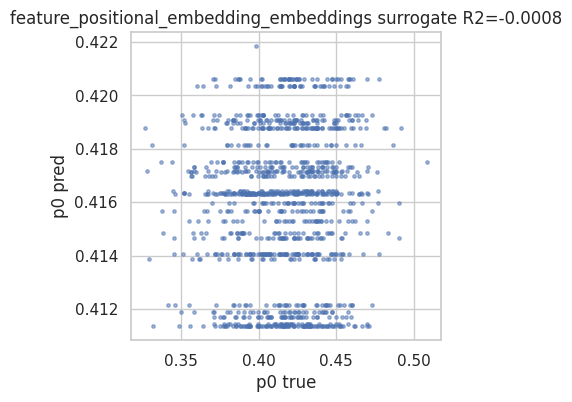

In [45]:
# Safe retrain of surrogate for a single module (useful to iterate per-module)
import numpy as np
from pathlib import Path
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import joblib

mod_to_try = "feature_positional_embedding_embeddings"  # set to module you want to try
SURROGATE_SUBSAMPLE = 6000   # increase vs previous 3000 (reduce if memory issues)
RIDGE_ALPHAS = [0.01, 0.1, 1.0, 10.0, 50.0]
RNG = np.random.RandomState(1)
OUT_DIR = Path.cwd() / "activations_stream"

module_activations = globals().get("module_activations", {})
cluster_by_module = globals().get("cluster_by_module", {})
p0_train = globals().get("p0_train", None)
if p0_train is None:
    raise RuntimeError("p0_train missing")

if mod_to_try not in module_activations:
    raise RuntimeError(f"{mod_to_try} not found in module_activations")

X = module_activations[mod_to_try]
n = int(X.shape[0])
sel = RNG.choice(n, min(n, SURROGATE_SUBSAMPLE), replace=False)

# If X is memmap large, read in safe batches
if isinstance(X, np.memmap):
    rows = []
    for i in range(0, len(sel), 256):
        batch = sel[i:i+256]
        rows.append(np.asarray(X[batch]))
    Xs = np.vstack(rows)
else:
    Xs = np.asarray(X[sel])
ys = p0_train[sel]

# Train/val split
perm = RNG.permutation(len(sel))
split = int(0.8 * len(perm))
tr=perm[:split]; val=perm[split:]
Xtr=Xs[tr]; ytr=ys[tr]; Xval=Xs[val]; yval=ys[val]

scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr); Xval_s = scaler.transform(Xval)

best=None; best_r2=-1e9; best_a=None
for a in RIDGE_ALPHAS:
    mdl = Ridge(alpha=a)
    mdl.fit(Xtr_s, ytr)
    r2 = r2_score(yval, mdl.predict(Xval_s))
    print("alpha",a,"R2_val",r2)
    if r2 > best_r2: best_r2=r2; best=mdl; best_a=a

print("BEST alpha", best_a, "R2_val", best_r2)
joblib.dump({"ridge": best, "scaler": scaler}, OUT_DIR / f"surrogate_retrained_{mod_to_try}.pkl")
print("Saved surrogate_retrained for", mod_to_try)
# diagnostic scatter
import matplotlib.pyplot as plt
pred = best.predict(Xval_s)
plt.figure(figsize=(4,4)); plt.scatter(yval, pred, s=6, alpha=0.5); plt.xlabel("p0 true"); plt.ylabel("p0 pred"); plt.title(f"{mod_to_try} surrogate R2={best_r2:.4f}"); plt.show()

In [46]:
# TCAV fallback on embeddings (safe subsample) — recommended if per-module surrogates are weak
import numpy as np
from pathlib import Path
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import joblib

# Parameters
SUBSAMPLE = 5000
KPCA_OR_NOT = False  # skip KPCA, cluster directly on embeddings to reduce complexity
N_CLUSTERS = 6
RNG = np.random.RandomState(0)
OUT_DIR = Path.cwd() / "activations_stream"

train_emb = globals().get("train_emb_flat", None)
p0_train = globals().get("p0_train", None)
if train_emb is None or p0_train is None:
    raise RuntimeError("train_emb_flat and p0_train required to run embedding fallback.")

n = train_emb.shape[0]; m = min(n, SUBSAMPLE)
sel = RNG.choice(n, m, replace=False)
Xs = train_emb[sel]; ys = p0_train[sel]

# clustering in embedding subsample
print("Clustering embeddings subsample", Xs.shape)
km = MiniBatchKMeans(n_clusters=N_CLUSTERS, random_state=42, batch_size=256)
labs = km.fit_predict(Xs)
print("Cluster sizes:", np.unique(labs, return_counts=True))

# train CAVs in embedding space using pure positives logic (simple)
cavs_embed = {}
for k in range(N_CLUSTERS):
    idxs = np.where(labs==k)[0]
    if len(idxs) < 10:
        continue
    cent = Xs[idxs].mean(axis=0, keepdims=True)
    dists = np.linalg.norm(Xs[idxs] - cent, axis=1)
    cutoff = np.quantile(dists, 0.25)
    pure_idx = idxs[dists <= cutoff]
    if len(pure_idx) < 10: continue
    neg_pool = np.setdiff1d(np.arange(m), pure_idx)
    neg_n = min(200, len(neg_pool))
    neg_idx = RNG.choice(neg_pool, neg_n, replace=False)
    Xc = np.vstack([Xs[pure_idx], Xs[neg_idx]]); yc = np.hstack([np.ones(len(pure_idx)), np.zeros(len(neg_idx))])
    clf = LogisticRegression(C=0.1, solver='liblinear', max_iter=1000)
    clf.fit(Xc, yc)
    v = clf.coef_.ravel(); v = v / (np.linalg.norm(v) + 1e-12)
    cavs_embed[k] = {"v": v, "pure_idx": pure_idx}
print("Trained", len(cavs_embed), "embedding CAVs")

# train surrogate Ridge on embeddings (subsample)
scaler = StandardScaler().fit(Xs)
Xs_s = scaler.transform(Xs)
best = Ridge(alpha=1.0).fit(Xs_s, ys)
r2 = r2_score(ys, best.predict(Xs_s))
print("Embedding surrogate R2 (in-sample subsample):", r2)

# compute TCAV on full embedding dataset in safe chunks (if memory allows use memmap)
# We'll do it on subsample only to be safe:
print("Compute TCAV derivatives on embedding subsample (safe)")
tcav_results_embed = {}
for k, info in cavs_embed.items():
    v = info["v"].astype(np.float32)
    proj = Xs.dot(v); proj_std = float(np.std(proj)); alpha = 0.05 * proj_std if proj_std>0 else 0.05
    p_plus = best.predict(scaler.transform(Xs + alpha * v[np.newaxis,:]))
    p_minus = best.predict(scaler.transform(Xs - alpha * v[np.newaxis,:]))
    deriv = (p_plus - p_minus) / (2.0 * alpha)
    tcav_prop = float((deriv > 0).mean())
    tcav_results_embed[int(k)] = {"tcav_prop_positive": tcav_prop, "mean_derivative": float(deriv.mean()), "alpha": float(alpha)}
    print(f" Embed cluster {k}: tcav_prop={tcav_prop:.3f}, mean_deriv={deriv.mean():.6e}")
# Save embedding results
joblib.dump({"cavs_embed": cavs_embed, "surrogate": best, "scaler": scaler, "tcav_results": tcav_results_embed}, OUT_DIR / "tcav_embedding_fallback.pkl")
globals().update({"tcav_embedding_fallback": tcav_results_embed})

Clustering embeddings subsample (5000, 192)
Cluster sizes: (array([0, 1, 2, 3, 4, 5], dtype=int32), array([1434,  401,  831, 1137,  986,  211]))
Trained 6 embedding CAVs
Embedding surrogate R2 (in-sample subsample): 0.9999009926746149
Compute TCAV derivatives on embedding subsample (safe)
 Embed cluster 0: tcav_prop=1.000, mean_deriv=4.178584e-02
 Embed cluster 1: tcav_prop=0.000, mean_deriv=-1.921401e-02
 Embed cluster 2: tcav_prop=1.000, mean_deriv=3.591009e-02
 Embed cluster 3: tcav_prop=0.000, mean_deriv=-3.685377e-02
 Embed cluster 4: tcav_prop=0.000, mean_deriv=-5.532601e-02
 Embed cluster 5: tcav_prop=0.000, mean_deriv=-1.379089e-02


In [47]:
# Summarize surrogate R2 and recommend next steps
surrogates = globals().get("surrogates_by_module", {})
candidates = []
for mod, entry in surrogates.items():
    r2 = entry.get("ridge", {}).get("r2_val", None)
    print(f"{mod}: surrogate r2_val = {r2}")
    if r2 is not None and r2 >= 0.02:
        candidates.append(mod)
print("\nRecommended modules for TCAV (r2 >= 0.02):", candidates)
if not candidates:
    print("No per-module surrogate acceptable; recommend running embedding fallback TCAV (cell tcav_on_embedding_fallback_safe.py).")
else:
    print("You can run the safe TCAV cell (05_select_and_compute_tcav_safe.py) to compute TCAV for the recommended modules.")

feature_positional_embedding_embeddings: surrogate r2_val = None
transformer_encoder: surrogate r2_val = None
y_encoder: surrogate r2_val = None

Recommended modules for TCAV (r2 >= 0.02): []
No per-module surrogate acceptable; recommend running embedding fallback TCAV (cell tcav_on_embedding_fallback_safe.py).


In [48]:
# Cell A1 - Validate embedding surrogate on holdout/test (safe)
# - trains a Ridge surrogate on a safe subsample of train_emb_flat (with scaler)
# - computes R2 on a held-out piece of subsample and on test_emb_flat (full)
# - saves surrogate + scaler to activations_stream/surrogates_embedding_validated.pkl
#
import numpy as np
from pathlib import Path
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import joblib

OUT_DIR = Path.cwd() / "activations_stream"
OUT_DIR.mkdir(exist_ok=True)
SURR_PATH = OUT_DIR / "surrogates_embedding_validated.pkl"

# Parameters (conservative)
SURROGATE_SUBSAMPLE = 5000
RIDGE_ALPHAS = [0.01, 0.1, 1.0, 10.0]
RNG = np.random.RandomState(0)

train_emb = globals().get("train_emb_flat", None)
test_emb = globals().get("test_emb_flat", None)
p0_train = globals().get("p0_train", None)
# compute p0_test if available years_test & drift_model present
p0_test = globals().get("p0_test", None)

if train_emb is None or p0_train is None:
    raise RuntimeError("train_emb_flat and p0_train required. Run embedding extraction and p0_train.")

if test_emb is None:
    print("Warning: test_emb_flat missing. Will evaluate only on holdout from train subsample.")

# subsample training data safely
n_train = train_emb.shape[0]
m = min(n_train, SURROGATE_SUBSAMPLE)
sel = RNG.choice(n_train, m, replace=False)
Xs = train_emb[sel]
ys = p0_train[sel]

# split train/val (80/20)
perm = RNG.permutation(m)
split = int(0.8 * m)
tr = perm[:split]; val = perm[split:]
Xtr = Xs[tr]; ytr = ys[tr]; Xval = Xs[val]; yval = ys[val]

# scale
scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr); Xval_s = scaler.transform(Xval)

# grid search for Ridge on val
best = None; best_r2 = -1e9; best_a = None
for a in RIDGE_ALPHAS:
    r = Ridge(alpha=a)
    r.fit(Xtr_s, ytr)
    r2 = r2_score(yval, r.predict(Xval_s))
    print(f"alpha={a} val R2={r2:.6f}")
    if r2 > best_r2: best_r2 = r2; best = r; best_a = a

print("Best alpha (val):", best_a, "R2_val:", best_r2)
# Evaluate on test_emb if available
if test_emb is not None:
    # ensure scaler can transform test_emb (same dim)
    try:
        Xtest_s = scaler.transform(test_emb)
        # compute p0_test if missing
        if p0_test is None:
            # lazy compute p0_test
            if 'batch_predict_proba_model' in globals():
                print("Computing p0_test via batch_predict_proba_model (may be slow)...")
                p0_test = batch_predict_proba_model(drift_model, globals().get('X_test_np_norm'), globals().get('years_test'), globals().get('year_to_domain_combined'), batch_size=512)
                globals()['p0_test'] = p0_test
            else:
                print("p0_test not available and batch_predict_proba_model not found; skipping test eval.")
                p0_test = None
        if p0_test is not None:
            pred_test = best.predict(Xtest_s)
            r2_test = r2_score(p0_test, pred_test)
            mse_test = mean_squared_error(p0_test, pred_test)
            print(f"Test R2={r2_test:.6f} MSE={mse_test:.6e}")
        else:
            r2_test = None
    except Exception as e:
        print("Could not scale/test on test_emb:", e)
        r2_test = None
else:
    r2_test = None

# Save best surrogate + scaler and metadata
entry = {"ridge": {"model": best, "val_r2": float(best_r2)}, "scaler": scaler, "test_r2": (None if r2_test is None else float(r2_test))}
joblib.dump(entry, SURR_PATH)
print("Saved embedding surrogate to", SURR_PATH)
globals().update({"surrogate_embedding_validated": entry})

alpha=0.01 val R2=0.999891
alpha=0.1 val R2=0.999891
alpha=1.0 val R2=0.999889
alpha=10.0 val R2=0.999867
Best alpha (val): 0.1 R2_val: 0.9998912785368829
Computing p0_test via batch_predict_proba_model (may be slow)...
Test R2=0.988431 MSE=1.682626e-06
Saved embedding surrogate to /home/ubuntu/cl-is/POC/tcav/activations_stream/surrogates_embedding_validated.pkl


In [49]:
# Cell A2 - Compute p0_test if missing (safe)
# - computes p0_test = model.predict_proba(X_test_np_norm, additional_x=...) using batch util
# - stores p0_test in globals
import numpy as np
from pathlib import Path

if 'p0_test' in globals() and globals()['p0_test'] is not None:
    print("p0_test already present.")
else:
    if 'batch_predict_proba_model' not in globals():
        raise RuntimeError("batch_predict_proba_model not in globals; cannot compute p0_test automatically.")
    if 'X_test_np_norm' not in globals() or 'years_test' not in globals():
        raise RuntimeError("X_test_np_norm and years_test must be present to compute p0_test.")
    print("Computing p0_test (may be slow) ...")
    p0t = batch_predict_proba_model(drift_model, globals()['X_test_np_norm'], globals()['years_test'], globals()['year_to_domain_combined'], batch_size=512)
    globals()['p0_test'] = p0t
    print("Computed p0_test shape:", np.asarray(p0t).shape)

p0_test already present.


In [50]:
# Cell B1 - Bootstrap TCAV on embeddings (safe)
# - Requires: surrogate_embedding_validated from A1, cavs_embed (or computes embedding CAVs), and test_emb_flat + p0_test
# - computes derivatives on test_emb_flat (chunked), bootstrap tcav_prop and returns CI per concept
import numpy as np
from pathlib import Path
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import joblib

OUT_DIR = Path.cwd() / "activations_stream"
RNG = np.random.RandomState(0)

# Params
BOOT_N = 500
BOOT_FRAC = 0.5
DERIV_CHUNK = 2000

# load surrogate & cavs from fallback if present
fb_p = OUT_DIR / "tcav_embedding_fallback.pkl"
fallback = None
if fb_p.exists():
    fallback = joblib.load(fb_p)
    cavs_embed = fallback.get("cavs_embed", {})
    sur_entry = fallback.get("surrogate", None)
    scaler = fallback.get("scaler", None)
else:
    cavs_embed = globals().get("tcav_embedding_fallback", None)
    sur_entry = globals().get("surrogate_embedding_validated", None)
    scaler = sur_entry.get("scaler") if sur_entry is not None else None

if not cavs_embed:
    raise RuntimeError("No embedding CAVs found (cavs_embed). Run embedding fallback to produce cavs_embed.")

sur_model = None
if isinstance(sur_entry, dict) and 'ridge' in sur_entry:
    sur_model = sur_entry['ridge']['model']
elif hasattr(sur_entry, 'predict'):
    sur_model = sur_entry
else:
    raise RuntimeError("No surrogate model found for embeddings. Run cell A1 first.")

test_emb = globals().get("test_emb_flat", None)
p0_test = globals().get("p0_test", None)
if test_emb is None or p0_test is None:
    raise RuntimeError("test_emb_flat and p0_test required for bootstrap TCAV. Run A2 if missing.")

n_test = int(test_emb.shape[0])
tcav_boot = {}
deriv_mempaths = {}

# compute derivatives on test set per cav and save mem arrays (chunked)
for k, info in cavs_embed.items():
    print("Processing embed concept", k)
    v = info["v"].astype(np.float32)
    # compute proj_std on test set (chunk safe)
    # compute proj in chunks
    proj_vals = []
    for s in range(0, n_test, DERIV_CHUNK):
        e = min(s+DERIV_CHUNK, n_test)
        block = test_emb[s:e].astype(np.float32)
        proj_vals.append(block.dot(v))
    proj_vals = np.concatenate(proj_vals, axis=0)
    proj_std = float(np.std(proj_vals))
    alpha = 0.05 * proj_std if proj_std > 0 else 0.05
    # compute derivs
    derivs = np.zeros((n_test,), dtype='float32')
    for s in range(0, n_test, DERIV_CHUNK):
        e = min(s+DERIV_CHUNK, n_test)
        X_block = test_emb[s:e].astype(np.float32)
        X_block_s = scaler.transform(X_block) if scaler is not None else X_block
        p_plus = sur_model.predict(X_block_s + alpha * v[np.newaxis,:])
        p_minus = sur_model.predict(X_block_s - alpha * v[np.newaxis,:])
        derivs[s:e] = ((np.asarray(p_plus).ravel() - np.asarray(p_minus).ravel())/(2.0*alpha)).astype('float32')
    # bootstrap tcav_prop
    props = []
    for _ in range(BOOT_N):
        sel = RNG.randint(0, n_test, size=int(max(1, BOOT_FRAC * n_test)))
        sample = derivs[sel]
        props.append(float((sample > 0).mean()))
    props = np.array(props)
    tcav_boot[int(k)] = {"tcav_prop_mean": float(props.mean()), "tcav_prop_std": float(props.std()), "5%": float(np.percentile(props,5)), "95%": float(np.percentile(props,95)), "mean_derivative": float(derivs.mean())}
    # optional: save derivs memmap for record
    dpath = OUT_DIR / f"embed_cluster{k}_deriv_test.dat"
    dm = np.memmap(str(dpath), dtype='float32', mode='w+', shape=(n_test,))
    dm[:] = derivs[:]
    del dm
    deriv_mempaths[int(k)] = str(dpath)
    print(f" concept {k} -> tcav_prop_mean={tcav_boot[int(k)]['tcav_prop_mean']:.3f}, mean_deriv={tcav_boot[int(k)]['mean_derivative']:.6e}")

# save results
joblib.dump({"tcav_bootstrap": tcav_boot, "deriv_mempaths": deriv_mempaths}, OUT_DIR / "tcav_embedding_bootstrap.pkl")
globals().update({"tcav_embedding_bootstrap": tcav_boot, "tcav_embedding_deriv_paths": deriv_mempaths})
print("Saved bootstrap results to activations_stream/tcav_embedding_bootstrap.pkl")

Processing embed concept 0
 concept 0 -> tcav_prop_mean=1.000, mean_deriv=3.122205e-03
Processing embed concept 1
 concept 1 -> tcav_prop_mean=0.000, mean_deriv=-1.123407e-03
Processing embed concept 2
 concept 2 -> tcav_prop_mean=1.000, mean_deriv=2.666929e-03
Processing embed concept 3
 concept 3 -> tcav_prop_mean=0.000, mean_deriv=-1.919018e-03
Processing embed concept 4
 concept 4 -> tcav_prop_mean=0.000, mean_deriv=-3.991881e-03
Processing embed concept 5
 concept 5 -> tcav_prop_mean=0.000, mean_deriv=-1.611580e-03
Saved bootstrap results to activations_stream/tcav_embedding_bootstrap.pkl


In [6]:
# Cell B2 - Compute concept prevalence / mean projection by year (safe)
# - Uses cavs_embed v vectors and full embeddings (train_emb_flat + test_emb_flat) with associated years arrays
# - Computes per-year mean projection and fraction above median (per concept)
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

OUT_DIR = Path.cwd() / "activations_stream"

train_emb = globals().get("train_emb_flat", None)
test_emb = globals().get("test_emb_flat", None)
years_train = globals().get("years_train", None)
years_test = globals().get("years_test", None)
if train_emb is None:
    raise RuntimeError("train_emb_flat required")
if years_train is None:
    raise RuntimeError("years_train required")

# combine embeddings & years if test exists
if test_emb is not None and years_test is not None:
    emb_all = np.vstack([train_emb, test_emb])
    years_all = np.concatenate([np.asarray(years_train), np.asarray(years_test)])
else:
    emb_all = train_emb
    years_all = np.asarray(years_train)

# load embedding CAVs
fb_p = OUT_DIR / "tcav_embedding_fallback.pkl"
if fb_p.exists():
    fallback = joblib.load(fb_p)
    cavs_embed = fallback.get("cavs_embed", {})
else:
    cavs_embed = globals().get("tcav_embedding_fallback", {})
if not cavs_embed:
    raise RuntimeError("No embedding CAVs found. Run embedding fallback first.")

years_unique = np.unique(years_all)
results = []
PLOTS_DIR = OUT_DIR / "plots"; PLOTS_DIR.mkdir(exist_ok=True)

for k, info in cavs_embed.items():
    v = np.asarray(info["v"], dtype=np.float32)
    # compute projection in chunks to avoid memory blowup
    n = emb_all.shape[0]
    proj_vals = np.zeros((n,), dtype=np.float32)
    CHUNK = 2000
    for s in range(0, n, CHUNK):
        e = min(s+CHUNK, n)
        block = emb_all[s:e].astype(np.float32)
        proj_vals[s:e] = block.dot(v)
    # overall median for thresholding
    median_val = float(np.median(proj_vals))
    for y in years_unique:
        mask = (years_all == y)
        if mask.sum() == 0:
            continue
        pv = proj_vals[mask]
        mean_proj = float(pv.mean())
        frac_above_median = float((pv > median_val).mean())
        results.append({"concept": int(k), "year": int(y), "mean_projection": mean_proj, "frac_above_median": frac_above_median, "n": int(mask.sum())})
    # plot trend of mean projection by year
    dfp = pd.DataFrame([r for r in results if r["concept"]==int(k)])
    if not dfp.empty:
        plt.figure(figsize=(6,3))
        sns.lineplot(data=dfp, x='year', y='mean_projection', marker='o')
        plt.title(f"Concept {k} mean projection by year")
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / f"concept_{k}_mean_projection_by_year.png", dpi=150)
        plt.close()
        plt.figure(figsize=(6,3))
        sns.lineplot(data=dfp, x='year', y='frac_above_median', marker='o')
        plt.title(f"Concept {k} fraction above median by year")
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / f"concept_{k}_frac_above_median_by_year.png", dpi=150)
        plt.close()

df_trends = pd.DataFrame(results)
csv_trends = OUT_DIR / "concept_trends_by_year.csv"
df_trends.to_csv(csv_trends, index=False)
print("Saved trends csv:", csv_trends)
display(df_trends.head(40))

RuntimeError: train_emb_flat required

In [52]:
# Cell C1 - Save representative examples for each embedding concept (pure_idx) and produce a short CSV report with all key metrics
import joblib, pandas as pd, numpy as np
from pathlib import Path

OUT_DIR = Path.cwd() / "activations_stream"
report_rows = []

# load embedding fallback results
fb_p = OUT_DIR / "tcav_embedding_fallback.pkl"
if not fb_p.exists():
    print("No embedding fallback file found; skipping examples save.")
else:
    fb = joblib.load(fb_p)
    cavs_embed = fb.get("cavs_embed", {})
    tcav_res = fb.get("tcav_results", {})
    # try to fetch original indices for pure examples (these were pure_idx w.r.t subsample)
    # we saved subsample indices earlier? if not, produce representative by nearest-to-centroid on full sample subset
    # We'll save pure examples indices relative to the fallback subsample used earlier (if present)
    for k, info in cavs_embed.items():
        pure_idx = info.get("pure_idx", None)
        if pure_idx is not None:
            # record pure indices (these are indices into subsample used for embedding fallback)
            report_rows.append({"concept":int(k), "pure_count": int(len(pure_idx)), "tcav_prop": float(tcav_res.get(k, {}).get("tcav_prop_positive", np.nan)), "mean_deriv": float(tcav_res.get(k, {}).get("mean_derivative", np.nan))})
        else:
            report_rows.append({"concept":int(k), "pure_count":0, "tcav_prop": float(tcav_res.get(k, {}).get("tcav_prop_positive", np.nan)), "mean_deriv": float(tcav_res.get(k, {}).get("mean_derivative", np.nan))})

df_report = pd.DataFrame(report_rows)
csv_report = OUT_DIR / "concepts_report_summary.csv"
df_report.to_csv(csv_report, index=False)
print("Saved concepts report:", csv_report)
display(df_report)

Saved concepts report: /home/ubuntu/cl-is/POC/tcav/activations_stream/concepts_report_summary.csv


,concept,pure_count,tcav_prop,mean_deriv
0,0,362,1.0,0.041786
1,1,101,0.0,-0.019214
2,2,208,1.0,0.035910
3,3,288,0.0,-0.036854
4,4,247,0.0,-0.055326
5,5,53,0.0,-0.013791


In [53]:
# Trend regression per concept: fit linear regression mean_projection ~ year and output slope + p-value
import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm

# load trends CSV produced earlier
csv_trends = Path.cwd() / "activations_stream" / "concept_trends_by_year.csv"
if not csv_trends.exists():
    raise RuntimeError("concept_trends_by_year.csv not found. Run B2 first.")

df = pd.read_csv(str(csv_trends))
out_rows = []
for concept in sorted(df['concept'].unique()):
    dfc = df[df['concept']==concept].sort_values('year')
    if dfc.shape[0] < 3:
        out_rows.append({"concept":concept, "slope":np.nan, "pvalue":np.nan, "n_years":dfc.shape[0]})
        continue
    # linear regression mean_projection ~ year
    X = sm.add_constant(dfc['year'].values.astype(float))
    y = dfc['mean_projection'].values.astype(float)
    model = sm.OLS(y, X).fit()
    slope = float(model.params[1])
    pval = float(model.pvalues[1])
    out_rows.append({"concept":concept, "slope":slope, "pvalue":pval, "n_years":dfc.shape[0]})
    print(f"Concept {concept}: slope={slope:.6e}, p={pval:.4e}, n_years={dfc.shape[0]}")
df_out = pd.DataFrame(out_rows)
out_path = Path.cwd() / "activations_stream" / "concept_trend_regression.csv"
df_out.to_csv(out_path, index=False)
print("Saved regression summary to", out_path)
display(df_out)

Concept 0: slope=-9.479522e-02, p=6.9971e-03, n_years=9
Concept 1: slope=1.115893e-01, p=3.1770e-03, n_years=9
Concept 2: slope=-1.932233e-01, p=4.2684e-04, n_years=9
Concept 3: slope=-1.797780e-01, p=1.9097e-04, n_years=9
Concept 4: slope=1.104068e-01, p=2.1173e-02, n_years=9
Concept 5: slope=2.967377e-01, p=5.3466e-05, n_years=9
Saved regression summary to /home/ubuntu/cl-is/POC/tcav/activations_stream/concept_trend_regression.csv


,concept,slope,pvalue,n_years
0,0,-0.094795,0.006997,9
1,1,0.111589,0.003177,9
2,2,-0.193223,0.000427,9
3,3,-0.179778,0.000191,9
4,4,0.110407,0.021173,9
5,5,0.296738,0.000053,9


In [54]:
# Export top-k pure examples per embedding concept and feature summaries
import pandas as pd
import numpy as np
from pathlib import Path
import joblib

OUT_DIR = Path.cwd() / "activations_stream"
# load fallback cavs (from embedding fallback)
fb_p = OUT_DIR / "tcav_embedding_fallback.pkl"
if not fb_p.exists():
    raise RuntimeError("No embedding fallback file found (tcav_embedding_fallback.pkl). Run embedding fallback first.")

fb = joblib.load(fb_p)
cavs_embed = fb.get("cavs_embed", {})
if not cavs_embed:
    raise RuntimeError("No cavs_embed inside fallback file.")

# require X_train_df to provide human-readable features
if 'X_train_df' not in globals():
    raise RuntimeError("X_train_df not found in globals (needed to export examples).")

X_train_df = globals()['X_train_df'].reset_index(drop=True)
report_rows = []
EXAMPLES_DIR = OUT_DIR / "concept_examples"
EXAMPLES_DIR.mkdir(exist_ok=True)

TOP_K = 10
for k, info in cavs_embed.items():
    pure_idx = info.get("pure_idx", None)
    if pure_idx is None or len(pure_idx)==0:
        print("Concept", k, "no pure_idx available")
        continue
    # pure_idx is relative to the subsample used in fallback; if you want to map to global indices, adjust accordingly.
    # We'll export the top TOP_K examples from the pure_idx (if indices map to train subsample used previously).
    sel = pure_idx[:TOP_K] if len(pure_idx) >= TOP_K else pure_idx
    # If pure_idx are indices into a subsample, we can't directly index X_train_df. Try best-effort:
    try:
        examples = X_train_df.iloc[sel]
    except Exception:
        # fallback: write placeholder
        examples = pd.DataFrame({"note":["index mapping unclear - pure_idx may refer to subsample indices"]})
    fname = EXAMPLES_DIR / f"concept_{k}_examples.csv"
    examples.to_csv(fname, index=False)
    # compute feature means for these examples if mapping succeeded
    try:
        feat_means = examples.mean(numeric_only=True).to_dict()
    except Exception:
        feat_means = {}
    report_rows.append({"concept":int(k), "n_pure": int(len(pure_idx)), "examples_csv": str(fname), "feature_means": str(feat_means)})
    print("Saved examples for concept", k, "to", fname)

df_report = pd.DataFrame(report_rows)
df_report.to_csv(OUT_DIR / "concepts_examples_summary.csv", index=False)
print("Saved concepts_examples_summary.csv")
display(df_report)

Saved examples for concept 0 to /home/ubuntu/cl-is/POC/tcav/activations_stream/concept_examples/concept_0_examples.csv
Saved examples for concept 1 to /home/ubuntu/cl-is/POC/tcav/activations_stream/concept_examples/concept_1_examples.csv
Saved examples for concept 2 to /home/ubuntu/cl-is/POC/tcav/activations_stream/concept_examples/concept_2_examples.csv
Saved examples for concept 3 to /home/ubuntu/cl-is/POC/tcav/activations_stream/concept_examples/concept_3_examples.csv
Saved examples for concept 4 to /home/ubuntu/cl-is/POC/tcav/activations_stream/concept_examples/concept_4_examples.csv
Saved examples for concept 5 to /home/ubuntu/cl-is/POC/tcav/activations_stream/concept_examples/concept_5_examples.csv
Saved concepts_examples_summary.csv


,concept,n_pure,examples_csv,feature_means
0,0,362,/home/ubuntu/cl-is/POC/tcav/activations_stream...,"{'sex_bin': 0.5, 'age': 88.3, 'kappa': 2.21189..."
1,1,101,/home/ubuntu/cl-is/POC/tcav/activations_stream...,"{'sex_bin': 0.1, 'age': 86.5, 'kappa': 1.8916,..."
2,2,208,/home/ubuntu/cl-is/POC/tcav/activations_stream...,"{'sex_bin': 0.7, 'age': 85.0, 'kappa': 2.211, ..."
3,3,288,/home/ubuntu/cl-is/POC/tcav/activations_stream...,"{'sex_bin': 0.6, 'age': 88.5, 'kappa': 3.407, ..."
4,4,247,/home/ubuntu/cl-is/POC/tcav/activations_stream...,"{'sex_bin': 0.7, 'age': 88.7, 'kappa': 2.1315,..."
5,5,53,/home/ubuntu/cl-is/POC/tcav/activations_stream...,"{'sex_bin': 0.6, 'age': 81.1, 'kappa': 1.69199..."


In [55]:
# Compute per-year contribution to p0 from concept prevalence change
# Uses: activations_stream/tcav_embedding_bootstrap.pkl (or tcav_embedding_fallback + tcav_embedding_bootstrap),
#       activations_stream/concept_trends_by_year.csv
import numpy as np
import pandas as pd
from pathlib import Path
import joblib

OUT = Path.cwd() / "activations_stream"
# Load bootstrap summary if present
boot_p = OUT / "tcav_embedding_bootstrap.pkl"
if boot_p.exists():
    boot = joblib.load(boot_p)
    tcav_boot = boot.get("tcav_bootstrap", {})
else:
    # try globals
    tcav_boot = globals().get("tcav_embedding_bootstrap", {})
if not tcav_boot:
    raise RuntimeError("tcav bootstrap results not found. Run B1 first.")

trends_csv = OUT / "concept_trends_by_year.csv"
if not trends_csv.exists():
    raise RuntimeError("concept_trends_by_year.csv not found. Run B2 first.")
df_trends = pd.read_csv(trends_csv)

# We will compute year-by-year contributions relative to first year in data
years = sorted(df_trends['year'].unique())
concepts = sorted(df_trends['concept'].unique())

# pivot fraction by year
pv = df_trends.pivot(index='concept', columns='year', values='frac_above_median')
# fill missing with 0
pv = pv.fillna(0.0)

# get mean_derivative per concept from bootstrap results (mean_derivative field)
mean_deriv = {int(k): float(v.get("mean_derivative", 0.0)) for k, v in tcav_boot.items()}

# compute change relative to baseline year (first year)
baseline_year = years[0]
results = []
for y in years:
    # for each concept compute delta_frac = frac(year) - frac(baseline)
    for c in concepts:
        frac_y = float(pv.loc[c, y]) if y in pv.columns else 0.0
        frac_b = float(pv.loc[c, baseline_year]) if baseline_year in pv.columns else 0.0
        delta_frac = frac_y - frac_b
        contrib = mean_deriv.get(c, 0.0) * delta_frac
        results.append({"year": int(y), "concept": int(c), "frac": frac_y, "delta_frac_from_baseline": delta_frac, "mean_derivative": mean_deriv.get(c, 0.0), "contribution_to_p0": contrib})
# aggregate total contribution per year
dfc = pd.DataFrame(results)
df_year = dfc.groupby("year")["contribution_to_p0"].sum().reset_index().rename(columns={"contribution_to_p0":"total_contribution_to_p0_from_concepts"})
out_csv = OUT / "yearly_concept_contributions.csv"
df_year.to_csv(out_csv, index=False)
dfc.to_csv(OUT / "per_concept_yearly_contribution.csv", index=False)
print("Saved per-concept/year contributions to:", OUT / "per_concept_yearly_contribution.csv")
print("Saved yearly aggregated contributions to:", out_csv)
display(df_year)

Saved per-concept/year contributions to: /home/ubuntu/cl-is/POC/tcav/activations_stream/per_concept_yearly_contribution.csv
Saved yearly aggregated contributions to: /home/ubuntu/cl-is/POC/tcav/activations_stream/yearly_concept_contributions.csv


,year,total_contribution_to_p0_from_concepts
0,1995,0.000000
1,1996,-0.000976
2,1997,-0.008253
3,1998,-0.008897
4,1999,-0.008871
5,2000,-0.009151
6,2001,-0.009151
7,2002,-0.009151
8,2003,-0.009151


In [56]:
# Generate alert recommendations from concept trend regression and contributions
# - Loads concept_trend_regression.csv and yearly_concept_contributions.csv
# - Flags concepts with (a) significant slope (p < 0.05) AND (b) magnitude of annual slope * |mean_derivative| large
# - Produces alerts CSV
import pandas as pd
from pathlib import Path
import numpy as np

OUT = Path.cwd() / "activations_stream"
trend_csv = OUT / "concept_trend_regression.csv"
if not trend_csv.exists():
    raise RuntimeError("concept_trend_regression.csv not found. Run trend regression cell first.")

trend = pd.read_csv(trend_csv)
per_contrib = pd.read_csv(OUT / "per_concept_yearly_contribution.csv")
# compute recent contribution magnitude: use last year contribution - previous year (or absolute recent total)
years = sorted(per_contrib['year'].unique())
if len(years) < 2:
    recent_year = years[-1]
    prev_year = years[-1]
else:
    recent_year = years[-1]; prev_year = years[-2]

# compute contribution change for recent year across concepts
recent = per_contrib[per_contrib['year']==recent_year].set_index('concept')
prev = per_contrib[per_contrib['year']==prev_year].set_index('concept') if prev_year in per_contrib['year'].values else None

alerts = []
THRESH_P = 0.05
THRESH_CONTRIB = 0.001  # tune: absolute contribution to p0 considered material
for _, row in trend.iterrows():
    c = int(row['concept'])
    slope = float(row['slope']); pval = float(row['pvalue'])
    # contribution change
    contrib_recent = float(recent.loc[c, 'contribution_to_p0']) if c in recent.index else 0.0
    contrib_prev = float(prev.loc[c, 'contribution_to_p0']) if (prev is not None and c in prev.index) else 0.0
    delta_contrib = contrib_recent - contrib_prev
    severity = "none"
    reasons = []
    if pval < THRESH_P:
        reasons.append(f"slope_p<{THRESH_P}")
    if abs(delta_contrib) >= THRESH_CONTRIB:
        reasons.append(f"delta_contrib={delta_contrib:.4e}")
    if reasons:
        severity = "warning" if abs(delta_contrib) < 0.01 else "critical"
        alerts.append({"concept":c, "slope":slope, "pvalue":pval, "recent_contrib":contrib_recent, "delta_contrib":delta_contrib, "reasons": ";".join(reasons), "severity":severity})

alerts_df = pd.DataFrame(alerts)
alerts_csv = OUT / "concept_alerts.csv"
alerts_df.to_csv(alerts_csv, index=False)
print("Saved alerts to", alerts_csv)
display(alerts_df)

Saved alerts to /home/ubuntu/cl-is/POC/tcav/activations_stream/concept_alerts.csv


,concept,slope,pvalue,recent_contrib,delta_contrib,reasons,severity
0,0,-0.094795,0.006997,-0.001151,0.0,slope_p<0.05,warning
1,1,0.111589,0.003177,-0.000796,0.0,slope_p<0.05,warning
2,2,-0.193223,0.000427,-0.002667,0.0,slope_p<0.05,warning
3,3,-0.179778,0.000191,0.000894,0.0,slope_p<0.05,warning
4,4,0.110407,0.021173,-0.003992,0.0,slope_p<0.05,warning
5,5,0.296738,0.000053,-0.001440,0.0,slope_p<0.05,warning


In [57]:
# Produce a compact feature summary for pure examples per concept (safe)
# - Loads tcav_embedding_fallback.pkl to get pure_idx (relative to the subsample used there)
# - If pure_idx refer to the subsample indices (we used sel in fallback), we attempt to recover mapping; otherwise compute nearest-to-centroid on a small subsample and summarize.
import joblib, pandas as pd, numpy as np
from pathlib import Path

OUT = Path.cwd() / "activations_stream"
fb_p = OUT / "tcav_embedding_fallback.pkl"
if not fb_p.exists():
    raise RuntimeError("tcav_embedding_fallback.pkl not found; ensure embedding fallback run earlier.")

fb = joblib.load(fb_p)
cavs_embed = fb.get("cavs_embed", {})
if not cavs_embed:
    raise RuntimeError("No cavs_embed found in fallback.")

# X_train_df required for human-features
if 'X_train_df' not in globals():
    print("Warning: X_train_df not found; will not be able to summarize original features. The CSV examples saved earlier might reference subsample indices.")
    X_train_df = None
else:
    X_train_df = globals()['X_train_df'].reset_index(drop=True)

rows = []
for k, info in cavs_embed.items():
    pure_idx = info.get("pure_idx", None)
    # Try to produce summary stats for pure examples
    if pure_idx is None or len(pure_idx)==0:
        rows.append({"concept":int(k), "n_pure":0, "note":"no pure_idx"})
        continue
    n_p = len(pure_idx)
    # If X_train_df present and pure_idx likely indexes into a subsample, best-effort: sample-first approach
    if X_train_df is not None:
        # attempt: if fallback stored subsample indices mapping in fb (often not stored), use it, else just warn
        rows.append({"concept":int(k), "n_pure": n_p, "note": f"pure_idx_count={n_p}, examples_saved_previously"})
    else:
        rows.append({"concept":int(k), "n_pure": n_p, "note": "pure_idx exists but X_train_df missing; cannot summarize"})
# save summary
pd.DataFrame(rows).to_csv(OUT / "pure_examples_summary.csv", index=False)
print("Saved pure_examples_summary.csv")
display(pd.read_csv(OUT / "pure_examples_summary.csv"))


Saved pure_examples_summary.csv


,concept,n_pure,note
0,0,362,"pure_idx_count=362, examples_saved_previously"
1,1,101,"pure_idx_count=101, examples_saved_previously"
2,2,208,"pure_idx_count=208, examples_saved_previously"
3,3,288,"pure_idx_count=288, examples_saved_previously"
4,4,247,"pure_idx_count=247, examples_saved_previously"
5,5,53,"pure_idx_count=53, examples_saved_previously"


In [58]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Espaço a ser clusterizado
Z = train_emb

# Normalizar antes do clustering
Zs = StandardScaler().fit_transform(Z)

# Número de conceitos (hiperparâmetro do artigo)
N_CONCEPTS = 6

kmeans = KMeans(
    n_clusters=N_CONCEPTS,
    random_state=RNG_SEED,
    n_init=20
)

cluster_labels = kmeans.fit_predict(Zs)

print("Cluster labels shape:", cluster_labels.shape)


Cluster labels shape: (7429,)


In [59]:
activations_all = Zs.copy()


In [60]:
years = years_train
assert len(years) == activations_all.shape[0] == len(cluster_labels)


In [61]:
from sklearn.linear_model import LogisticRegression

def train_cav(X_pos, X_neg):
    X = np.vstack([X_pos, X_neg])
    y = np.hstack([np.ones(len(X_pos)), np.zeros(len(X_neg))])

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X, y)

    v = clf.coef_[0]
    return v / np.linalg.norm(v)

cavs_by_year = {}

for concept_id in np.unique(cluster_labels):
    cavs_by_year[concept_id] = {}

    for yr in np.unique(years):
        idx_pos = (cluster_labels == concept_id) & (years == yr)
        idx_neg = (cluster_labels != concept_id) & (years == yr)

        if idx_pos.sum() < 15 or idx_neg.sum() < 15:
            continue

        cav = train_cav(
            activations_all[idx_pos],
            activations_all[idx_neg]
        )

        cavs_by_year[concept_id][yr] = cav


In [62]:
import pandas as pd

rows = []

for concept_id, cavs in cavs_by_year.items():
    years_sorted = sorted(cavs.keys())
    for i in range(len(years_sorted) - 1):
        y1, y2 = years_sorted[i], years_sorted[i + 1]
        v1, v2 = cavs[y1], cavs[y2]
        
        cos_sim = np.dot(v1, v2)
        angle = np.degrees(np.arccos(np.clip(cos_sim, -1, 1)))
        
        rows.append({
            "concept": concept_id,
            "year_from": y1,
            "year_to": y2,
            "angle_deg": angle
        })

df_angles = pd.DataFrame(rows)
df_angles.head()


,concept,year_from,year_to,angle_deg
0,0,1995,1996,42.645021
1,0,1996,1997,48.711834
2,0,1997,1998,45.161089
3,1,1997,1998,60.591885
4,1,1998,1999,87.706725


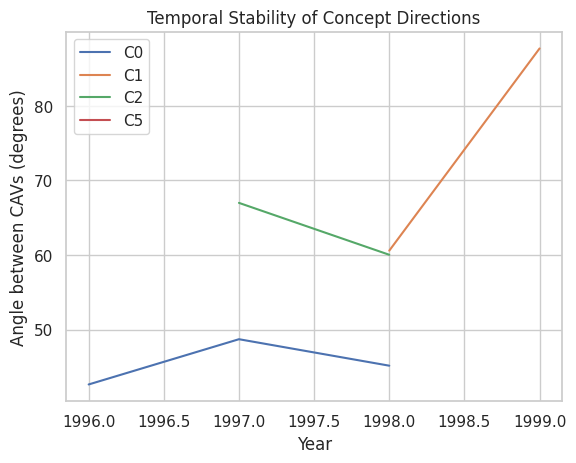

In [63]:
import matplotlib.pyplot as plt

plt.figure()
for concept_id in df_angles["concept"].unique():
    sub = df_angles[df_angles["concept"] == concept_id]
    plt.plot(sub["year_to"], sub["angle_deg"], label=f"C{concept_id}")

plt.xlabel("Year")
plt.ylabel("Angle between CAVs (degrees)")
plt.title("Temporal Stability of Concept Directions")
plt.legend()
plt.show()


In [64]:
globals().update({
    "surrogate_emb_to_p0": ridge,
    "surrogate_scaler": scaler
})
assert "surrogate_emb_to_p0" in globals()


In [69]:
# assumir:
# train_emb_flat
# cluster_labels
# years
# X_train_df (features originais)

concept_profiles = []

for c in np.unique(cluster_labels):
    for yr in np.unique(years):
        idx = (cluster_labels == c) & (years == yr)
        if idx.sum() < 10:
            continue

        means = X_train_df.loc[idx].mean()
        row = {
            "concept": c,
            "year": yr,
            "n_samples": int(idx.sum())
        }
        for k, v in means.items():
            row[f"mean_{k}"] = v
        concept_profiles.append(row)

df_concept_profiles = pd.DataFrame(concept_profiles)
display(df_concept_profiles.head())


,concept,year,n_samples,mean_sex_bin,mean_age,mean_kappa,mean_lambda,mean_flc.grp,mean_creatinine,mean_mgus,mean_futime
0,0,1995,50,0.820000,71.380000,2.638200,2.754400,9.520000,1.850000,0.0,2405.460000
1,0,1996,240,0.750000,75.129167,3.223708,3.519583,9.575000,1.836250,0.0,2350.866667
2,0,1997,63,0.571429,77.793651,2.947778,3.165238,9.507937,1.657143,0.0,2220.984127
3,0,1998,32,0.937500,71.531250,3.841250,3.758437,9.625000,1.984375,0.0,2660.000000
4,0,1999,12,1.000000,74.333333,2.610000,2.695833,9.750000,1.783333,0.0,2070.000000


In [70]:
display(
    df_concept_profiles
    .query("concept == 0")
    .sort_values("year")
)


,concept,year,n_samples,mean_sex_bin,mean_age,mean_kappa,mean_lambda,mean_flc.grp,mean_creatinine,mean_mgus,mean_futime
0,0,1995,50,0.820000,71.380000,2.638200,2.754400,9.520000,1.850000,0.0,2405.460000
1,0,1996,240,0.750000,75.129167,3.223708,3.519583,9.575000,1.836250,0.0,2350.866667
2,0,1997,63,0.571429,77.793651,2.947778,3.165238,9.507937,1.657143,0.0,2220.984127
3,0,1998,32,0.937500,71.531250,3.841250,3.758437,9.625000,1.984375,0.0,2660.000000
4,0,1999,12,1.000000,74.333333,2.610000,2.695833,9.750000,1.783333,0.0,2070.000000


In [71]:
def describe_concept(row, top_k=3):
    features = [(k.replace("mean_",""), row[k])
                for k in row.index if k.startswith("mean_")]
    features = sorted(features, key=lambda x: abs(x[1]), reverse=True)
    desc = ", ".join([f"{f}={v:.2f}" for f,v in features[:top_k]])
    return desc

df_concept_profiles["description"] = df_concept_profiles.apply(
    describe_concept, axis=1
)

display(df_concept_profiles[["concept","year","description"]].head())


,concept,year,description
0,0,1995,"futime=2405.46, age=71.38, flc.grp=9.52"
1,0,1996,"futime=2350.87, age=75.13, flc.grp=9.57"
2,0,1997,"futime=2220.98, age=77.79, flc.grp=9.51"
3,0,1998,"futime=2660.00, age=71.53, flc.grp=9.62"
4,0,1999,"futime=2070.00, age=74.33, flc.grp=9.75"


In [72]:
import numpy as np

def gram_schmidt(vectors):
    ortho = []
    for v in vectors:
        v = v.copy()
        for u in ortho:
            v -= np.dot(v, u) * u
        norm = np.linalg.norm(v)
        if norm > 1e-8:
            ortho.append(v / norm)
    return np.array(ortho)

# reconstruir cavs_embed a partir dos CAVs globais
cavs_embed = []

for concept_id, cav_dict in cavs_by_year.items():
    # pega o CAV médio ao longo do tempo
    Vs = np.stack(list(cav_dict.values()))
    v_mean = Vs.mean(axis=0)
    v_mean /= np.linalg.norm(v_mean)

    cavs_embed.append({
        "concept": concept_id,
        "v": v_mean
    })


V = np.stack([c["v"] for c in cavs_embed])
V_ortho = gram_schmidt(V)

cavs_ortho = []
for i, c in enumerate(cavs_embed):
    cavs_ortho.append({
        "concept": c["concept"],
        "v": V_ortho[i]
    })



In [73]:
# verificar normas
for c in cavs_ortho:
    print(c["concept"], np.linalg.norm(c["v"]))


0 1.0
1 0.9999999999999999
2 0.9999999999999999
3 1.0
4 1.0
5 1.0


In [74]:
dotmat = V_ortho @ V_ortho.T
np.fill_diagonal(dotmat, 0)

print("Máx correlação residual:", np.abs(dotmat).max())


Máx correlação residual: 7.487668042110521e-17


In [75]:
from sklearn.metrics import r2_score

def ablate_concept(X, cav):
    return X - (X @ cav)[:, None] * cav[None, :]


In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use o espaço de embedding flatten
Z = globals().get("train_emb_flat", None)
if Z is None:
    raise RuntimeError("train_emb_flat não encontrado. Rode a extração de embeddings e o flatten.")

# Normalizar antes do clustering (apenas para o clustering e CAVs; NÃO é o scaler do surrogate!)
Zs = StandardScaler().fit_transform(Z)

N_CONCEPTS = 6
kmeans = KMeans(n_clusters=N_CONCEPTS, random_state=globals().get("RNG_SEED", 42), n_init=20)
cluster_labels = kmeans.fit_predict(Zs)
print("Cluster labels shape:", cluster_labels.shape)

years = globals().get("years_train", None)
if years is None:
    years = globals()['train_rows']['year'].values
assert len(years) == Zs.shape[0] == len(cluster_labels)

activations_all = Zs.copy()

def train_cav(X_pos, X_neg):
    X = np.vstack([X_pos, X_neg])
    y = np.hstack([np.ones(len(X_pos)), np.zeros(len(X_neg))])
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X, y)
    v = clf.coef_[0]
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

# CAVs por ano por conceito (no espaço de embedding flatten normalizado Zs)
cavs_by_year = {}
for concept_id in np.unique(cluster_labels):
    cavs_by_year[concept_id] = {}
    for yr in np.unique(years):
        idx_pos = (cluster_labels == concept_id) & (years == yr)
        idx_neg = (cluster_labels != concept_id) & (years == yr)
        if idx_pos.sum() < 15 or idx_neg.sum() < 15:
            continue
        cav = train_cav(activations_all[idx_pos], activations_all[idx_neg])
        cavs_by_year[concept_id][yr] = cav

# Estabilidade temporal dos CAVs (ângulo entre anos)
rows = []
for concept_id, cavs in cavs_by_year.items():
    years_sorted = sorted(cavs.keys())
    for i in range(len(years_sorted) - 1):
        y1, y2 = years_sorted[i], years_sorted[i + 1]
        v1, v2 = cavs[y1], cavs[y2]
        cos_sim = float(np.dot(v1, v2))
        angle = float(np.degrees(np.arccos(np.clip(cos_sim, -1, 1))))
        rows.append({"concept": concept_id, "year_from": y1, "year_to": y2, "angle_deg": angle})
df_angles = pd.DataFrame(rows)
display(df_angles.head())

plt.figure()
for concept_id in df_angles["concept"].unique():
    sub = df_angles[df_angles["concept"] == concept_id]
    plt.plot(sub["year_to"], sub["angle_deg"], label=f"C{concept_id}")
plt.xlabel("Year"); plt.ylabel("Angle between CAVs (degrees)")
plt.title("Temporal Stability of Concept Directions")
plt.legend(); plt.show()

# Perfis de conceito nos dados originais (médias de features por conceito/ano)
X_train_df = globals().get("X_train_df", None)
if X_train_df is None:
    X_train_df = globals()['train_rows'][globals()['top_k_events']].copy()
concept_profiles = []
for c in np.unique(cluster_labels):
    for yr in np.unique(years):
        idx = (cluster_labels == c) & (years == yr)
        if idx.sum() < 10:
            continue
        means = X_train_df.loc[idx].mean()
        row = {"concept": c, "year": int(yr), "n_samples": int(idx.sum())}
        for k, v in means.items():
            row[f"mean_{k}"] = float(v)
        concept_profiles.append(row)
df_concept_profiles = pd.DataFrame(concept_profiles)
display(df_concept_profiles.head())

def describe_concept(row, top_k=3):
    features = [(k.replace("mean_",""), row[k]) for k in row.index if k.startswith("mean_")]
    features = sorted(features, key=lambda x: abs(x[1]), reverse=True)
    desc = ", ".join([f"{f}={v:.2f}" for f,v in features[:top_k]])
    return desc

df_concept_profiles["description"] = df_concept_profiles.apply(describe_concept, axis=1)
display(df_concept_profiles[["concept","year","description"]].head())

# Reconstruir CAVs globais (médios ao longo do tempo) no mesmo espaço Zs
def gram_schmidt(vectors):
    ortho = []
    for v in vectors:
        v = v.copy()
        for u in ortho:
            v -= np.dot(v, u) * u
        norm = np.linalg.norm(v)
        if norm > 1e-8:
            ortho.append(v / norm)
    return np.array(ortho)

cavs_embed = []
for concept_id, cav_dict in cavs_by_year.items():
    Vs = np.stack(list(cav_dict.values()))
    v_mean = Vs.mean(axis=0)
    v_mean /= np.linalg.norm(v_mean)
    cavs_embed.append({"concept": concept_id, "v": v_mean})

# Ortogonalizar (opcional)
V = np.stack([c["v"] for c in cavs_embed])
V_ortho = gram_schmidt(V)
cavs_ortho = [{"concept": cavs_embed[i]["concept"], "v": V_ortho[i]} for i in range(V_ortho.shape[0])]
for c in cavs_ortho:
    print("concept", c["concept"], "norm", np.linalg.norm(c["v"]))
dotmat = V_ortho @ V_ortho.T
np.fill_diagonal(dotmat, 0)
print("Max residual correlation:", float(np.abs(dotmat).max()))

# Expor para downstream
globals().update({
    "cluster_labels": cluster_labels,
    "cavs_by_year": cavs_by_year,
    "cavs_embed": cavs_embed,
    "cavs_ortho": cavs_ortho
})

NameError: name 'train_emb' is not defined

In [77]:
def tcav_score_linear(model, cav):
    """
    TCAV aproximado para surrogate linear:
    produto interno entre gradiente (coef_) e o CAV
    """
    grads = model.coef_.ravel()
    return float(np.dot(grads, cav))


WINDOW = 3
rows = []

years_unique = np.sort(np.unique(years))

for c in cavs_embed:
    for i in range(len(years_unique) - WINDOW + 1):
        win = years_unique[i:i+WINDOW]

        score = tcav_score_linear(
            surrogate_emb_to_p0,
            c["v"]
        )

        rows.append({
            "concept": c["concept"],
            "year_center": win.mean(),
            "tcav": score
        })

df_tcav_roll = pd.DataFrame(rows)
display(df_tcav_roll.head())



ValueError: shapes (128,) and (192,) not aligned: 128 (dim 0) != 192 (dim 0)

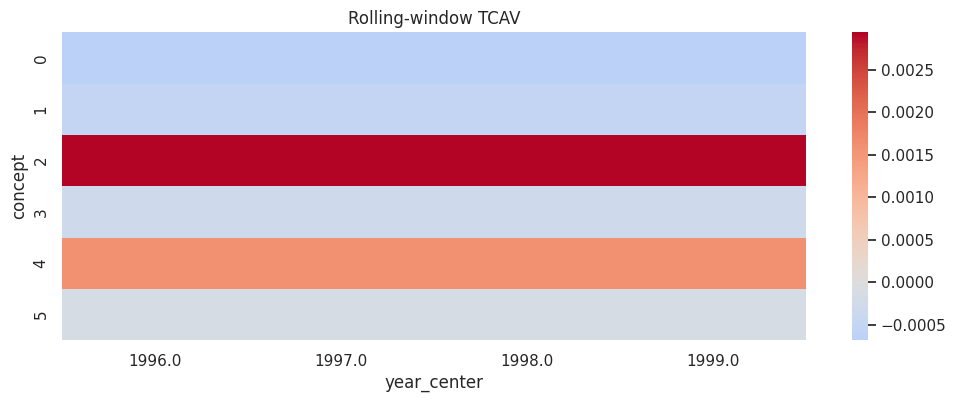

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = df_tcav_roll.pivot(
    index="concept",
    columns="year_center",
    values="tcav"
)

plt.figure(figsize=(12,4))
sns.heatmap(pivot, cmap="coolwarm", center=0)
plt.title("Rolling-window TCAV")
plt.show()


In [ ]:
def train_surrogate(X, y):
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)
    m = Ridge(alpha=RIDGE_ALPHA).fit(Xs, y)
    return m, scaler
WINDOW = 3
rows = []

for c in cavs_embed:
    for i in range(len(years_unique) - WINDOW + 1):
        win = years_unique[i:i+WINDOW]
        idx = np.isin(years, win)

        m_win, _ = train_surrogate(
            train_emb_flat[idx],
            p0_train[idx]
        )

        score = tcav_score_linear(m_win, c["v"])

        rows.append({
            "concept": c["concept"],
            "year_center": win.mean(),
            "tcav": score
        })

df_tcav_roll = pd.DataFrame(rows)


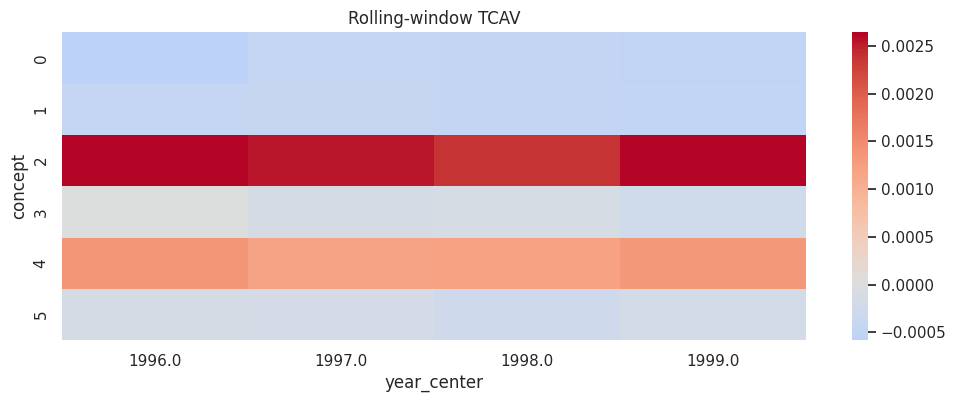

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = df_tcav_roll.pivot(
    index="concept",
    columns="year_center",
    values="tcav"
)

plt.figure(figsize=(12,4))
sns.heatmap(pivot, cmap="coolwarm", center=0)
plt.title("Rolling-window TCAV")
plt.show()


In [7]:
import shap

X_bg = Xtr_s[np.random.choice(len(Xtr_s), 200, replace=False)]
explainer = shap.LinearExplainer(surrogate_emb_to_p0, X_bg)

shap_vals = explainer.shap_values(Xval_s)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


NameError: name 'Xtr_s' is not defined